In [ ]:
# Install required libraries
!pip install transformers  # Installs the transformers library for NLP models
!pip install imageio       # Installs imageio to handle image files (e.g., GIFs)
!pip install gtts          # Installs Google Text-to-Speech API for text-to-speech
!pip install bert-score    # Installs the BERTScore metric library for evaluation
!pip install nltk          # Installs the NLTK library for natural language processing tasks
!pip install rouge-score   # Installs the Rouge score package for evaluation metrics

import os
import json
import random
import requests
import imageio
from PIL import Image
from io import BytesIO
import torch
from transformers import (
    BlipProcessor,
    BlipForConditionalGeneration,
    T5Tokenizer,
    T5ForConditionalGeneration,
    AdamW
)
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
import nltk
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu
# from nltk.translate.meteor_score import meteor_score
from rouge_score import rouge_scorer
from bert_score import score as bert_score_fn
import numpy as np

# Download NLTK data
nltk.download('wordnet')


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=61c85eea8e23df329d53ea7fc1d2576fd78d38fb7c2b343dcef09e93d6853814
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
import os
import json
import random

# Define paths
metadata_file = 'datafile.json'  # Path to your metadata file that contains GIF information
gifs_dir = 'gifs_temp'           # Directory to temporarily store GIFs

# Create temporary GIFs directory if it doesn't exist
os.makedirs(gifs_dir, exist_ok=True)

# Load metadata from the metadata file
with open(metadata_file, 'r') as f:
    metadata = json.load(f)

# Check if the dataset contains at least 100 GIFs, if not raise an error
if len(metadata) < 1000:
    raise ValueError("The metadata file contains fewer than 100 GIFs.")

# Randomly select 100 GIFs from the metadata for processing
selected_gifs = random.sample(metadata, 1000)

# Output the number of selected GIFs
print(f"Selected {len(selected_gifs)} random GIFs for processing.")


Selected 1000 random GIFs for processing.


In [ ]:
import time

# Enhanced download function with retries
def download_gif(url, save_path, max_retries=3, backoff_factor=2):
    for attempt in range(1, max_retries + 1):
        try:
            headers = {
                "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)"
            }
            response = requests.get(url, headers=headers, timeout=10)
            response.raise_for_status()
            with open(save_path, 'wb') as f:
                f.write(response.content)
            print(f"Downloaded: {save_path}")
            return True
        except requests.exceptions.HTTPError as http_err:
            print(f"HTTP error: {http_err} - Attempt {attempt}")
            if response.status_code == 404:
                break
        except requests.exceptions.RequestException as req_err:
            print(f"Request error: {req_err} - Attempt {attempt}")
        except Exception as e:
            print(f"Unexpected error: {e} - Attempt {attempt}")
        # Exponential backoff
        time.sleep(backoff_factor ** attempt)
    print(f"Failed to download {url}")
    return False

# Function to extract and preprocess frames from GIF
def extract_frames(gif_path, num_frames=5, frame_size=(256, 256)):
    try:
        gif = imageio.mimread(gif_path)
        total_frames = len(gif)

        if total_frames == 0:
            raise ValueError("No frames found in GIF.")

        interval = max(total_frames // num_frames, 1)
        selected_frames = [gif[i] for i in range(0, total_frames, interval)][:num_frames]

        processed_frames = []
        for frame in selected_frames:
            img = Image.fromarray(frame)
            if img.mode != 'RGB':
                img = img.convert('RGB')
            img_resized = img.resize(frame_size)
            processed_frames.append(np.array(img_resized))

        # Pad with the last frame or zeros
        while len(processed_frames) < num_frames:
            processed_frames.append(processed_frames[-1] if processed_frames else np.zeros((frame_size[0], frame_size[1], 3), dtype=np.uint8))

        return processed_frames

    except Exception as e:
        print(f"Failed to extract frames from {gif_path}: {e}")
        return []

# Function to delete GIF after processing
def delete_gif(gif_path):
    try:
        os.remove(gif_path)
        print(f"Deleted: {gif_path}")
    except Exception as e:
        print(f"Failed to delete {gif_path}: {e}")


In [ ]:
import torch
import numpy as np
from tqdm import tqdm
import os

# Initialize lists to store data
target_frames = []
target_texts = []

# Process each GIF
for gif in tqdm(selected_gifs, desc="Processing GIFs"):
    gif_id = gif.get('id')
    url = gif.get('url')
    reference_description = gif.get('description')

    # Validate GIF entry
    if not gif_id or not url or not reference_description:
        print(f"Invalid GIF entry: {gif}")
        continue

    # Define local path to save the GIF temporarily
    gif_filename = f"{gif_id}.gif"
    gif_path = os.path.join(gifs_dir, gif_filename)

    # Download the GIF
    success = download_gif(url, gif_path)
    if not success:
        print(f"Skipping GIF {gif_id} due to download failure.")
        continue

    # Extract frames
    selected_frames = extract_frames(gif_path, num_frames=5)

    # Validate frame extraction
    if not selected_frames:
        print(f"No frames extracted for {gif_id}. Skipping.")
        delete_gif(gif_path)
        continue

    # Append the extracted frames and corresponding text
    target_frames.append(selected_frames)
    target_texts.append(reference_description)

    # Delete the downloaded GIF
    delete_gif(gif_path)


Processing GIFs:   0%|          | 0/1000 [00:00<?, ?it/s]

Downloaded: gifs_temp/gif_125697.gif


Processing GIFs:   0%|          | 1/1000 [00:00<10:24,  1.60it/s]

Deleted: gifs_temp/gif_125697.gif


Processing GIFs:   0%|          | 2/1000 [00:01<09:58,  1.67it/s]

Downloaded: gifs_temp/gif_110376.gif
Deleted: gifs_temp/gif_110376.gif


Processing GIFs:   0%|          | 3/1000 [00:01<08:17,  2.01it/s]

Downloaded: gifs_temp/gif_42989.gif
Deleted: gifs_temp/gif_42989.gif


Processing GIFs:   0%|          | 4/1000 [00:02<07:44,  2.14it/s]

Downloaded: gifs_temp/gif_7125.gif
Deleted: gifs_temp/gif_7125.gif
Downloaded: gifs_temp/gif_114338.gif


Processing GIFs:   0%|          | 5/1000 [00:02<08:25,  1.97it/s]

Deleted: gifs_temp/gif_114338.gif


Processing GIFs:   1%|          | 6/1000 [00:03<08:42,  1.90it/s]

Downloaded: gifs_temp/gif_54888.gif
Deleted: gifs_temp/gif_54888.gif


Processing GIFs:   1%|          | 7/1000 [00:03<08:17,  2.00it/s]

Downloaded: gifs_temp/gif_81888.gif
Deleted: gifs_temp/gif_81888.gif


Processing GIFs:   1%|          | 8/1000 [00:04<07:58,  2.07it/s]

Downloaded: gifs_temp/gif_19207.gif
Deleted: gifs_temp/gif_19207.gif
Downloaded: gifs_temp/gif_41564.gif


Processing GIFs:   1%|          | 9/1000 [00:04<08:27,  1.95it/s]

Deleted: gifs_temp/gif_41564.gif
Downloaded: gifs_temp/gif_60139.gif


Processing GIFs:   1%|          | 10/1000 [00:05<08:42,  1.89it/s]

Deleted: gifs_temp/gif_60139.gif


Processing GIFs:   1%|          | 11/1000 [00:05<08:16,  1.99it/s]

Downloaded: gifs_temp/gif_113943.gif
Deleted: gifs_temp/gif_113943.gif
Downloaded: gifs_temp/gif_67364.gif


Processing GIFs:   1%|          | 12/1000 [00:06<08:57,  1.84it/s]

Deleted: gifs_temp/gif_67364.gif


Processing GIFs:   1%|▏         | 13/1000 [00:06<08:59,  1.83it/s]

Downloaded: gifs_temp/gif_79488.gif
Deleted: gifs_temp/gif_79488.gif
Downloaded: gifs_temp/gif_86809.gif


Processing GIFs:   1%|▏         | 14/1000 [00:08<12:39,  1.30it/s]

Deleted: gifs_temp/gif_86809.gif
Downloaded: gifs_temp/gif_80143.gif


Processing GIFs:   2%|▏         | 15/1000 [00:08<11:40,  1.41it/s]

Deleted: gifs_temp/gif_80143.gif
Downloaded: gifs_temp/gif_97882.gif


Processing GIFs:   2%|▏         | 16/1000 [00:09<10:59,  1.49it/s]

Deleted: gifs_temp/gif_97882.gif
Downloaded: gifs_temp/gif_74834.gif


Processing GIFs:   2%|▏         | 17/1000 [00:09<10:34,  1.55it/s]

Deleted: gifs_temp/gif_74834.gif
Downloaded: gifs_temp/gif_4954.gif


Processing GIFs:   2%|▏         | 18/1000 [00:10<10:33,  1.55it/s]

Deleted: gifs_temp/gif_4954.gif
Downloaded: gifs_temp/gif_53660.gif


Processing GIFs:   2%|▏         | 19/1000 [00:11<10:27,  1.56it/s]

Deleted: gifs_temp/gif_53660.gif
Downloaded: gifs_temp/gif_16507.gif


Processing GIFs:   2%|▏         | 20/1000 [00:11<10:50,  1.51it/s]

Deleted: gifs_temp/gif_16507.gif


Processing GIFs:   2%|▏         | 21/1000 [00:12<10:11,  1.60it/s]

Downloaded: gifs_temp/gif_89272.gif
Deleted: gifs_temp/gif_89272.gif
Downloaded: gifs_temp/gif_91686.gif


Processing GIFs:   2%|▏         | 22/1000 [00:13<10:44,  1.52it/s]

Deleted: gifs_temp/gif_91686.gif


Processing GIFs:   2%|▏         | 23/1000 [00:13<09:48,  1.66it/s]

Downloaded: gifs_temp/gif_108863.gif
Deleted: gifs_temp/gif_108863.gif


Processing GIFs:   2%|▏         | 24/1000 [00:14<11:00,  1.48it/s]

Downloaded: gifs_temp/gif_110368.gif
Deleted: gifs_temp/gif_110368.gif


Processing GIFs:   2%|▎         | 25/1000 [00:14<09:45,  1.67it/s]

Downloaded: gifs_temp/gif_33212.gif
Deleted: gifs_temp/gif_33212.gif


Processing GIFs:   3%|▎         | 26/1000 [00:15<09:31,  1.70it/s]

Downloaded: gifs_temp/gif_105228.gif
Deleted: gifs_temp/gif_105228.gif


Processing GIFs:   3%|▎         | 27/1000 [00:15<08:51,  1.83it/s]

Downloaded: gifs_temp/gif_63707.gif
Deleted: gifs_temp/gif_63707.gif


Processing GIFs:   3%|▎         | 28/1000 [00:16<08:09,  1.99it/s]

Downloaded: gifs_temp/gif_44911.gif
Deleted: gifs_temp/gif_44911.gif


Processing GIFs:   3%|▎         | 29/1000 [00:16<08:11,  1.98it/s]

Downloaded: gifs_temp/gif_116650.gif
Deleted: gifs_temp/gif_116650.gif


Processing GIFs:   3%|▎         | 30/1000 [00:17<09:05,  1.78it/s]

Downloaded: gifs_temp/gif_7115.gif
Deleted: gifs_temp/gif_7115.gif


Processing GIFs:   3%|▎         | 31/1000 [00:18<09:12,  1.76it/s]

Downloaded: gifs_temp/gif_44727.gif
Deleted: gifs_temp/gif_44727.gif
Downloaded: gifs_temp/gif_63994.gif


Processing GIFs:   3%|▎         | 32/1000 [00:18<09:08,  1.76it/s]

Deleted: gifs_temp/gif_63994.gif


Processing GIFs:   3%|▎         | 33/1000 [00:19<08:30,  1.89it/s]

Downloaded: gifs_temp/gif_89063.gif
Deleted: gifs_temp/gif_89063.gif
Downloaded: gifs_temp/gif_17138.gif


Processing GIFs:   3%|▎         | 34/1000 [00:20<10:54,  1.48it/s]

Deleted: gifs_temp/gif_17138.gif
Downloaded: gifs_temp/gif_37697.gif


Processing GIFs:   4%|▎         | 35/1000 [00:20<10:37,  1.51it/s]

Deleted: gifs_temp/gif_37697.gif
Downloaded: gifs_temp/gif_80140.gif


Processing GIFs:   4%|▎         | 36/1000 [00:21<11:05,  1.45it/s]

Deleted: gifs_temp/gif_80140.gif
Downloaded: gifs_temp/gif_35987.gif


Processing GIFs:   4%|▎         | 37/1000 [00:22<11:52,  1.35it/s]

Deleted: gifs_temp/gif_35987.gif


Processing GIFs:   4%|▍         | 38/1000 [00:22<10:52,  1.47it/s]

Downloaded: gifs_temp/gif_90318.gif
Deleted: gifs_temp/gif_90318.gif


Processing GIFs:   4%|▍         | 39/1000 [00:23<10:15,  1.56it/s]

Downloaded: gifs_temp/gif_22964.gif
Deleted: gifs_temp/gif_22964.gif


Processing GIFs:   4%|▍         | 40/1000 [00:23<09:36,  1.66it/s]

Downloaded: gifs_temp/gif_16856.gif
Deleted: gifs_temp/gif_16856.gif


Processing GIFs:   4%|▍         | 41/1000 [00:24<10:19,  1.55it/s]

Downloaded: gifs_temp/gif_109091.gif
Deleted: gifs_temp/gif_109091.gif


Processing GIFs:   4%|▍         | 42/1000 [00:25<08:57,  1.78it/s]

Downloaded: gifs_temp/gif_88758.gif
Deleted: gifs_temp/gif_88758.gif


Processing GIFs:   4%|▍         | 43/1000 [00:25<08:33,  1.86it/s]

Downloaded: gifs_temp/gif_51048.gif
Deleted: gifs_temp/gif_51048.gif


Processing GIFs:   4%|▍         | 44/1000 [00:25<08:08,  1.96it/s]

Downloaded: gifs_temp/gif_16897.gif
Deleted: gifs_temp/gif_16897.gif


Processing GIFs:   4%|▍         | 45/1000 [00:26<07:41,  2.07it/s]

Downloaded: gifs_temp/gif_109027.gif
Deleted: gifs_temp/gif_109027.gif


Processing GIFs:   5%|▍         | 46/1000 [00:26<07:19,  2.17it/s]

Downloaded: gifs_temp/gif_11311.gif
Deleted: gifs_temp/gif_11311.gif


Processing GIFs:   5%|▍         | 47/1000 [00:27<07:27,  2.13it/s]

Downloaded: gifs_temp/gif_632.gif
Deleted: gifs_temp/gif_632.gif


Processing GIFs:   5%|▍         | 48/1000 [00:27<07:07,  2.23it/s]

Downloaded: gifs_temp/gif_55189.gif
Deleted: gifs_temp/gif_55189.gif


Processing GIFs:   5%|▍         | 49/1000 [00:28<06:57,  2.28it/s]

Downloaded: gifs_temp/gif_71929.gif
Deleted: gifs_temp/gif_71929.gif


Processing GIFs:   5%|▌         | 50/1000 [00:28<08:25,  1.88it/s]

Downloaded: gifs_temp/gif_22822.gif
Deleted: gifs_temp/gif_22822.gif


Processing GIFs:   5%|▌         | 51/1000 [00:29<09:10,  1.72it/s]

Downloaded: gifs_temp/gif_91088.gif
Deleted: gifs_temp/gif_91088.gif


Processing GIFs:   5%|▌         | 52/1000 [00:29<08:40,  1.82it/s]

Downloaded: gifs_temp/gif_7083.gif
Deleted: gifs_temp/gif_7083.gif


Processing GIFs:   5%|▌         | 53/1000 [00:30<07:47,  2.03it/s]

Downloaded: gifs_temp/gif_30106.gif
Deleted: gifs_temp/gif_30106.gif


Processing GIFs:   5%|▌         | 54/1000 [00:30<07:13,  2.18it/s]

Downloaded: gifs_temp/gif_117178.gif
Deleted: gifs_temp/gif_117178.gif


Processing GIFs:   6%|▌         | 55/1000 [00:31<06:50,  2.30it/s]

Downloaded: gifs_temp/gif_43799.gif
Deleted: gifs_temp/gif_43799.gif


Processing GIFs:   6%|▌         | 56/1000 [00:31<06:31,  2.41it/s]

Downloaded: gifs_temp/gif_106825.gif
Deleted: gifs_temp/gif_106825.gif


Processing GIFs:   6%|▌         | 57/1000 [00:31<06:08,  2.56it/s]

Downloaded: gifs_temp/gif_73857.gif
Deleted: gifs_temp/gif_73857.gif


Processing GIFs:   6%|▌         | 58/1000 [00:32<06:11,  2.54it/s]

Downloaded: gifs_temp/gif_55708.gif
Deleted: gifs_temp/gif_55708.gif


Processing GIFs:   6%|▌         | 59/1000 [00:32<06:12,  2.53it/s]

Downloaded: gifs_temp/gif_84826.gif
Deleted: gifs_temp/gif_84826.gif


Processing GIFs:   6%|▌         | 60/1000 [00:33<06:08,  2.55it/s]

Downloaded: gifs_temp/gif_56561.gif
Deleted: gifs_temp/gif_56561.gif


Processing GIFs:   6%|▌         | 61/1000 [00:33<06:01,  2.60it/s]

Downloaded: gifs_temp/gif_102459.gif
Deleted: gifs_temp/gif_102459.gif


Processing GIFs:   6%|▌         | 62/1000 [00:33<06:06,  2.56it/s]

Downloaded: gifs_temp/gif_65112.gif
Deleted: gifs_temp/gif_65112.gif


Processing GIFs:   6%|▋         | 63/1000 [00:34<05:59,  2.60it/s]

Downloaded: gifs_temp/gif_57878.gif
Deleted: gifs_temp/gif_57878.gif


Processing GIFs:   6%|▋         | 64/1000 [00:34<06:04,  2.57it/s]

Downloaded: gifs_temp/gif_26579.gif
Deleted: gifs_temp/gif_26579.gif


Processing GIFs:   6%|▋         | 65/1000 [00:34<06:05,  2.56it/s]

Downloaded: gifs_temp/gif_123554.gif
Deleted: gifs_temp/gif_123554.gif


Processing GIFs:   7%|▋         | 66/1000 [00:35<06:05,  2.56it/s]

Downloaded: gifs_temp/gif_52966.gif
Deleted: gifs_temp/gif_52966.gif


Processing GIFs:   7%|▋         | 67/1000 [00:35<05:50,  2.66it/s]

Downloaded: gifs_temp/gif_4820.gif
Deleted: gifs_temp/gif_4820.gif


Processing GIFs:   7%|▋         | 68/1000 [00:36<05:59,  2.59it/s]

Downloaded: gifs_temp/gif_55848.gif
Deleted: gifs_temp/gif_55848.gif


Processing GIFs:   7%|▋         | 69/1000 [00:36<07:19,  2.12it/s]

Downloaded: gifs_temp/gif_64867.gif
Deleted: gifs_temp/gif_64867.gif


Processing GIFs:   7%|▋         | 70/1000 [00:37<06:41,  2.32it/s]

Downloaded: gifs_temp/gif_39871.gif
Deleted: gifs_temp/gif_39871.gif


Processing GIFs:   7%|▋         | 71/1000 [00:37<07:02,  2.20it/s]

Downloaded: gifs_temp/gif_79237.gif
Deleted: gifs_temp/gif_79237.gif


Processing GIFs:   7%|▋         | 72/1000 [00:37<06:30,  2.37it/s]

Downloaded: gifs_temp/gif_36709.gif
Deleted: gifs_temp/gif_36709.gif


Processing GIFs:   7%|▋         | 73/1000 [00:38<06:24,  2.41it/s]

Downloaded: gifs_temp/gif_75098.gif
Deleted: gifs_temp/gif_75098.gif


Processing GIFs:   7%|▋         | 74/1000 [00:38<06:41,  2.31it/s]

Downloaded: gifs_temp/gif_39251.gif
Deleted: gifs_temp/gif_39251.gif


Processing GIFs:   8%|▊         | 75/1000 [00:39<06:46,  2.28it/s]

Downloaded: gifs_temp/gif_57009.gif
Deleted: gifs_temp/gif_57009.gif


Processing GIFs:   8%|▊         | 76/1000 [00:39<06:43,  2.29it/s]

Downloaded: gifs_temp/gif_4486.gif
Deleted: gifs_temp/gif_4486.gif


Processing GIFs:   8%|▊         | 77/1000 [00:40<06:24,  2.40it/s]

Downloaded: gifs_temp/gif_51669.gif
Deleted: gifs_temp/gif_51669.gif


Processing GIFs:   8%|▊         | 78/1000 [00:40<05:56,  2.59it/s]

Downloaded: gifs_temp/gif_40200.gif
Deleted: gifs_temp/gif_40200.gif


Processing GIFs:   8%|▊         | 79/1000 [00:41<07:29,  2.05it/s]

Downloaded: gifs_temp/gif_122881.gif
Deleted: gifs_temp/gif_122881.gif


Processing GIFs:   8%|▊         | 80/1000 [00:41<06:54,  2.22it/s]

Downloaded: gifs_temp/gif_113913.gif
Deleted: gifs_temp/gif_113913.gif


Processing GIFs:   8%|▊         | 81/1000 [00:41<06:14,  2.46it/s]

Downloaded: gifs_temp/gif_29798.gif
Deleted: gifs_temp/gif_29798.gif


Processing GIFs:   8%|▊         | 82/1000 [00:42<06:51,  2.23it/s]

Downloaded: gifs_temp/gif_8129.gif
Deleted: gifs_temp/gif_8129.gif


Processing GIFs:   8%|▊         | 83/1000 [00:42<06:46,  2.26it/s]

Downloaded: gifs_temp/gif_48726.gif
Deleted: gifs_temp/gif_48726.gif


Processing GIFs:   8%|▊         | 84/1000 [00:43<06:44,  2.27it/s]

Downloaded: gifs_temp/gif_94552.gif
Deleted: gifs_temp/gif_94552.gif


Processing GIFs:   8%|▊         | 85/1000 [00:43<07:15,  2.10it/s]

Downloaded: gifs_temp/gif_122260.gif
Deleted: gifs_temp/gif_122260.gif


Processing GIFs:   9%|▊         | 86/1000 [00:44<07:17,  2.09it/s]

Downloaded: gifs_temp/gif_122076.gif
Deleted: gifs_temp/gif_122076.gif


Processing GIFs:   9%|▊         | 87/1000 [00:45<08:47,  1.73it/s]

Downloaded: gifs_temp/gif_20157.gif
Deleted: gifs_temp/gif_20157.gif
Downloaded: gifs_temp/gif_87168.gif


Processing GIFs:   9%|▉         | 88/1000 [00:45<08:54,  1.71it/s]

Deleted: gifs_temp/gif_87168.gif


Processing GIFs:   9%|▉         | 89/1000 [00:46<08:32,  1.78it/s]

Downloaded: gifs_temp/gif_112339.gif
Deleted: gifs_temp/gif_112339.gif


Processing GIFs:   9%|▉         | 90/1000 [00:46<07:28,  2.03it/s]

Downloaded: gifs_temp/gif_16296.gif
Deleted: gifs_temp/gif_16296.gif


Processing GIFs:   9%|▉         | 91/1000 [00:47<09:19,  1.62it/s]

Downloaded: gifs_temp/gif_81587.gif
Deleted: gifs_temp/gif_81587.gif


Processing GIFs:   9%|▉         | 92/1000 [00:48<11:09,  1.36it/s]

Downloaded: gifs_temp/gif_111285.gif
Deleted: gifs_temp/gif_111285.gif
Downloaded: gifs_temp/gif_68028.gif


Processing GIFs:   9%|▉         | 93/1000 [00:49<10:54,  1.39it/s]

Deleted: gifs_temp/gif_68028.gif


Processing GIFs:   9%|▉         | 94/1000 [00:49<10:11,  1.48it/s]

Downloaded: gifs_temp/gif_28390.gif
Deleted: gifs_temp/gif_28390.gif
Downloaded: gifs_temp/gif_90888.gif


Processing GIFs:  10%|▉         | 95/1000 [00:50<09:51,  1.53it/s]

Deleted: gifs_temp/gif_90888.gif


Processing GIFs:  10%|▉         | 96/1000 [00:50<10:05,  1.49it/s]

Downloaded: gifs_temp/gif_113373.gif
Deleted: gifs_temp/gif_113373.gif


Processing GIFs:  10%|▉         | 97/1000 [00:51<08:53,  1.69it/s]

Downloaded: gifs_temp/gif_2073.gif
Deleted: gifs_temp/gif_2073.gif


Processing GIFs:  10%|▉         | 98/1000 [00:51<07:35,  1.98it/s]

Downloaded: gifs_temp/gif_60605.gif
Deleted: gifs_temp/gif_60605.gif


Processing GIFs:  10%|▉         | 99/1000 [00:52<06:53,  2.18it/s]

Downloaded: gifs_temp/gif_1735.gif
Deleted: gifs_temp/gif_1735.gif


Processing GIFs:  10%|█         | 100/1000 [00:52<06:29,  2.31it/s]

Downloaded: gifs_temp/gif_5885.gif
Deleted: gifs_temp/gif_5885.gif


Processing GIFs:  10%|█         | 101/1000 [00:52<06:11,  2.42it/s]

Downloaded: gifs_temp/gif_44822.gif
Deleted: gifs_temp/gif_44822.gif


Processing GIFs:  10%|█         | 102/1000 [00:53<06:21,  2.35it/s]

Downloaded: gifs_temp/gif_44050.gif
Deleted: gifs_temp/gif_44050.gif


Processing GIFs:  10%|█         | 103/1000 [00:54<07:58,  1.88it/s]

Downloaded: gifs_temp/gif_51061.gif
Deleted: gifs_temp/gif_51061.gif


Processing GIFs:  10%|█         | 104/1000 [00:54<06:51,  2.18it/s]

Downloaded: gifs_temp/gif_6044.gif
Deleted: gifs_temp/gif_6044.gif


Processing GIFs:  10%|█         | 105/1000 [00:54<06:27,  2.31it/s]

Downloaded: gifs_temp/gif_35080.gif
Deleted: gifs_temp/gif_35080.gif


Processing GIFs:  11%|█         | 106/1000 [00:55<06:18,  2.36it/s]

Downloaded: gifs_temp/gif_94127.gif
Deleted: gifs_temp/gif_94127.gif


Processing GIFs:  11%|█         | 107/1000 [00:55<06:09,  2.42it/s]

Downloaded: gifs_temp/gif_74756.gif
Deleted: gifs_temp/gif_74756.gif


Processing GIFs:  11%|█         | 108/1000 [00:55<05:51,  2.54it/s]

Downloaded: gifs_temp/gif_83612.gif
Deleted: gifs_temp/gif_83612.gif


Processing GIFs:  11%|█         | 109/1000 [00:56<05:49,  2.55it/s]

Downloaded: gifs_temp/gif_105034.gif
Deleted: gifs_temp/gif_105034.gif


Processing GIFs:  11%|█         | 110/1000 [00:56<05:41,  2.60it/s]

Downloaded: gifs_temp/gif_51079.gif
Deleted: gifs_temp/gif_51079.gif


Processing GIFs:  11%|█         | 111/1000 [00:57<06:24,  2.31it/s]

Downloaded: gifs_temp/gif_93001.gif
Deleted: gifs_temp/gif_93001.gif


Processing GIFs:  11%|█         | 112/1000 [00:57<06:08,  2.41it/s]

Downloaded: gifs_temp/gif_30501.gif
Deleted: gifs_temp/gif_30501.gif


Processing GIFs:  11%|█▏        | 113/1000 [00:58<07:48,  1.89it/s]

Downloaded: gifs_temp/gif_30315.gif
Deleted: gifs_temp/gif_30315.gif


Processing GIFs:  11%|█▏        | 114/1000 [00:58<06:52,  2.15it/s]

Downloaded: gifs_temp/gif_50095.gif
Deleted: gifs_temp/gif_50095.gif


Processing GIFs:  12%|█▏        | 115/1000 [00:59<07:39,  1.92it/s]

Downloaded: gifs_temp/gif_50489.gif
Deleted: gifs_temp/gif_50489.gif


Processing GIFs:  12%|█▏        | 116/1000 [00:59<06:52,  2.14it/s]

Downloaded: gifs_temp/gif_67703.gif
Deleted: gifs_temp/gif_67703.gif


Processing GIFs:  12%|█▏        | 117/1000 [01:00<07:57,  1.85it/s]

Downloaded: gifs_temp/gif_46808.gif
Deleted: gifs_temp/gif_46808.gif


Processing GIFs:  12%|█▏        | 118/1000 [01:00<06:59,  2.10it/s]

Downloaded: gifs_temp/gif_5249.gif
Deleted: gifs_temp/gif_5249.gif


Processing GIFs:  12%|█▏        | 119/1000 [01:01<07:13,  2.03it/s]

Downloaded: gifs_temp/gif_71984.gif
Deleted: gifs_temp/gif_71984.gif


Processing GIFs:  12%|█▏        | 120/1000 [01:01<07:03,  2.08it/s]

Downloaded: gifs_temp/gif_849.gif
Deleted: gifs_temp/gif_849.gif


Processing GIFs:  12%|█▏        | 121/1000 [01:02<06:52,  2.13it/s]

Downloaded: gifs_temp/gif_106756.gif
Deleted: gifs_temp/gif_106756.gif


Processing GIFs:  12%|█▏        | 122/1000 [01:02<08:25,  1.74it/s]

Downloaded: gifs_temp/gif_19301.gif
Deleted: gifs_temp/gif_19301.gif


Processing GIFs:  12%|█▏        | 123/1000 [01:03<07:46,  1.88it/s]

Downloaded: gifs_temp/gif_69925.gif
Deleted: gifs_temp/gif_69925.gif


Processing GIFs:  12%|█▏        | 124/1000 [01:03<07:40,  1.90it/s]

Downloaded: gifs_temp/gif_63447.gif
Deleted: gifs_temp/gif_63447.gif


Processing GIFs:  12%|█▎        | 125/1000 [01:04<07:11,  2.03it/s]

Downloaded: gifs_temp/gif_21624.gif
Deleted: gifs_temp/gif_21624.gif


Processing GIFs:  13%|█▎        | 126/1000 [01:04<07:19,  1.99it/s]

Downloaded: gifs_temp/gif_34808.gif
Deleted: gifs_temp/gif_34808.gif


Processing GIFs:  13%|█▎        | 127/1000 [01:05<06:56,  2.09it/s]

Downloaded: gifs_temp/gif_120939.gif
Deleted: gifs_temp/gif_120939.gif


Processing GIFs:  13%|█▎        | 128/1000 [01:05<06:56,  2.09it/s]

Downloaded: gifs_temp/gif_96165.gif
Deleted: gifs_temp/gif_96165.gif


Processing GIFs:  13%|█▎        | 129/1000 [01:06<06:35,  2.20it/s]

Downloaded: gifs_temp/gif_33768.gif
Deleted: gifs_temp/gif_33768.gif


Processing GIFs:  13%|█▎        | 130/1000 [01:06<06:23,  2.27it/s]

Downloaded: gifs_temp/gif_49701.gif
Deleted: gifs_temp/gif_49701.gif


Processing GIFs:  13%|█▎        | 131/1000 [01:07<08:41,  1.67it/s]

Downloaded: gifs_temp/gif_103944.gif
Deleted: gifs_temp/gif_103944.gif


Processing GIFs:  13%|█▎        | 132/1000 [01:08<09:03,  1.60it/s]

Downloaded: gifs_temp/gif_11000.gif
Deleted: gifs_temp/gif_11000.gif


Processing GIFs:  13%|█▎        | 133/1000 [01:08<07:51,  1.84it/s]

Downloaded: gifs_temp/gif_35936.gif
Deleted: gifs_temp/gif_35936.gif


Processing GIFs:  13%|█▎        | 134/1000 [01:08<07:04,  2.04it/s]

Downloaded: gifs_temp/gif_55829.gif
Deleted: gifs_temp/gif_55829.gif


Processing GIFs:  14%|█▎        | 135/1000 [01:09<06:49,  2.11it/s]

Downloaded: gifs_temp/gif_44485.gif
Deleted: gifs_temp/gif_44485.gif


Processing GIFs:  14%|█▎        | 136/1000 [01:09<06:25,  2.24it/s]

Downloaded: gifs_temp/gif_24770.gif
Deleted: gifs_temp/gif_24770.gif


Processing GIFs:  14%|█▎        | 137/1000 [01:10<07:12,  1.99it/s]

Downloaded: gifs_temp/gif_114192.gif
Deleted: gifs_temp/gif_114192.gif


Processing GIFs:  14%|█▍        | 138/1000 [01:10<06:20,  2.27it/s]

Downloaded: gifs_temp/gif_34400.gif
Deleted: gifs_temp/gif_34400.gif


Processing GIFs:  14%|█▍        | 139/1000 [01:11<07:23,  1.94it/s]

Downloaded: gifs_temp/gif_46831.gif
Deleted: gifs_temp/gif_46831.gif


Processing GIFs:  14%|█▍        | 140/1000 [01:11<06:53,  2.08it/s]

Downloaded: gifs_temp/gif_56890.gif
Deleted: gifs_temp/gif_56890.gif


Processing GIFs:  14%|█▍        | 141/1000 [01:12<06:31,  2.20it/s]

Downloaded: gifs_temp/gif_31796.gif
Deleted: gifs_temp/gif_31796.gif


Processing GIFs:  14%|█▍        | 142/1000 [01:12<06:04,  2.35it/s]

Downloaded: gifs_temp/gif_11856.gif
Deleted: gifs_temp/gif_11856.gif


Processing GIFs:  14%|█▍        | 143/1000 [01:12<05:44,  2.49it/s]

Downloaded: gifs_temp/gif_856.gif
Deleted: gifs_temp/gif_856.gif


Processing GIFs:  14%|█▍        | 144/1000 [01:13<05:30,  2.59it/s]

Downloaded: gifs_temp/gif_20890.gif
Deleted: gifs_temp/gif_20890.gif


Processing GIFs:  14%|█▍        | 145/1000 [01:13<05:42,  2.50it/s]

Downloaded: gifs_temp/gif_39030.gif
Deleted: gifs_temp/gif_39030.gif


Processing GIFs:  15%|█▍        | 146/1000 [01:14<05:52,  2.42it/s]

Downloaded: gifs_temp/gif_120726.gif
Deleted: gifs_temp/gif_120726.gif
Downloaded: gifs_temp/gif_38299.gif


Processing GIFs:  15%|█▍        | 147/1000 [01:14<06:33,  2.17it/s]

Deleted: gifs_temp/gif_38299.gif
Downloaded: gifs_temp/gif_57481.gif


Processing GIFs:  15%|█▍        | 148/1000 [01:15<06:46,  2.10it/s]

Deleted: gifs_temp/gif_57481.gif


Processing GIFs:  15%|█▍        | 149/1000 [01:15<06:35,  2.15it/s]

Downloaded: gifs_temp/gif_6862.gif
Deleted: gifs_temp/gif_6862.gif
Downloaded: gifs_temp/gif_90338.gif


Processing GIFs:  15%|█▌        | 150/1000 [01:16<07:01,  2.02it/s]

Deleted: gifs_temp/gif_90338.gif
Downloaded: gifs_temp/gif_55300.gif


Processing GIFs:  15%|█▌        | 151/1000 [01:17<08:52,  1.59it/s]

Deleted: gifs_temp/gif_55300.gif
Downloaded: gifs_temp/gif_67140.gif


Processing GIFs:  15%|█▌        | 152/1000 [01:17<09:25,  1.50it/s]

Deleted: gifs_temp/gif_67140.gif


Processing GIFs:  15%|█▌        | 153/1000 [01:18<08:23,  1.68it/s]

Downloaded: gifs_temp/gif_90490.gif
Deleted: gifs_temp/gif_90490.gif


Processing GIFs:  15%|█▌        | 154/1000 [01:18<07:40,  1.84it/s]

Downloaded: gifs_temp/gif_77221.gif
Deleted: gifs_temp/gif_77221.gif


Processing GIFs:  16%|█▌        | 155/1000 [01:19<08:17,  1.70it/s]

Downloaded: gifs_temp/gif_10085.gif
Deleted: gifs_temp/gif_10085.gif


Processing GIFs:  16%|█▌        | 156/1000 [01:19<07:20,  1.92it/s]

Downloaded: gifs_temp/gif_20647.gif
Deleted: gifs_temp/gif_20647.gif


Processing GIFs:  16%|█▌        | 157/1000 [01:20<06:35,  2.13it/s]

Downloaded: gifs_temp/gif_33225.gif
Deleted: gifs_temp/gif_33225.gif


Processing GIFs:  16%|█▌        | 158/1000 [01:20<06:09,  2.28it/s]

Downloaded: gifs_temp/gif_4465.gif
Deleted: gifs_temp/gif_4465.gif


Processing GIFs:  16%|█▌        | 159/1000 [01:20<06:03,  2.31it/s]

Downloaded: gifs_temp/gif_109722.gif
Deleted: gifs_temp/gif_109722.gif


Processing GIFs:  16%|█▌        | 160/1000 [01:21<06:03,  2.31it/s]

Downloaded: gifs_temp/gif_81328.gif
Deleted: gifs_temp/gif_81328.gif


Processing GIFs:  16%|█▌        | 161/1000 [01:22<08:14,  1.70it/s]

Downloaded: gifs_temp/gif_82146.gif
Deleted: gifs_temp/gif_82146.gif


Processing GIFs:  16%|█▌        | 162/1000 [01:22<07:21,  1.90it/s]

Downloaded: gifs_temp/gif_59988.gif
Deleted: gifs_temp/gif_59988.gif


Processing GIFs:  16%|█▋        | 163/1000 [01:22<06:27,  2.16it/s]

Downloaded: gifs_temp/gif_635.gif
Deleted: gifs_temp/gif_635.gif


Processing GIFs:  16%|█▋        | 164/1000 [01:23<06:13,  2.24it/s]

Downloaded: gifs_temp/gif_3917.gif
Deleted: gifs_temp/gif_3917.gif


Processing GIFs:  16%|█▋        | 165/1000 [01:23<05:54,  2.36it/s]

Downloaded: gifs_temp/gif_64500.gif
Deleted: gifs_temp/gif_64500.gif


Processing GIFs:  17%|█▋        | 166/1000 [01:24<05:41,  2.44it/s]

Downloaded: gifs_temp/gif_7870.gif
Deleted: gifs_temp/gif_7870.gif
Downloaded: gifs_temp/gif_15467.gif


Processing GIFs:  17%|█▋        | 167/1000 [01:24<06:34,  2.11it/s]

Deleted: gifs_temp/gif_15467.gif


Processing GIFs:  17%|█▋        | 168/1000 [01:25<07:06,  1.95it/s]

Downloaded: gifs_temp/gif_98416.gif
Deleted: gifs_temp/gif_98416.gif


Processing GIFs:  17%|█▋        | 169/1000 [01:25<06:44,  2.06it/s]

Downloaded: gifs_temp/gif_59573.gif
Deleted: gifs_temp/gif_59573.gif


Processing GIFs:  17%|█▋        | 170/1000 [01:26<06:16,  2.20it/s]

Downloaded: gifs_temp/gif_7467.gif
Deleted: gifs_temp/gif_7467.gif


Processing GIFs:  17%|█▋        | 171/1000 [01:26<05:39,  2.44it/s]

Downloaded: gifs_temp/gif_35586.gif
Deleted: gifs_temp/gif_35586.gif


Processing GIFs:  17%|█▋        | 172/1000 [01:26<05:45,  2.40it/s]

Downloaded: gifs_temp/gif_117170.gif
Deleted: gifs_temp/gif_117170.gif


Processing GIFs:  17%|█▋        | 173/1000 [01:27<05:35,  2.46it/s]

Downloaded: gifs_temp/gif_79478.gif
Deleted: gifs_temp/gif_79478.gif


Processing GIFs:  17%|█▋        | 174/1000 [01:27<05:43,  2.41it/s]

Downloaded: gifs_temp/gif_69581.gif
Deleted: gifs_temp/gif_69581.gif


Processing GIFs:  18%|█▊        | 175/1000 [01:28<06:02,  2.28it/s]

Downloaded: gifs_temp/gif_60052.gif
Deleted: gifs_temp/gif_60052.gif


Processing GIFs:  18%|█▊        | 176/1000 [01:28<05:41,  2.41it/s]

Downloaded: gifs_temp/gif_190.gif
Deleted: gifs_temp/gif_190.gif


Processing GIFs:  18%|█▊        | 177/1000 [01:28<05:31,  2.48it/s]

Downloaded: gifs_temp/gif_1458.gif
Deleted: gifs_temp/gif_1458.gif


Processing GIFs:  18%|█▊        | 178/1000 [01:29<05:33,  2.46it/s]

Downloaded: gifs_temp/gif_25644.gif
Deleted: gifs_temp/gif_25644.gif


Processing GIFs:  18%|█▊        | 179/1000 [01:29<05:54,  2.32it/s]

Downloaded: gifs_temp/gif_64014.gif
Deleted: gifs_temp/gif_64014.gif


Processing GIFs:  18%|█▊        | 180/1000 [01:30<05:58,  2.28it/s]

Downloaded: gifs_temp/gif_495.gif
Deleted: gifs_temp/gif_495.gif


Processing GIFs:  18%|█▊        | 181/1000 [01:30<06:22,  2.14it/s]

Downloaded: gifs_temp/gif_52329.gif
Deleted: gifs_temp/gif_52329.gif


Processing GIFs:  18%|█▊        | 182/1000 [01:31<06:09,  2.22it/s]

Downloaded: gifs_temp/gif_7732.gif
Deleted: gifs_temp/gif_7732.gif


Processing GIFs:  18%|█▊        | 183/1000 [01:31<06:02,  2.26it/s]

Downloaded: gifs_temp/gif_24749.gif
Deleted: gifs_temp/gif_24749.gif


Processing GIFs:  18%|█▊        | 184/1000 [01:32<07:27,  1.82it/s]

Downloaded: gifs_temp/gif_83904.gif
Deleted: gifs_temp/gif_83904.gif


Processing GIFs:  18%|█▊        | 185/1000 [01:32<06:55,  1.96it/s]

Downloaded: gifs_temp/gif_31032.gif
Deleted: gifs_temp/gif_31032.gif


Processing GIFs:  19%|█▊        | 186/1000 [01:33<06:46,  2.00it/s]

Downloaded: gifs_temp/gif_118320.gif
Deleted: gifs_temp/gif_118320.gif


Processing GIFs:  19%|█▊        | 187/1000 [01:33<06:27,  2.10it/s]

Downloaded: gifs_temp/gif_97173.gif
Deleted: gifs_temp/gif_97173.gif


Processing GIFs:  19%|█▉        | 188/1000 [01:34<06:19,  2.14it/s]

Downloaded: gifs_temp/gif_53337.gif
Deleted: gifs_temp/gif_53337.gif


Processing GIFs:  19%|█▉        | 189/1000 [01:34<05:57,  2.27it/s]

Downloaded: gifs_temp/gif_113738.gif
Deleted: gifs_temp/gif_113738.gif


Processing GIFs:  19%|█▉        | 190/1000 [01:34<05:48,  2.33it/s]

Downloaded: gifs_temp/gif_13588.gif
Deleted: gifs_temp/gif_13588.gif


Processing GIFs:  19%|█▉        | 191/1000 [01:35<05:28,  2.47it/s]

Downloaded: gifs_temp/gif_123844.gif
Deleted: gifs_temp/gif_123844.gif


Processing GIFs:  19%|█▉        | 192/1000 [01:35<05:22,  2.50it/s]

Downloaded: gifs_temp/gif_10895.gif
Deleted: gifs_temp/gif_10895.gif


Processing GIFs:  19%|█▉        | 193/1000 [01:36<05:26,  2.47it/s]

Downloaded: gifs_temp/gif_95973.gif
Deleted: gifs_temp/gif_95973.gif


Processing GIFs:  19%|█▉        | 194/1000 [01:36<06:15,  2.15it/s]

Downloaded: gifs_temp/gif_56696.gif
Deleted: gifs_temp/gif_56696.gif


Processing GIFs:  20%|█▉        | 195/1000 [01:37<05:53,  2.28it/s]

Downloaded: gifs_temp/gif_63479.gif
Deleted: gifs_temp/gif_63479.gif


Processing GIFs:  20%|█▉        | 196/1000 [01:37<07:37,  1.76it/s]

Downloaded: gifs_temp/gif_29697.gif
Deleted: gifs_temp/gif_29697.gif


Processing GIFs:  20%|█▉        | 197/1000 [01:38<06:54,  1.94it/s]

Downloaded: gifs_temp/gif_88368.gif
Deleted: gifs_temp/gif_88368.gif


Processing GIFs:  20%|█▉        | 198/1000 [01:38<06:04,  2.20it/s]

Downloaded: gifs_temp/gif_73511.gif
Deleted: gifs_temp/gif_73511.gif


Processing GIFs:  20%|█▉        | 199/1000 [01:39<07:07,  1.87it/s]

Downloaded: gifs_temp/gif_124490.gif
Deleted: gifs_temp/gif_124490.gif


Processing GIFs:  20%|██        | 200/1000 [01:39<06:29,  2.06it/s]

Downloaded: gifs_temp/gif_90596.gif
Deleted: gifs_temp/gif_90596.gif


Processing GIFs:  20%|██        | 201/1000 [01:40<05:46,  2.31it/s]

Downloaded: gifs_temp/gif_37090.gif
Deleted: gifs_temp/gif_37090.gif


Processing GIFs:  20%|██        | 202/1000 [01:40<05:34,  2.38it/s]

Downloaded: gifs_temp/gif_97993.gif
Deleted: gifs_temp/gif_97993.gif


Processing GIFs:  20%|██        | 203/1000 [01:40<05:25,  2.45it/s]

Downloaded: gifs_temp/gif_35650.gif
Deleted: gifs_temp/gif_35650.gif


Processing GIFs:  20%|██        | 204/1000 [01:41<06:23,  2.08it/s]

Downloaded: gifs_temp/gif_18177.gif
Deleted: gifs_temp/gif_18177.gif


Processing GIFs:  20%|██        | 205/1000 [01:41<06:15,  2.12it/s]

Downloaded: gifs_temp/gif_19810.gif
Deleted: gifs_temp/gif_19810.gif


Processing GIFs:  21%|██        | 206/1000 [01:42<06:10,  2.14it/s]

Downloaded: gifs_temp/gif_70162.gif
Deleted: gifs_temp/gif_70162.gif
Downloaded: gifs_temp/gif_18936.gif


Processing GIFs:  21%|██        | 207/1000 [01:43<09:54,  1.33it/s]

Deleted: gifs_temp/gif_18936.gif


Processing GIFs:  21%|██        | 208/1000 [01:44<08:54,  1.48it/s]

Downloaded: gifs_temp/gif_100868.gif
Deleted: gifs_temp/gif_100868.gif


Processing GIFs:  21%|██        | 209/1000 [01:44<08:26,  1.56it/s]

Downloaded: gifs_temp/gif_69312.gif
Deleted: gifs_temp/gif_69312.gif


Processing GIFs:  21%|██        | 210/1000 [01:45<07:34,  1.74it/s]

Downloaded: gifs_temp/gif_76066.gif
Deleted: gifs_temp/gif_76066.gif
Downloaded: gifs_temp/gif_112973.gif


Processing GIFs:  21%|██        | 211/1000 [01:46<09:48,  1.34it/s]

Deleted: gifs_temp/gif_112973.gif


Processing GIFs:  21%|██        | 212/1000 [01:46<08:52,  1.48it/s]

Downloaded: gifs_temp/gif_1707.gif
Deleted: gifs_temp/gif_1707.gif


Processing GIFs:  21%|██▏       | 213/1000 [01:47<07:26,  1.76it/s]

Downloaded: gifs_temp/gif_106628.gif
Deleted: gifs_temp/gif_106628.gif


Processing GIFs:  21%|██▏       | 214/1000 [01:48<08:45,  1.50it/s]

Downloaded: gifs_temp/gif_118057.gif
Deleted: gifs_temp/gif_118057.gif


Processing GIFs:  22%|██▏       | 215/1000 [01:48<07:40,  1.70it/s]

Downloaded: gifs_temp/gif_33967.gif
Deleted: gifs_temp/gif_33967.gif


Processing GIFs:  22%|██▏       | 216/1000 [01:48<06:47,  1.92it/s]

Downloaded: gifs_temp/gif_29507.gif
Deleted: gifs_temp/gif_29507.gif


Processing GIFs:  22%|██▏       | 217/1000 [01:49<06:30,  2.00it/s]

Downloaded: gifs_temp/gif_59878.gif
Deleted: gifs_temp/gif_59878.gif


Processing GIFs:  22%|██▏       | 218/1000 [01:50<08:19,  1.57it/s]

Downloaded: gifs_temp/gif_90215.gif
Deleted: gifs_temp/gif_90215.gif


Processing GIFs:  22%|██▏       | 219/1000 [01:50<07:00,  1.86it/s]

Downloaded: gifs_temp/gif_52854.gif
Deleted: gifs_temp/gif_52854.gif


Processing GIFs:  22%|██▏       | 220/1000 [01:51<06:57,  1.87it/s]

Downloaded: gifs_temp/gif_112770.gif
Deleted: gifs_temp/gif_112770.gif


Processing GIFs:  22%|██▏       | 221/1000 [01:51<06:13,  2.08it/s]

Downloaded: gifs_temp/gif_76574.gif
Deleted: gifs_temp/gif_76574.gif


Processing GIFs:  22%|██▏       | 222/1000 [01:51<06:01,  2.15it/s]

Downloaded: gifs_temp/gif_98359.gif
Deleted: gifs_temp/gif_98359.gif


Processing GIFs:  22%|██▏       | 223/1000 [01:52<05:45,  2.25it/s]

Downloaded: gifs_temp/gif_22056.gif
Deleted: gifs_temp/gif_22056.gif


Processing GIFs:  22%|██▏       | 224/1000 [01:52<05:34,  2.32it/s]

Downloaded: gifs_temp/gif_108007.gif
Deleted: gifs_temp/gif_108007.gif


Processing GIFs:  22%|██▎       | 225/1000 [01:53<05:22,  2.40it/s]

Downloaded: gifs_temp/gif_38222.gif
Deleted: gifs_temp/gif_38222.gif


Processing GIFs:  23%|██▎       | 226/1000 [01:53<05:21,  2.41it/s]

Downloaded: gifs_temp/gif_117898.gif
Deleted: gifs_temp/gif_117898.gif


Processing GIFs:  23%|██▎       | 227/1000 [01:53<05:19,  2.42it/s]

Downloaded: gifs_temp/gif_50358.gif
Deleted: gifs_temp/gif_50358.gif


Processing GIFs:  23%|██▎       | 228/1000 [01:54<05:11,  2.48it/s]

Downloaded: gifs_temp/gif_94883.gif
Deleted: gifs_temp/gif_94883.gif


Processing GIFs:  23%|██▎       | 229/1000 [01:54<04:52,  2.63it/s]

Downloaded: gifs_temp/gif_78751.gif
Deleted: gifs_temp/gif_78751.gif


Processing GIFs:  23%|██▎       | 230/1000 [01:55<04:48,  2.67it/s]

Downloaded: gifs_temp/gif_29182.gif
Deleted: gifs_temp/gif_29182.gif


Processing GIFs:  23%|██▎       | 231/1000 [01:55<05:11,  2.47it/s]

Downloaded: gifs_temp/gif_54249.gif
Deleted: gifs_temp/gif_54249.gif


Processing GIFs:  23%|██▎       | 232/1000 [01:56<06:16,  2.04it/s]

Downloaded: gifs_temp/gif_20044.gif
Deleted: gifs_temp/gif_20044.gif


Processing GIFs:  23%|██▎       | 233/1000 [01:56<06:12,  2.06it/s]

Downloaded: gifs_temp/gif_15716.gif
Deleted: gifs_temp/gif_15716.gif


Processing GIFs:  23%|██▎       | 234/1000 [01:57<05:55,  2.16it/s]

Downloaded: gifs_temp/gif_36836.gif
Deleted: gifs_temp/gif_36836.gif
Downloaded: gifs_temp/gif_9484.gif


Processing GIFs:  24%|██▎       | 235/1000 [01:57<06:36,  1.93it/s]

Deleted: gifs_temp/gif_9484.gif


Processing GIFs:  24%|██▎       | 236/1000 [01:58<06:17,  2.02it/s]

Downloaded: gifs_temp/gif_77095.gif
Deleted: gifs_temp/gif_77095.gif


Processing GIFs:  24%|██▎       | 237/1000 [01:58<06:13,  2.05it/s]

Downloaded: gifs_temp/gif_40237.gif
Deleted: gifs_temp/gif_40237.gif


Processing GIFs:  24%|██▍       | 238/1000 [01:59<05:47,  2.20it/s]

Downloaded: gifs_temp/gif_112965.gif
Deleted: gifs_temp/gif_112965.gif


Processing GIFs:  24%|██▍       | 239/1000 [01:59<05:28,  2.32it/s]

Downloaded: gifs_temp/gif_85616.gif
Deleted: gifs_temp/gif_85616.gif


Processing GIFs:  24%|██▍       | 240/1000 [01:59<05:46,  2.19it/s]

Downloaded: gifs_temp/gif_29338.gif
Deleted: gifs_temp/gif_29338.gif


Processing GIFs:  24%|██▍       | 241/1000 [02:00<07:10,  1.76it/s]

Downloaded: gifs_temp/gif_72117.gif
Deleted: gifs_temp/gif_72117.gif


Processing GIFs:  24%|██▍       | 242/1000 [02:01<06:31,  1.94it/s]

Downloaded: gifs_temp/gif_8357.gif
Deleted: gifs_temp/gif_8357.gif


Processing GIFs:  24%|██▍       | 243/1000 [02:01<06:12,  2.03it/s]

Downloaded: gifs_temp/gif_76041.gif
Deleted: gifs_temp/gif_76041.gif


Processing GIFs:  24%|██▍       | 244/1000 [02:01<05:54,  2.13it/s]

Downloaded: gifs_temp/gif_84668.gif
Deleted: gifs_temp/gif_84668.gif


Processing GIFs:  24%|██▍       | 245/1000 [02:02<05:25,  2.32it/s]

Downloaded: gifs_temp/gif_92602.gif
Deleted: gifs_temp/gif_92602.gif


Processing GIFs:  25%|██▍       | 246/1000 [02:02<04:56,  2.55it/s]

Downloaded: gifs_temp/gif_95988.gif
Deleted: gifs_temp/gif_95988.gif


Processing GIFs:  25%|██▍       | 247/1000 [02:02<04:42,  2.66it/s]

Downloaded: gifs_temp/gif_13772.gif
Deleted: gifs_temp/gif_13772.gif


Processing GIFs:  25%|██▍       | 248/1000 [02:03<04:41,  2.67it/s]

Downloaded: gifs_temp/gif_74307.gif
Deleted: gifs_temp/gif_74307.gif


Processing GIFs:  25%|██▍       | 249/1000 [02:03<04:50,  2.58it/s]

Downloaded: gifs_temp/gif_30796.gif
Deleted: gifs_temp/gif_30796.gif


Processing GIFs:  25%|██▌       | 250/1000 [02:04<05:09,  2.42it/s]

Downloaded: gifs_temp/gif_36495.gif
Deleted: gifs_temp/gif_36495.gif


Processing GIFs:  25%|██▌       | 251/1000 [02:04<05:09,  2.42it/s]

Downloaded: gifs_temp/gif_72649.gif
Deleted: gifs_temp/gif_72649.gif


Processing GIFs:  25%|██▌       | 252/1000 [02:05<05:09,  2.42it/s]

Downloaded: gifs_temp/gif_21094.gif
Deleted: gifs_temp/gif_21094.gif


Processing GIFs:  25%|██▌       | 253/1000 [02:05<05:02,  2.47it/s]

Downloaded: gifs_temp/gif_10289.gif
Deleted: gifs_temp/gif_10289.gif


Processing GIFs:  25%|██▌       | 254/1000 [02:05<04:55,  2.52it/s]

Downloaded: gifs_temp/gif_109071.gif
Deleted: gifs_temp/gif_109071.gif


Processing GIFs:  26%|██▌       | 255/1000 [02:06<04:42,  2.64it/s]

Downloaded: gifs_temp/gif_41344.gif
Deleted: gifs_temp/gif_41344.gif


Processing GIFs:  26%|██▌       | 256/1000 [02:06<04:29,  2.76it/s]

Downloaded: gifs_temp/gif_6116.gif
Deleted: gifs_temp/gif_6116.gif


Processing GIFs:  26%|██▌       | 257/1000 [02:06<04:30,  2.74it/s]

Downloaded: gifs_temp/gif_369.gif
Deleted: gifs_temp/gif_369.gif


Processing GIFs:  26%|██▌       | 258/1000 [02:07<04:39,  2.66it/s]

Downloaded: gifs_temp/gif_7815.gif
Deleted: gifs_temp/gif_7815.gif


Processing GIFs:  26%|██▌       | 259/1000 [02:07<04:56,  2.50it/s]

Downloaded: gifs_temp/gif_93948.gif
Deleted: gifs_temp/gif_93948.gif


Processing GIFs:  26%|██▌       | 260/1000 [02:08<05:30,  2.24it/s]

Downloaded: gifs_temp/gif_71878.gif
Deleted: gifs_temp/gif_71878.gif


Processing GIFs:  26%|██▌       | 261/1000 [02:08<05:51,  2.10it/s]

Downloaded: gifs_temp/gif_109668.gif
Deleted: gifs_temp/gif_109668.gif


Processing GIFs:  26%|██▌       | 262/1000 [02:09<05:25,  2.27it/s]

Downloaded: gifs_temp/gif_21398.gif
Deleted: gifs_temp/gif_21398.gif


Processing GIFs:  26%|██▋       | 263/1000 [02:09<05:32,  2.22it/s]

Downloaded: gifs_temp/gif_43688.gif
Deleted: gifs_temp/gif_43688.gif


Processing GIFs:  26%|██▋       | 264/1000 [02:10<05:22,  2.28it/s]

Downloaded: gifs_temp/gif_104905.gif
Deleted: gifs_temp/gif_104905.gif
Downloaded: gifs_temp/gif_40799.gif


Processing GIFs:  26%|██▋       | 265/1000 [02:10<06:19,  1.94it/s]

Deleted: gifs_temp/gif_40799.gif


Processing GIFs:  27%|██▋       | 266/1000 [02:11<05:58,  2.05it/s]

Downloaded: gifs_temp/gif_38451.gif
Deleted: gifs_temp/gif_38451.gif


Processing GIFs:  27%|██▋       | 267/1000 [02:11<05:38,  2.17it/s]

Downloaded: gifs_temp/gif_13001.gif
Deleted: gifs_temp/gif_13001.gif


Processing GIFs:  27%|██▋       | 268/1000 [02:11<05:23,  2.26it/s]

Downloaded: gifs_temp/gif_76265.gif
Deleted: gifs_temp/gif_76265.gif


Processing GIFs:  27%|██▋       | 269/1000 [02:12<05:04,  2.40it/s]

Downloaded: gifs_temp/gif_113477.gif
Deleted: gifs_temp/gif_113477.gif


Processing GIFs:  27%|██▋       | 270/1000 [02:12<05:40,  2.14it/s]

Downloaded: gifs_temp/gif_122737.gif
Deleted: gifs_temp/gif_122737.gif


Processing GIFs:  27%|██▋       | 271/1000 [02:13<05:37,  2.16it/s]

Downloaded: gifs_temp/gif_93519.gif
Deleted: gifs_temp/gif_93519.gif


Processing GIFs:  27%|██▋       | 272/1000 [02:13<05:29,  2.21it/s]

Downloaded: gifs_temp/gif_74253.gif
Deleted: gifs_temp/gif_74253.gif


Processing GIFs:  27%|██▋       | 273/1000 [02:14<05:39,  2.14it/s]

Downloaded: gifs_temp/gif_22755.gif
Deleted: gifs_temp/gif_22755.gif


Processing GIFs:  27%|██▋       | 274/1000 [02:14<05:23,  2.25it/s]

Downloaded: gifs_temp/gif_101623.gif
Deleted: gifs_temp/gif_101623.gif


Processing GIFs:  28%|██▊       | 275/1000 [02:14<04:46,  2.53it/s]

Downloaded: gifs_temp/gif_2640.gif
Deleted: gifs_temp/gif_2640.gif


Processing GIFs:  28%|██▊       | 276/1000 [02:15<05:27,  2.21it/s]

Downloaded: gifs_temp/gif_109311.gif
Deleted: gifs_temp/gif_109311.gif


Processing GIFs:  28%|██▊       | 277/1000 [02:16<05:24,  2.23it/s]

Downloaded: gifs_temp/gif_100193.gif
Deleted: gifs_temp/gif_100193.gif


Processing GIFs:  28%|██▊       | 278/1000 [02:16<05:12,  2.31it/s]

Downloaded: gifs_temp/gif_15243.gif
Deleted: gifs_temp/gif_15243.gif


Processing GIFs:  28%|██▊       | 279/1000 [02:16<05:22,  2.24it/s]

Downloaded: gifs_temp/gif_12843.gif
Deleted: gifs_temp/gif_12843.gif


Processing GIFs:  28%|██▊       | 280/1000 [02:17<05:05,  2.36it/s]

Downloaded: gifs_temp/gif_79556.gif
Deleted: gifs_temp/gif_79556.gif


Processing GIFs:  28%|██▊       | 281/1000 [02:17<05:21,  2.24it/s]

Downloaded: gifs_temp/gif_28738.gif
Deleted: gifs_temp/gif_28738.gif


Processing GIFs:  28%|██▊       | 282/1000 [02:18<04:57,  2.41it/s]

Downloaded: gifs_temp/gif_113901.gif
Deleted: gifs_temp/gif_113901.gif


Processing GIFs:  28%|██▊       | 283/1000 [02:18<04:53,  2.44it/s]

Downloaded: gifs_temp/gif_45148.gif
Deleted: gifs_temp/gif_45148.gif


Processing GIFs:  28%|██▊       | 284/1000 [02:18<04:46,  2.50it/s]

Downloaded: gifs_temp/gif_43328.gif
Deleted: gifs_temp/gif_43328.gif


Processing GIFs:  28%|██▊       | 285/1000 [02:19<04:49,  2.47it/s]

Downloaded: gifs_temp/gif_49366.gif
Deleted: gifs_temp/gif_49366.gif


Processing GIFs:  29%|██▊       | 286/1000 [02:19<04:42,  2.53it/s]

Downloaded: gifs_temp/gif_92636.gif
Deleted: gifs_temp/gif_92636.gif


Processing GIFs:  29%|██▊       | 287/1000 [02:20<04:35,  2.59it/s]

Downloaded: gifs_temp/gif_20313.gif
Deleted: gifs_temp/gif_20313.gif


Processing GIFs:  29%|██▉       | 288/1000 [02:20<04:35,  2.58it/s]

Downloaded: gifs_temp/gif_122825.gif
Deleted: gifs_temp/gif_122825.gif


Processing GIFs:  29%|██▉       | 289/1000 [02:20<04:41,  2.53it/s]

Downloaded: gifs_temp/gif_93961.gif
Deleted: gifs_temp/gif_93961.gif


Processing GIFs:  29%|██▉       | 290/1000 [02:21<06:08,  1.93it/s]

Downloaded: gifs_temp/gif_117762.gif
Deleted: gifs_temp/gif_117762.gif


Processing GIFs:  29%|██▉       | 291/1000 [02:22<05:52,  2.01it/s]

Downloaded: gifs_temp/gif_108664.gif
Deleted: gifs_temp/gif_108664.gif


Processing GIFs:  29%|██▉       | 292/1000 [02:22<05:24,  2.18it/s]

Downloaded: gifs_temp/gif_105444.gif
Deleted: gifs_temp/gif_105444.gif
Downloaded: gifs_temp/gif_124941.gif


Processing GIFs:  29%|██▉       | 293/1000 [02:23<06:38,  1.78it/s]

Deleted: gifs_temp/gif_124941.gif


Processing GIFs:  29%|██▉       | 294/1000 [02:23<06:04,  1.94it/s]

Downloaded: gifs_temp/gif_62496.gif
Deleted: gifs_temp/gif_62496.gif


Processing GIFs:  30%|██▉       | 295/1000 [02:24<05:43,  2.05it/s]

Downloaded: gifs_temp/gif_124325.gif
Deleted: gifs_temp/gif_124325.gif


Processing GIFs:  30%|██▉       | 296/1000 [02:24<05:29,  2.14it/s]

Downloaded: gifs_temp/gif_21498.gif
Deleted: gifs_temp/gif_21498.gif


Processing GIFs:  30%|██▉       | 297/1000 [02:25<06:02,  1.94it/s]

Downloaded: gifs_temp/gif_42392.gif
Deleted: gifs_temp/gif_42392.gif


Processing GIFs:  30%|██▉       | 298/1000 [02:25<05:41,  2.06it/s]

Downloaded: gifs_temp/gif_61098.gif
Deleted: gifs_temp/gif_61098.gif


Processing GIFs:  30%|██▉       | 299/1000 [02:25<05:29,  2.13it/s]

Downloaded: gifs_temp/gif_23957.gif
Deleted: gifs_temp/gif_23957.gif


Processing GIFs:  30%|███       | 300/1000 [02:26<05:08,  2.27it/s]

Downloaded: gifs_temp/gif_28486.gif
Deleted: gifs_temp/gif_28486.gif


Processing GIFs:  30%|███       | 301/1000 [02:26<05:05,  2.29it/s]

Downloaded: gifs_temp/gif_108867.gif
Deleted: gifs_temp/gif_108867.gif


Processing GIFs:  30%|███       | 302/1000 [02:27<05:06,  2.28it/s]

Downloaded: gifs_temp/gif_39734.gif
Deleted: gifs_temp/gif_39734.gif


Processing GIFs:  30%|███       | 303/1000 [02:27<05:16,  2.20it/s]

Downloaded: gifs_temp/gif_82008.gif
Deleted: gifs_temp/gif_82008.gif


Processing GIFs:  30%|███       | 304/1000 [02:28<05:07,  2.26it/s]

Downloaded: gifs_temp/gif_55199.gif
Deleted: gifs_temp/gif_55199.gif


Processing GIFs:  30%|███       | 305/1000 [02:28<04:55,  2.35it/s]

Downloaded: gifs_temp/gif_75434.gif
Deleted: gifs_temp/gif_75434.gif


Processing GIFs:  31%|███       | 306/1000 [02:28<05:00,  2.31it/s]

Downloaded: gifs_temp/gif_50806.gif
Deleted: gifs_temp/gif_50806.gif


Processing GIFs:  31%|███       | 307/1000 [02:29<04:51,  2.38it/s]

Downloaded: gifs_temp/gif_47010.gif
Deleted: gifs_temp/gif_47010.gif


Processing GIFs:  31%|███       | 308/1000 [02:30<06:57,  1.66it/s]

Downloaded: gifs_temp/gif_55559.gif
Deleted: gifs_temp/gif_55559.gif


Processing GIFs:  31%|███       | 309/1000 [02:30<06:19,  1.82it/s]

Downloaded: gifs_temp/gif_112075.gif
Deleted: gifs_temp/gif_112075.gif


Processing GIFs:  31%|███       | 310/1000 [02:31<05:49,  1.98it/s]

Downloaded: gifs_temp/gif_102786.gif
Deleted: gifs_temp/gif_102786.gif


Processing GIFs:  31%|███       | 311/1000 [02:31<05:25,  2.12it/s]

Downloaded: gifs_temp/gif_35514.gif
Deleted: gifs_temp/gif_35514.gif


Processing GIFs:  31%|███       | 312/1000 [02:31<04:55,  2.33it/s]

Downloaded: gifs_temp/gif_67495.gif
Deleted: gifs_temp/gif_67495.gif


Processing GIFs:  31%|███▏      | 313/1000 [02:32<04:58,  2.30it/s]

Downloaded: gifs_temp/gif_70361.gif
Deleted: gifs_temp/gif_70361.gif


Processing GIFs:  31%|███▏      | 314/1000 [02:32<04:57,  2.30it/s]

Downloaded: gifs_temp/gif_111186.gif
Deleted: gifs_temp/gif_111186.gif


Processing GIFs:  32%|███▏      | 315/1000 [02:33<04:57,  2.30it/s]

Downloaded: gifs_temp/gif_123551.gif
Deleted: gifs_temp/gif_123551.gif


Processing GIFs:  32%|███▏      | 316/1000 [02:33<04:50,  2.35it/s]

Downloaded: gifs_temp/gif_110831.gif
Deleted: gifs_temp/gif_110831.gif


Processing GIFs:  32%|███▏      | 317/1000 [02:34<05:50,  1.95it/s]

Downloaded: gifs_temp/gif_60671.gif
Deleted: gifs_temp/gif_60671.gif


Processing GIFs:  32%|███▏      | 318/1000 [02:34<05:38,  2.02it/s]

Downloaded: gifs_temp/gif_83152.gif
Deleted: gifs_temp/gif_83152.gif


Processing GIFs:  32%|███▏      | 319/1000 [02:35<05:19,  2.13it/s]

Downloaded: gifs_temp/gif_39539.gif
Deleted: gifs_temp/gif_39539.gif


Processing GIFs:  32%|███▏      | 320/1000 [02:35<05:20,  2.12it/s]

Downloaded: gifs_temp/gif_41721.gif
Deleted: gifs_temp/gif_41721.gif


Processing GIFs:  32%|███▏      | 321/1000 [02:36<05:21,  2.11it/s]

Downloaded: gifs_temp/gif_88624.gif
Deleted: gifs_temp/gif_88624.gif


Processing GIFs:  32%|███▏      | 322/1000 [02:36<05:17,  2.13it/s]

Downloaded: gifs_temp/gif_122404.gif
Deleted: gifs_temp/gif_122404.gif


Processing GIFs:  32%|███▏      | 323/1000 [02:37<05:07,  2.20it/s]

Downloaded: gifs_temp/gif_51024.gif
Deleted: gifs_temp/gif_51024.gif


Processing GIFs:  32%|███▏      | 324/1000 [02:37<04:44,  2.38it/s]

Downloaded: gifs_temp/gif_16614.gif
Deleted: gifs_temp/gif_16614.gif


Processing GIFs:  32%|███▎      | 325/1000 [02:37<04:40,  2.41it/s]

Downloaded: gifs_temp/gif_93904.gif
Deleted: gifs_temp/gif_93904.gif


Processing GIFs:  33%|███▎      | 326/1000 [02:38<04:31,  2.48it/s]

Downloaded: gifs_temp/gif_67169.gif
Deleted: gifs_temp/gif_67169.gif


Processing GIFs:  33%|███▎      | 327/1000 [02:38<04:31,  2.48it/s]

Downloaded: gifs_temp/gif_85068.gif
Deleted: gifs_temp/gif_85068.gif


Processing GIFs:  33%|███▎      | 328/1000 [02:39<06:00,  1.87it/s]

Downloaded: gifs_temp/gif_45573.gif
Deleted: gifs_temp/gif_45573.gif


Processing GIFs:  33%|███▎      | 329/1000 [02:39<05:30,  2.03it/s]

Downloaded: gifs_temp/gif_35121.gif
Deleted: gifs_temp/gif_35121.gif


Processing GIFs:  33%|███▎      | 330/1000 [02:40<05:06,  2.19it/s]

Downloaded: gifs_temp/gif_21656.gif
Deleted: gifs_temp/gif_21656.gif


Processing GIFs:  33%|███▎      | 331/1000 [02:40<04:53,  2.28it/s]

Downloaded: gifs_temp/gif_20470.gif
Deleted: gifs_temp/gif_20470.gif


Processing GIFs:  33%|███▎      | 332/1000 [02:40<04:41,  2.37it/s]

Downloaded: gifs_temp/gif_90856.gif
Deleted: gifs_temp/gif_90856.gif


Processing GIFs:  33%|███▎      | 333/1000 [02:41<04:48,  2.31it/s]

Downloaded: gifs_temp/gif_80526.gif
Deleted: gifs_temp/gif_80526.gif


Processing GIFs:  33%|███▎      | 334/1000 [02:41<05:05,  2.18it/s]

Downloaded: gifs_temp/gif_47828.gif
Deleted: gifs_temp/gif_47828.gif


Processing GIFs:  34%|███▎      | 335/1000 [02:42<05:18,  2.09it/s]

Downloaded: gifs_temp/gif_116208.gif
Deleted: gifs_temp/gif_116208.gif


Processing GIFs:  34%|███▎      | 336/1000 [02:42<04:56,  2.24it/s]

Downloaded: gifs_temp/gif_75525.gif
Deleted: gifs_temp/gif_75525.gif


Processing GIFs:  34%|███▎      | 337/1000 [02:43<04:35,  2.41it/s]

Downloaded: gifs_temp/gif_23773.gif
Deleted: gifs_temp/gif_23773.gif


Processing GIFs:  34%|███▍      | 338/1000 [02:44<06:06,  1.81it/s]

Downloaded: gifs_temp/gif_124890.gif
Deleted: gifs_temp/gif_124890.gif


Processing GIFs:  34%|███▍      | 339/1000 [02:44<05:42,  1.93it/s]

Downloaded: gifs_temp/gif_72260.gif
Deleted: gifs_temp/gif_72260.gif


Processing GIFs:  34%|███▍      | 340/1000 [02:44<05:08,  2.14it/s]

Downloaded: gifs_temp/gif_49429.gif
Deleted: gifs_temp/gif_49429.gif


Processing GIFs:  34%|███▍      | 341/1000 [02:45<04:39,  2.36it/s]

Downloaded: gifs_temp/gif_92559.gif
Deleted: gifs_temp/gif_92559.gif


Processing GIFs:  34%|███▍      | 342/1000 [02:45<04:39,  2.35it/s]

Downloaded: gifs_temp/gif_82401.gif
Deleted: gifs_temp/gif_82401.gif


Processing GIFs:  34%|███▍      | 343/1000 [02:45<04:20,  2.52it/s]

Downloaded: gifs_temp/gif_19219.gif
Deleted: gifs_temp/gif_19219.gif
Downloaded: gifs_temp/gif_100402.gif


Processing GIFs:  34%|███▍      | 344/1000 [02:46<05:06,  2.14it/s]

Deleted: gifs_temp/gif_100402.gif
Downloaded: gifs_temp/gif_19527.gif


Processing GIFs:  34%|███▍      | 345/1000 [02:47<06:04,  1.80it/s]

Deleted: gifs_temp/gif_19527.gif
Downloaded: gifs_temp/gif_70247.gif


Processing GIFs:  35%|███▍      | 346/1000 [02:48<06:42,  1.63it/s]

Deleted: gifs_temp/gif_70247.gif


Processing GIFs:  35%|███▍      | 347/1000 [02:48<06:15,  1.74it/s]

Downloaded: gifs_temp/gif_108746.gif
Deleted: gifs_temp/gif_108746.gif
Downloaded: gifs_temp/gif_18720.gif


Processing GIFs:  35%|███▍      | 348/1000 [02:49<08:05,  1.34it/s]

Deleted: gifs_temp/gif_18720.gif


Processing GIFs:  35%|███▍      | 349/1000 [02:50<07:12,  1.50it/s]

Downloaded: gifs_temp/gif_24098.gif
Deleted: gifs_temp/gif_24098.gif


Processing GIFs:  35%|███▌      | 350/1000 [02:50<07:29,  1.45it/s]

Downloaded: gifs_temp/gif_57075.gif
Deleted: gifs_temp/gif_57075.gif


Processing GIFs:  35%|███▌      | 351/1000 [02:51<06:37,  1.63it/s]

Downloaded: gifs_temp/gif_123015.gif
Deleted: gifs_temp/gif_123015.gif


Processing GIFs:  35%|███▌      | 352/1000 [02:51<05:51,  1.84it/s]

Downloaded: gifs_temp/gif_121285.gif
Deleted: gifs_temp/gif_121285.gif
Downloaded: gifs_temp/gif_27991.gif


Processing GIFs:  35%|███▌      | 353/1000 [02:52<05:56,  1.82it/s]

Deleted: gifs_temp/gif_27991.gif


Processing GIFs:  35%|███▌      | 354/1000 [02:52<05:12,  2.07it/s]

Downloaded: gifs_temp/gif_28340.gif
Deleted: gifs_temp/gif_28340.gif


Processing GIFs:  36%|███▌      | 355/1000 [02:52<04:38,  2.32it/s]

Downloaded: gifs_temp/gif_79351.gif
Deleted: gifs_temp/gif_79351.gif


Processing GIFs:  36%|███▌      | 356/1000 [02:53<04:28,  2.40it/s]

Downloaded: gifs_temp/gif_112811.gif
Deleted: gifs_temp/gif_112811.gif


Processing GIFs:  36%|███▌      | 357/1000 [02:53<04:19,  2.48it/s]

Downloaded: gifs_temp/gif_3108.gif
Deleted: gifs_temp/gif_3108.gif


Processing GIFs:  36%|███▌      | 358/1000 [02:54<04:07,  2.60it/s]

Downloaded: gifs_temp/gif_117414.gif
Deleted: gifs_temp/gif_117414.gif


Processing GIFs:  36%|███▌      | 359/1000 [02:54<04:05,  2.61it/s]

Downloaded: gifs_temp/gif_4246.gif
Deleted: gifs_temp/gif_4246.gif


Processing GIFs:  36%|███▌      | 360/1000 [02:54<04:14,  2.52it/s]

Downloaded: gifs_temp/gif_110578.gif
Deleted: gifs_temp/gif_110578.gif


Processing GIFs:  36%|███▌      | 361/1000 [02:55<04:13,  2.52it/s]

Downloaded: gifs_temp/gif_58128.gif
Deleted: gifs_temp/gif_58128.gif


Processing GIFs:  36%|███▌      | 362/1000 [02:55<04:09,  2.56it/s]

Downloaded: gifs_temp/gif_42501.gif
Deleted: gifs_temp/gif_42501.gif


Processing GIFs:  36%|███▋      | 363/1000 [02:55<03:56,  2.69it/s]

Downloaded: gifs_temp/gif_72903.gif
Deleted: gifs_temp/gif_72903.gif


Processing GIFs:  36%|███▋      | 364/1000 [02:56<04:00,  2.64it/s]

Downloaded: gifs_temp/gif_80986.gif
Deleted: gifs_temp/gif_80986.gif


Processing GIFs:  36%|███▋      | 365/1000 [02:56<04:34,  2.32it/s]

Downloaded: gifs_temp/gif_37252.gif
Deleted: gifs_temp/gif_37252.gif


Processing GIFs:  37%|███▋      | 366/1000 [02:57<04:22,  2.42it/s]

Downloaded: gifs_temp/gif_119671.gif
Deleted: gifs_temp/gif_119671.gif


Processing GIFs:  37%|███▋      | 367/1000 [02:57<04:16,  2.46it/s]

Downloaded: gifs_temp/gif_61099.gif
Deleted: gifs_temp/gif_61099.gif


Processing GIFs:  37%|███▋      | 368/1000 [02:57<04:00,  2.63it/s]

Downloaded: gifs_temp/gif_44588.gif
Deleted: gifs_temp/gif_44588.gif


Processing GIFs:  37%|███▋      | 369/1000 [02:58<03:55,  2.67it/s]

Downloaded: gifs_temp/gif_32615.gif
Deleted: gifs_temp/gif_32615.gif


Processing GIFs:  37%|███▋      | 370/1000 [02:58<03:54,  2.69it/s]

Downloaded: gifs_temp/gif_123197.gif
Deleted: gifs_temp/gif_123197.gif


Processing GIFs:  37%|███▋      | 371/1000 [02:59<05:47,  1.81it/s]

Downloaded: gifs_temp/gif_123904.gif
Deleted: gifs_temp/gif_123904.gif


Processing GIFs:  37%|███▋      | 372/1000 [03:00<06:15,  1.67it/s]

Downloaded: gifs_temp/gif_109419.gif
Deleted: gifs_temp/gif_109419.gif


Processing GIFs:  37%|███▋      | 373/1000 [03:00<06:12,  1.68it/s]

Downloaded: gifs_temp/gif_65898.gif
Deleted: gifs_temp/gif_65898.gif


Processing GIFs:  37%|███▋      | 374/1000 [03:01<06:07,  1.70it/s]

Downloaded: gifs_temp/gif_33999.gif
Deleted: gifs_temp/gif_33999.gif


Processing GIFs:  38%|███▊      | 375/1000 [03:01<05:31,  1.88it/s]

Downloaded: gifs_temp/gif_58018.gif
Deleted: gifs_temp/gif_58018.gif


Processing GIFs:  38%|███▊      | 376/1000 [03:02<04:55,  2.11it/s]

Downloaded: gifs_temp/gif_25261.gif
Deleted: gifs_temp/gif_25261.gif


Processing GIFs:  38%|███▊      | 377/1000 [03:02<04:58,  2.09it/s]

Downloaded: gifs_temp/gif_100474.gif
Deleted: gifs_temp/gif_100474.gif


Processing GIFs:  38%|███▊      | 378/1000 [03:03<04:39,  2.23it/s]

Downloaded: gifs_temp/gif_35712.gif
Deleted: gifs_temp/gif_35712.gif


Processing GIFs:  38%|███▊      | 379/1000 [03:03<04:43,  2.19it/s]

Downloaded: gifs_temp/gif_37066.gif
Deleted: gifs_temp/gif_37066.gif


Processing GIFs:  38%|███▊      | 380/1000 [03:04<04:45,  2.17it/s]

Downloaded: gifs_temp/gif_124265.gif
Deleted: gifs_temp/gif_124265.gif


Processing GIFs:  38%|███▊      | 381/1000 [03:04<04:50,  2.13it/s]

Downloaded: gifs_temp/gif_87970.gif
Deleted: gifs_temp/gif_87970.gif


Processing GIFs:  38%|███▊      | 382/1000 [03:04<04:24,  2.34it/s]

Downloaded: gifs_temp/gif_89563.gif
Deleted: gifs_temp/gif_89563.gif


Processing GIFs:  38%|███▊      | 383/1000 [03:05<04:35,  2.24it/s]

Downloaded: gifs_temp/gif_59939.gif
Deleted: gifs_temp/gif_59939.gif


Processing GIFs:  38%|███▊      | 384/1000 [03:05<04:29,  2.28it/s]

Downloaded: gifs_temp/gif_10124.gif
Deleted: gifs_temp/gif_10124.gif


Processing GIFs:  38%|███▊      | 385/1000 [03:06<04:22,  2.35it/s]

Downloaded: gifs_temp/gif_55876.gif
Deleted: gifs_temp/gif_55876.gif


Processing GIFs:  39%|███▊      | 386/1000 [03:06<04:26,  2.31it/s]

Downloaded: gifs_temp/gif_97425.gif
Deleted: gifs_temp/gif_97425.gif


Processing GIFs:  39%|███▊      | 387/1000 [03:07<05:49,  1.75it/s]

Downloaded: gifs_temp/gif_56237.gif
Deleted: gifs_temp/gif_56237.gif


Processing GIFs:  39%|███▉      | 388/1000 [03:08<05:40,  1.80it/s]

Downloaded: gifs_temp/gif_53893.gif
Deleted: gifs_temp/gif_53893.gif


Processing GIFs:  39%|███▉      | 389/1000 [03:08<05:13,  1.95it/s]

Downloaded: gifs_temp/gif_45250.gif
Deleted: gifs_temp/gif_45250.gif


Processing GIFs:  39%|███▉      | 390/1000 [03:08<04:51,  2.10it/s]

Downloaded: gifs_temp/gif_93202.gif
Deleted: gifs_temp/gif_93202.gif


Processing GIFs:  39%|███▉      | 391/1000 [03:09<04:41,  2.16it/s]

Downloaded: gifs_temp/gif_91470.gif
Deleted: gifs_temp/gif_91470.gif


Processing GIFs:  39%|███▉      | 392/1000 [03:09<04:25,  2.29it/s]

Downloaded: gifs_temp/gif_88065.gif
Deleted: gifs_temp/gif_88065.gif


Processing GIFs:  39%|███▉      | 393/1000 [03:10<04:04,  2.49it/s]

Downloaded: gifs_temp/gif_1727.gif
Deleted: gifs_temp/gif_1727.gif


Processing GIFs:  39%|███▉      | 394/1000 [03:10<04:04,  2.48it/s]

Downloaded: gifs_temp/gif_122044.gif
Deleted: gifs_temp/gif_122044.gif


Processing GIFs:  40%|███▉      | 395/1000 [03:10<04:19,  2.33it/s]

Downloaded: gifs_temp/gif_56647.gif
Deleted: gifs_temp/gif_56647.gif


Processing GIFs:  40%|███▉      | 396/1000 [03:11<04:12,  2.39it/s]

Downloaded: gifs_temp/gif_47639.gif
Deleted: gifs_temp/gif_47639.gif


Processing GIFs:  40%|███▉      | 397/1000 [03:11<04:07,  2.44it/s]

Downloaded: gifs_temp/gif_30224.gif
Deleted: gifs_temp/gif_30224.gif


Processing GIFs:  40%|███▉      | 398/1000 [03:12<03:59,  2.51it/s]

Downloaded: gifs_temp/gif_34576.gif
Deleted: gifs_temp/gif_34576.gif


Processing GIFs:  40%|███▉      | 399/1000 [03:12<03:51,  2.60it/s]

Downloaded: gifs_temp/gif_42174.gif
Deleted: gifs_temp/gif_42174.gif


Processing GIFs:  40%|████      | 400/1000 [03:12<03:51,  2.59it/s]

Downloaded: gifs_temp/gif_92648.gif
Deleted: gifs_temp/gif_92648.gif


Processing GIFs:  40%|████      | 401/1000 [03:13<04:08,  2.41it/s]

Downloaded: gifs_temp/gif_34579.gif
Deleted: gifs_temp/gif_34579.gif


Processing GIFs:  40%|████      | 402/1000 [03:13<04:13,  2.36it/s]

Downloaded: gifs_temp/gif_35912.gif
Deleted: gifs_temp/gif_35912.gif


Processing GIFs:  40%|████      | 403/1000 [03:14<04:23,  2.26it/s]

Downloaded: gifs_temp/gif_75840.gif
Deleted: gifs_temp/gif_75840.gif


Processing GIFs:  40%|████      | 404/1000 [03:15<06:01,  1.65it/s]

Downloaded: gifs_temp/gif_53437.gif
Deleted: gifs_temp/gif_53437.gif


Processing GIFs:  40%|████      | 405/1000 [03:15<05:35,  1.77it/s]

Downloaded: gifs_temp/gif_82930.gif
Deleted: gifs_temp/gif_82930.gif


Processing GIFs:  41%|████      | 406/1000 [03:16<04:59,  1.98it/s]

Downloaded: gifs_temp/gif_103720.gif
Deleted: gifs_temp/gif_103720.gif


Processing GIFs:  41%|████      | 407/1000 [03:16<04:58,  1.99it/s]

Downloaded: gifs_temp/gif_88087.gif
Deleted: gifs_temp/gif_88087.gif


Processing GIFs:  41%|████      | 408/1000 [03:16<04:35,  2.15it/s]

Downloaded: gifs_temp/gif_5771.gif
Deleted: gifs_temp/gif_5771.gif


Processing GIFs:  41%|████      | 409/1000 [03:17<04:32,  2.17it/s]

Downloaded: gifs_temp/gif_109121.gif
Deleted: gifs_temp/gif_109121.gif


Processing GIFs:  41%|████      | 410/1000 [03:17<04:20,  2.27it/s]

Downloaded: gifs_temp/gif_55403.gif
Deleted: gifs_temp/gif_55403.gif


Processing GIFs:  41%|████      | 411/1000 [03:18<04:11,  2.34it/s]

Downloaded: gifs_temp/gif_16609.gif
Deleted: gifs_temp/gif_16609.gif


Processing GIFs:  41%|████      | 412/1000 [03:18<04:08,  2.37it/s]

Downloaded: gifs_temp/gif_92951.gif
Deleted: gifs_temp/gif_92951.gif


Processing GIFs:  41%|████▏     | 413/1000 [03:18<03:50,  2.55it/s]

Downloaded: gifs_temp/gif_19633.gif
Deleted: gifs_temp/gif_19633.gif


Processing GIFs:  41%|████▏     | 414/1000 [03:19<03:56,  2.47it/s]

Downloaded: gifs_temp/gif_112845.gif
Deleted: gifs_temp/gif_112845.gif


Processing GIFs:  42%|████▏     | 415/1000 [03:19<03:54,  2.49it/s]

Downloaded: gifs_temp/gif_51111.gif
Deleted: gifs_temp/gif_51111.gif


Processing GIFs:  42%|████▏     | 416/1000 [03:20<03:54,  2.49it/s]

Downloaded: gifs_temp/gif_953.gif
Deleted: gifs_temp/gif_953.gif


Processing GIFs:  42%|████▏     | 417/1000 [03:20<03:49,  2.54it/s]

Downloaded: gifs_temp/gif_51301.gif
Deleted: gifs_temp/gif_51301.gif


Processing GIFs:  42%|████▏     | 418/1000 [03:20<03:44,  2.59it/s]

Downloaded: gifs_temp/gif_76483.gif
Deleted: gifs_temp/gif_76483.gif


Processing GIFs:  42%|████▏     | 419/1000 [03:21<05:20,  1.81it/s]

Downloaded: gifs_temp/gif_108135.gif
Deleted: gifs_temp/gif_108135.gif


Processing GIFs:  42%|████▏     | 420/1000 [03:22<05:18,  1.82it/s]

Downloaded: gifs_temp/gif_22043.gif
Deleted: gifs_temp/gif_22043.gif


Processing GIFs:  42%|████▏     | 421/1000 [03:22<05:02,  1.92it/s]

Downloaded: gifs_temp/gif_69683.gif
Deleted: gifs_temp/gif_69683.gif


Processing GIFs:  42%|████▏     | 422/1000 [03:23<06:06,  1.58it/s]

Downloaded: gifs_temp/gif_80590.gif
Deleted: gifs_temp/gif_80590.gif


Processing GIFs:  42%|████▏     | 423/1000 [03:24<05:27,  1.76it/s]

Downloaded: gifs_temp/gif_122331.gif
Deleted: gifs_temp/gif_122331.gif


Processing GIFs:  42%|████▏     | 424/1000 [03:24<05:19,  1.80it/s]

Downloaded: gifs_temp/gif_93625.gif
Deleted: gifs_temp/gif_93625.gif


Processing GIFs:  42%|████▎     | 425/1000 [03:25<05:42,  1.68it/s]

Downloaded: gifs_temp/gif_103696.gif
Deleted: gifs_temp/gif_103696.gif


Processing GIFs:  43%|████▎     | 426/1000 [03:25<05:25,  1.76it/s]

Downloaded: gifs_temp/gif_8972.gif
Deleted: gifs_temp/gif_8972.gif


Processing GIFs:  43%|████▎     | 427/1000 [03:26<06:26,  1.48it/s]

Downloaded: gifs_temp/gif_20507.gif
Deleted: gifs_temp/gif_20507.gif


Processing GIFs:  43%|████▎     | 428/1000 [03:27<05:38,  1.69it/s]

Downloaded: gifs_temp/gif_68498.gif
Deleted: gifs_temp/gif_68498.gif


Processing GIFs:  43%|████▎     | 429/1000 [03:27<05:18,  1.80it/s]

Downloaded: gifs_temp/gif_60949.gif
Deleted: gifs_temp/gif_60949.gif
Downloaded: gifs_temp/gif_29277.gif


Processing GIFs:  43%|████▎     | 430/1000 [03:28<05:31,  1.72it/s]

Deleted: gifs_temp/gif_29277.gif


Processing GIFs:  43%|████▎     | 431/1000 [03:28<05:07,  1.85it/s]

Downloaded: gifs_temp/gif_9488.gif
Deleted: gifs_temp/gif_9488.gif


Processing GIFs:  43%|████▎     | 432/1000 [03:29<04:50,  1.95it/s]

Downloaded: gifs_temp/gif_52740.gif
Deleted: gifs_temp/gif_52740.gif


Processing GIFs:  43%|████▎     | 433/1000 [03:29<04:46,  1.98it/s]

Downloaded: gifs_temp/gif_14683.gif
Deleted: gifs_temp/gif_14683.gif


Processing GIFs:  43%|████▎     | 434/1000 [03:30<04:35,  2.05it/s]

Downloaded: gifs_temp/gif_17320.gif
Deleted: gifs_temp/gif_17320.gif


Processing GIFs:  44%|████▎     | 435/1000 [03:30<04:21,  2.16it/s]

Downloaded: gifs_temp/gif_33271.gif
Deleted: gifs_temp/gif_33271.gif


Processing GIFs:  44%|████▎     | 436/1000 [03:31<05:16,  1.78it/s]

Downloaded: gifs_temp/gif_44569.gif
Deleted: gifs_temp/gif_44569.gif


Processing GIFs:  44%|████▎     | 437/1000 [03:31<04:52,  1.93it/s]

Downloaded: gifs_temp/gif_74228.gif
Deleted: gifs_temp/gif_74228.gif


Processing GIFs:  44%|████▍     | 438/1000 [03:32<04:26,  2.11it/s]

Downloaded: gifs_temp/gif_106029.gif
Deleted: gifs_temp/gif_106029.gif


Processing GIFs:  44%|████▍     | 439/1000 [03:32<04:16,  2.18it/s]

Downloaded: gifs_temp/gif_34470.gif
Deleted: gifs_temp/gif_34470.gif


Processing GIFs:  44%|████▍     | 440/1000 [03:32<03:58,  2.35it/s]

Downloaded: gifs_temp/gif_108053.gif
Deleted: gifs_temp/gif_108053.gif


Processing GIFs:  44%|████▍     | 441/1000 [03:33<04:04,  2.28it/s]

Downloaded: gifs_temp/gif_50169.gif
Deleted: gifs_temp/gif_50169.gif


Processing GIFs:  44%|████▍     | 442/1000 [03:33<04:16,  2.17it/s]

Downloaded: gifs_temp/gif_122628.gif
Deleted: gifs_temp/gif_122628.gif


Processing GIFs:  44%|████▍     | 443/1000 [03:34<04:51,  1.91it/s]

Downloaded: gifs_temp/gif_88932.gif
Deleted: gifs_temp/gif_88932.gif


Processing GIFs:  44%|████▍     | 444/1000 [03:34<04:31,  2.05it/s]

Downloaded: gifs_temp/gif_121107.gif
Deleted: gifs_temp/gif_121107.gif


Processing GIFs:  44%|████▍     | 445/1000 [03:35<04:24,  2.10it/s]

Downloaded: gifs_temp/gif_41405.gif
Deleted: gifs_temp/gif_41405.gif


Processing GIFs:  45%|████▍     | 446/1000 [03:35<04:10,  2.21it/s]

Downloaded: gifs_temp/gif_55495.gif
Deleted: gifs_temp/gif_55495.gif


Processing GIFs:  45%|████▍     | 447/1000 [03:36<03:57,  2.33it/s]

Downloaded: gifs_temp/gif_74315.gif
Deleted: gifs_temp/gif_74315.gif


Processing GIFs:  45%|████▍     | 448/1000 [03:36<03:49,  2.41it/s]

Downloaded: gifs_temp/gif_29854.gif
Deleted: gifs_temp/gif_29854.gif


Processing GIFs:  45%|████▍     | 449/1000 [03:36<03:44,  2.46it/s]

Downloaded: gifs_temp/gif_33502.gif
Deleted: gifs_temp/gif_33502.gif


Processing GIFs:  45%|████▌     | 450/1000 [03:37<03:36,  2.54it/s]

Downloaded: gifs_temp/gif_68549.gif
Deleted: gifs_temp/gif_68549.gif


Processing GIFs:  45%|████▌     | 451/1000 [03:38<05:20,  1.71it/s]

Downloaded: gifs_temp/gif_115406.gif
Deleted: gifs_temp/gif_115406.gif


Processing GIFs:  45%|████▌     | 452/1000 [03:38<04:32,  2.01it/s]

Downloaded: gifs_temp/gif_7388.gif
Deleted: gifs_temp/gif_7388.gif


Processing GIFs:  45%|████▌     | 453/1000 [03:38<04:15,  2.14it/s]

Downloaded: gifs_temp/gif_84053.gif
Deleted: gifs_temp/gif_84053.gif


Processing GIFs:  45%|████▌     | 454/1000 [03:39<04:28,  2.04it/s]

Downloaded: gifs_temp/gif_31385.gif
Deleted: gifs_temp/gif_31385.gif


Processing GIFs:  46%|████▌     | 455/1000 [03:39<04:19,  2.10it/s]

Downloaded: gifs_temp/gif_14922.gif
Deleted: gifs_temp/gif_14922.gif


Processing GIFs:  46%|████▌     | 456/1000 [03:40<04:26,  2.04it/s]

Downloaded: gifs_temp/gif_83743.gif
Deleted: gifs_temp/gif_83743.gif


Processing GIFs:  46%|████▌     | 457/1000 [03:41<05:29,  1.65it/s]

Downloaded: gifs_temp/gif_15288.gif
Deleted: gifs_temp/gif_15288.gif


Processing GIFs:  46%|████▌     | 458/1000 [03:41<04:44,  1.90it/s]

Downloaded: gifs_temp/gif_64009.gif
Deleted: gifs_temp/gif_64009.gif


Processing GIFs:  46%|████▌     | 459/1000 [03:42<04:26,  2.03it/s]

Downloaded: gifs_temp/gif_2466.gif
Deleted: gifs_temp/gif_2466.gif


Processing GIFs:  46%|████▌     | 460/1000 [03:42<04:06,  2.19it/s]

Downloaded: gifs_temp/gif_97432.gif
Deleted: gifs_temp/gif_97432.gif


Processing GIFs:  46%|████▌     | 461/1000 [03:42<03:58,  2.26it/s]

Downloaded: gifs_temp/gif_31440.gif
Deleted: gifs_temp/gif_31440.gif


Processing GIFs:  46%|████▌     | 462/1000 [03:43<05:15,  1.71it/s]

Downloaded: gifs_temp/gif_109498.gif
Deleted: gifs_temp/gif_109498.gif


Processing GIFs:  46%|████▋     | 463/1000 [03:44<04:36,  1.94it/s]

Downloaded: gifs_temp/gif_45889.gif
Deleted: gifs_temp/gif_45889.gif


Processing GIFs:  46%|████▋     | 464/1000 [03:44<04:13,  2.11it/s]

Downloaded: gifs_temp/gif_72040.gif
Deleted: gifs_temp/gif_72040.gif


Processing GIFs:  46%|████▋     | 465/1000 [03:45<04:41,  1.90it/s]

Downloaded: gifs_temp/gif_14126.gif
Deleted: gifs_temp/gif_14126.gif


Processing GIFs:  47%|████▋     | 466/1000 [03:45<04:26,  2.00it/s]

Downloaded: gifs_temp/gif_123832.gif
Deleted: gifs_temp/gif_123832.gif


Processing GIFs:  47%|████▋     | 467/1000 [03:46<04:13,  2.10it/s]

Downloaded: gifs_temp/gif_30881.gif
Deleted: gifs_temp/gif_30881.gif


Processing GIFs:  47%|████▋     | 468/1000 [03:46<03:57,  2.24it/s]

Downloaded: gifs_temp/gif_28538.gif
Deleted: gifs_temp/gif_28538.gif


Processing GIFs:  47%|████▋     | 469/1000 [03:46<03:27,  2.56it/s]

Downloaded: gifs_temp/gif_14181.gif
Deleted: gifs_temp/gif_14181.gif


Processing GIFs:  47%|████▋     | 470/1000 [03:47<03:21,  2.63it/s]

Downloaded: gifs_temp/gif_22378.gif
Deleted: gifs_temp/gif_22378.gif


Processing GIFs:  47%|████▋     | 471/1000 [03:47<03:22,  2.61it/s]

Downloaded: gifs_temp/gif_63307.gif
Deleted: gifs_temp/gif_63307.gif


Processing GIFs:  47%|████▋     | 472/1000 [03:47<03:23,  2.59it/s]

Downloaded: gifs_temp/gif_29308.gif
Deleted: gifs_temp/gif_29308.gif


Processing GIFs:  47%|████▋     | 473/1000 [03:48<04:00,  2.19it/s]

Downloaded: gifs_temp/gif_39330.gif
Deleted: gifs_temp/gif_39330.gif


Processing GIFs:  47%|████▋     | 474/1000 [03:48<03:47,  2.31it/s]

Downloaded: gifs_temp/gif_38473.gif
Deleted: gifs_temp/gif_38473.gif


Processing GIFs:  48%|████▊     | 475/1000 [03:49<03:34,  2.45it/s]

Downloaded: gifs_temp/gif_86180.gif
Deleted: gifs_temp/gif_86180.gif


Processing GIFs:  48%|████▊     | 476/1000 [03:49<03:42,  2.36it/s]

Downloaded: gifs_temp/gif_19192.gif
Deleted: gifs_temp/gif_19192.gif


Processing GIFs:  48%|████▊     | 477/1000 [03:50<03:49,  2.28it/s]

Downloaded: gifs_temp/gif_70789.gif
Deleted: gifs_temp/gif_70789.gif


Processing GIFs:  48%|████▊     | 478/1000 [03:50<03:41,  2.36it/s]

Downloaded: gifs_temp/gif_40091.gif
Deleted: gifs_temp/gif_40091.gif


Processing GIFs:  48%|████▊     | 479/1000 [03:50<03:15,  2.66it/s]

Downloaded: gifs_temp/gif_8496.gif
Deleted: gifs_temp/gif_8496.gif


Processing GIFs:  48%|████▊     | 480/1000 [03:51<03:21,  2.58it/s]

Downloaded: gifs_temp/gif_125596.gif
Deleted: gifs_temp/gif_125596.gif


Processing GIFs:  48%|████▊     | 481/1000 [03:51<03:06,  2.78it/s]

Downloaded: gifs_temp/gif_23554.gif
Deleted: gifs_temp/gif_23554.gif


Processing GIFs:  48%|████▊     | 482/1000 [03:51<03:14,  2.66it/s]

Downloaded: gifs_temp/gif_28617.gif
Deleted: gifs_temp/gif_28617.gif


Processing GIFs:  48%|████▊     | 483/1000 [03:52<03:27,  2.49it/s]

Downloaded: gifs_temp/gif_73688.gif
Deleted: gifs_temp/gif_73688.gif


Processing GIFs:  48%|████▊     | 484/1000 [03:52<03:48,  2.26it/s]

Downloaded: gifs_temp/gif_55545.gif
Deleted: gifs_temp/gif_55545.gif


Processing GIFs:  48%|████▊     | 485/1000 [03:53<03:37,  2.37it/s]

Downloaded: gifs_temp/gif_59827.gif
Deleted: gifs_temp/gif_59827.gif


Processing GIFs:  49%|████▊     | 486/1000 [03:53<04:17,  2.00it/s]

Downloaded: gifs_temp/gif_59051.gif
Deleted: gifs_temp/gif_59051.gif


Processing GIFs:  49%|████▊     | 487/1000 [03:54<04:28,  1.91it/s]

Downloaded: gifs_temp/gif_19449.gif
Deleted: gifs_temp/gif_19449.gif


Processing GIFs:  49%|████▉     | 488/1000 [03:54<04:04,  2.09it/s]

Downloaded: gifs_temp/gif_119050.gif
Deleted: gifs_temp/gif_119050.gif


Processing GIFs:  49%|████▉     | 489/1000 [03:55<03:40,  2.31it/s]

Downloaded: gifs_temp/gif_26521.gif
Deleted: gifs_temp/gif_26521.gif


Processing GIFs:  49%|████▉     | 490/1000 [03:55<03:29,  2.43it/s]

Downloaded: gifs_temp/gif_85786.gif
Deleted: gifs_temp/gif_85786.gif


Processing GIFs:  49%|████▉     | 491/1000 [03:55<03:24,  2.49it/s]

Downloaded: gifs_temp/gif_20368.gif
Deleted: gifs_temp/gif_20368.gif


Processing GIFs:  49%|████▉     | 492/1000 [03:56<03:20,  2.53it/s]

Downloaded: gifs_temp/gif_91797.gif
Deleted: gifs_temp/gif_91797.gif


Processing GIFs:  49%|████▉     | 493/1000 [03:57<04:49,  1.75it/s]

Downloaded: gifs_temp/gif_50767.gif
Deleted: gifs_temp/gif_50767.gif


Processing GIFs:  49%|████▉     | 494/1000 [03:57<04:25,  1.90it/s]

Downloaded: gifs_temp/gif_40692.gif
Deleted: gifs_temp/gif_40692.gif


Processing GIFs:  50%|████▉     | 495/1000 [03:58<04:10,  2.02it/s]

Downloaded: gifs_temp/gif_69956.gif
Deleted: gifs_temp/gif_69956.gif


Processing GIFs:  50%|████▉     | 496/1000 [03:58<04:11,  2.00it/s]

Downloaded: gifs_temp/gif_42797.gif
Deleted: gifs_temp/gif_42797.gif


Processing GIFs:  50%|████▉     | 497/1000 [03:59<04:03,  2.07it/s]

Downloaded: gifs_temp/gif_100606.gif
Deleted: gifs_temp/gif_100606.gif


Processing GIFs:  50%|████▉     | 498/1000 [03:59<04:48,  1.74it/s]

Downloaded: gifs_temp/gif_119789.gif
Deleted: gifs_temp/gif_119789.gif


Processing GIFs:  50%|████▉     | 499/1000 [04:00<04:29,  1.86it/s]

Downloaded: gifs_temp/gif_77866.gif
Deleted: gifs_temp/gif_77866.gif


Processing GIFs:  50%|█████     | 500/1000 [04:00<03:58,  2.09it/s]

Downloaded: gifs_temp/gif_55768.gif
Deleted: gifs_temp/gif_55768.gif


Processing GIFs:  50%|█████     | 501/1000 [04:01<03:42,  2.24it/s]

Downloaded: gifs_temp/gif_8399.gif
Deleted: gifs_temp/gif_8399.gif


Processing GIFs:  50%|█████     | 502/1000 [04:01<03:35,  2.32it/s]

Downloaded: gifs_temp/gif_92282.gif
Deleted: gifs_temp/gif_92282.gif


Processing GIFs:  50%|█████     | 503/1000 [04:01<03:23,  2.44it/s]

Downloaded: gifs_temp/gif_64240.gif
Deleted: gifs_temp/gif_64240.gif


Processing GIFs:  50%|█████     | 504/1000 [04:02<04:01,  2.05it/s]

Downloaded: gifs_temp/gif_94527.gif
Deleted: gifs_temp/gif_94527.gif


Processing GIFs:  50%|█████     | 505/1000 [04:02<04:00,  2.06it/s]

Downloaded: gifs_temp/gif_114781.gif
Deleted: gifs_temp/gif_114781.gif


Processing GIFs:  51%|█████     | 506/1000 [04:03<03:43,  2.21it/s]

Downloaded: gifs_temp/gif_101614.gif
Deleted: gifs_temp/gif_101614.gif


Processing GIFs:  51%|█████     | 507/1000 [04:03<03:21,  2.45it/s]

Downloaded: gifs_temp/gif_16530.gif
Deleted: gifs_temp/gif_16530.gif


Processing GIFs:  51%|█████     | 508/1000 [04:04<03:20,  2.46it/s]

Downloaded: gifs_temp/gif_112400.gif
Deleted: gifs_temp/gif_112400.gif


Processing GIFs:  51%|█████     | 509/1000 [04:04<03:17,  2.49it/s]

Downloaded: gifs_temp/gif_96119.gif
Deleted: gifs_temp/gif_96119.gif


Processing GIFs:  51%|█████     | 510/1000 [04:04<02:57,  2.75it/s]

Downloaded: gifs_temp/gif_95612.gif
Deleted: gifs_temp/gif_95612.gif


Processing GIFs:  51%|█████     | 511/1000 [04:05<03:09,  2.58it/s]

Downloaded: gifs_temp/gif_79821.gif
Deleted: gifs_temp/gif_79821.gif


Processing GIFs:  51%|█████     | 512/1000 [04:05<03:32,  2.30it/s]

Downloaded: gifs_temp/gif_75905.gif
Deleted: gifs_temp/gif_75905.gif


Processing GIFs:  51%|█████▏    | 513/1000 [04:06<03:31,  2.30it/s]

Downloaded: gifs_temp/gif_15265.gif
Deleted: gifs_temp/gif_15265.gif


Processing GIFs:  51%|█████▏    | 514/1000 [04:06<03:45,  2.15it/s]

Downloaded: gifs_temp/gif_34205.gif
Deleted: gifs_temp/gif_34205.gif


Processing GIFs:  52%|█████▏    | 515/1000 [04:07<03:33,  2.27it/s]

Downloaded: gifs_temp/gif_26373.gif
Deleted: gifs_temp/gif_26373.gif


Processing GIFs:  52%|█████▏    | 516/1000 [04:07<04:03,  1.99it/s]

Downloaded: gifs_temp/gif_114070.gif
Deleted: gifs_temp/gif_114070.gif


Processing GIFs:  52%|█████▏    | 517/1000 [04:08<03:49,  2.10it/s]

Downloaded: gifs_temp/gif_25639.gif
Deleted: gifs_temp/gif_25639.gif


Processing GIFs:  52%|█████▏    | 518/1000 [04:08<03:47,  2.12it/s]

Downloaded: gifs_temp/gif_45705.gif
Deleted: gifs_temp/gif_45705.gif


Processing GIFs:  52%|█████▏    | 519/1000 [04:08<03:31,  2.27it/s]

Downloaded: gifs_temp/gif_24460.gif
Deleted: gifs_temp/gif_24460.gif


Processing GIFs:  52%|█████▏    | 520/1000 [04:09<03:12,  2.49it/s]

Downloaded: gifs_temp/gif_88342.gif
Deleted: gifs_temp/gif_88342.gif


Processing GIFs:  52%|█████▏    | 521/1000 [04:09<03:01,  2.64it/s]

Downloaded: gifs_temp/gif_745.gif
Deleted: gifs_temp/gif_745.gif


Processing GIFs:  52%|█████▏    | 522/1000 [04:10<03:06,  2.57it/s]

Downloaded: gifs_temp/gif_38004.gif
Deleted: gifs_temp/gif_38004.gif


Processing GIFs:  52%|█████▏    | 523/1000 [04:10<03:30,  2.26it/s]

Downloaded: gifs_temp/gif_39037.gif
Deleted: gifs_temp/gif_39037.gif
Downloaded: gifs_temp/gif_19012.gif


Processing GIFs:  52%|█████▏    | 524/1000 [04:11<04:02,  1.96it/s]

Deleted: gifs_temp/gif_19012.gif


Processing GIFs:  52%|█████▎    | 525/1000 [04:11<03:50,  2.06it/s]

Downloaded: gifs_temp/gif_121586.gif
Deleted: gifs_temp/gif_121586.gif


Processing GIFs:  53%|█████▎    | 526/1000 [04:12<03:34,  2.21it/s]

Downloaded: gifs_temp/gif_85705.gif
Deleted: gifs_temp/gif_85705.gif


Processing GIFs:  53%|█████▎    | 527/1000 [04:12<03:53,  2.03it/s]

Downloaded: gifs_temp/gif_36457.gif
Deleted: gifs_temp/gif_36457.gif


Processing GIFs:  53%|█████▎    | 528/1000 [04:13<03:51,  2.04it/s]

Downloaded: gifs_temp/gif_123681.gif
Deleted: gifs_temp/gif_123681.gif


Processing GIFs:  53%|█████▎    | 529/1000 [04:13<04:42,  1.67it/s]

Downloaded: gifs_temp/gif_52434.gif
Deleted: gifs_temp/gif_52434.gif


Processing GIFs:  53%|█████▎    | 530/1000 [04:14<04:18,  1.82it/s]

Downloaded: gifs_temp/gif_106043.gif
Deleted: gifs_temp/gif_106043.gif


Processing GIFs:  53%|█████▎    | 531/1000 [04:14<04:04,  1.91it/s]

Downloaded: gifs_temp/gif_51147.gif
Deleted: gifs_temp/gif_51147.gif


Processing GIFs:  53%|█████▎    | 532/1000 [04:15<03:52,  2.01it/s]

Downloaded: gifs_temp/gif_65588.gif
Deleted: gifs_temp/gif_65588.gif


Processing GIFs:  53%|█████▎    | 533/1000 [04:15<03:42,  2.10it/s]

Downloaded: gifs_temp/gif_54936.gif
Deleted: gifs_temp/gif_54936.gif


Processing GIFs:  53%|█████▎    | 534/1000 [04:16<03:27,  2.24it/s]

Downloaded: gifs_temp/gif_25561.gif
Deleted: gifs_temp/gif_25561.gif


Processing GIFs:  54%|█████▎    | 535/1000 [04:16<03:15,  2.38it/s]

Downloaded: gifs_temp/gif_42165.gif
Deleted: gifs_temp/gif_42165.gif


Processing GIFs:  54%|█████▎    | 536/1000 [04:16<03:16,  2.36it/s]

Downloaded: gifs_temp/gif_111520.gif
Deleted: gifs_temp/gif_111520.gif


Processing GIFs:  54%|█████▎    | 537/1000 [04:17<03:14,  2.38it/s]

Downloaded: gifs_temp/gif_107594.gif
Deleted: gifs_temp/gif_107594.gif


Processing GIFs:  54%|█████▍    | 538/1000 [04:17<03:14,  2.37it/s]

Downloaded: gifs_temp/gif_62401.gif
Deleted: gifs_temp/gif_62401.gif


Processing GIFs:  54%|█████▍    | 539/1000 [04:18<03:22,  2.28it/s]

Downloaded: gifs_temp/gif_16291.gif
Deleted: gifs_temp/gif_16291.gif


Processing GIFs:  54%|█████▍    | 540/1000 [04:18<03:22,  2.27it/s]

Downloaded: gifs_temp/gif_110037.gif
Deleted: gifs_temp/gif_110037.gif


Processing GIFs:  54%|█████▍    | 541/1000 [04:19<03:14,  2.36it/s]

Downloaded: gifs_temp/gif_117812.gif
Deleted: gifs_temp/gif_117812.gif


Processing GIFs:  54%|█████▍    | 542/1000 [04:19<03:11,  2.39it/s]

Downloaded: gifs_temp/gif_80356.gif
Deleted: gifs_temp/gif_80356.gif


Processing GIFs:  54%|█████▍    | 543/1000 [04:19<03:08,  2.42it/s]

Downloaded: gifs_temp/gif_59292.gif
Deleted: gifs_temp/gif_59292.gif


Processing GIFs:  54%|█████▍    | 544/1000 [04:20<03:01,  2.51it/s]

Downloaded: gifs_temp/gif_121157.gif
Deleted: gifs_temp/gif_121157.gif


Processing GIFs:  55%|█████▍    | 545/1000 [04:20<03:02,  2.50it/s]

Downloaded: gifs_temp/gif_69214.gif
Deleted: gifs_temp/gif_69214.gif


Processing GIFs:  55%|█████▍    | 546/1000 [04:21<03:09,  2.39it/s]

Downloaded: gifs_temp/gif_59641.gif
Deleted: gifs_temp/gif_59641.gif


Processing GIFs:  55%|█████▍    | 547/1000 [04:21<03:15,  2.31it/s]

Downloaded: gifs_temp/gif_117955.gif
Deleted: gifs_temp/gif_117955.gif


Processing GIFs:  55%|█████▍    | 548/1000 [04:22<04:24,  1.71it/s]

Downloaded: gifs_temp/gif_51095.gif
Deleted: gifs_temp/gif_51095.gif


Processing GIFs:  55%|█████▍    | 549/1000 [04:23<04:28,  1.68it/s]

Downloaded: gifs_temp/gif_4213.gif
Deleted: gifs_temp/gif_4213.gif


Processing GIFs:  55%|█████▌    | 550/1000 [04:23<04:07,  1.82it/s]

Downloaded: gifs_temp/gif_65319.gif
Deleted: gifs_temp/gif_65319.gif


Processing GIFs:  55%|█████▌    | 551/1000 [04:23<03:45,  1.99it/s]

Downloaded: gifs_temp/gif_31111.gif
Deleted: gifs_temp/gif_31111.gif


Processing GIFs:  55%|█████▌    | 552/1000 [04:24<03:20,  2.24it/s]

Downloaded: gifs_temp/gif_36716.gif
Deleted: gifs_temp/gif_36716.gif


Processing GIFs:  55%|█████▌    | 553/1000 [04:24<03:09,  2.36it/s]

Downloaded: gifs_temp/gif_104876.gif
Deleted: gifs_temp/gif_104876.gif


Processing GIFs:  55%|█████▌    | 554/1000 [04:25<03:02,  2.45it/s]

Downloaded: gifs_temp/gif_25530.gif
Deleted: gifs_temp/gif_25530.gif


Processing GIFs:  56%|█████▌    | 555/1000 [04:25<03:16,  2.26it/s]

Downloaded: gifs_temp/gif_34001.gif
Deleted: gifs_temp/gif_34001.gif


Processing GIFs:  56%|█████▌    | 556/1000 [04:25<03:06,  2.39it/s]

Downloaded: gifs_temp/gif_116932.gif
Deleted: gifs_temp/gif_116932.gif


Processing GIFs:  56%|█████▌    | 557/1000 [04:26<02:59,  2.47it/s]

Downloaded: gifs_temp/gif_103342.gif
Deleted: gifs_temp/gif_103342.gif


Processing GIFs:  56%|█████▌    | 558/1000 [04:27<03:45,  1.96it/s]

Downloaded: gifs_temp/gif_81962.gif
Deleted: gifs_temp/gif_81962.gif


Processing GIFs:  56%|█████▌    | 559/1000 [04:27<03:24,  2.16it/s]

Downloaded: gifs_temp/gif_38615.gif
Deleted: gifs_temp/gif_38615.gif


Processing GIFs:  56%|█████▌    | 560/1000 [04:27<03:37,  2.02it/s]

Downloaded: gifs_temp/gif_110375.gif
Deleted: gifs_temp/gif_110375.gif


Processing GIFs:  56%|█████▌    | 561/1000 [04:28<03:24,  2.14it/s]

Downloaded: gifs_temp/gif_52028.gif
Deleted: gifs_temp/gif_52028.gif


Processing GIFs:  56%|█████▌    | 562/1000 [04:28<03:10,  2.30it/s]

Downloaded: gifs_temp/gif_354.gif
Deleted: gifs_temp/gif_354.gif


Processing GIFs:  56%|█████▋    | 563/1000 [04:29<03:18,  2.20it/s]

Downloaded: gifs_temp/gif_50244.gif
Deleted: gifs_temp/gif_50244.gif


Processing GIFs:  56%|█████▋    | 564/1000 [04:29<03:01,  2.40it/s]

Downloaded: gifs_temp/gif_99634.gif
Deleted: gifs_temp/gif_99634.gif


Processing GIFs:  56%|█████▋    | 565/1000 [04:30<03:07,  2.32it/s]

Downloaded: gifs_temp/gif_102140.gif
Deleted: gifs_temp/gif_102140.gif


Processing GIFs:  57%|█████▋    | 566/1000 [04:30<03:15,  2.22it/s]

Downloaded: gifs_temp/gif_19220.gif
Deleted: gifs_temp/gif_19220.gif


Processing GIFs:  57%|█████▋    | 567/1000 [04:31<03:33,  2.03it/s]

Downloaded: gifs_temp/gif_63099.gif
Deleted: gifs_temp/gif_63099.gif


Processing GIFs:  57%|█████▋    | 568/1000 [04:31<03:42,  1.94it/s]

Downloaded: gifs_temp/gif_104175.gif
Deleted: gifs_temp/gif_104175.gif


Processing GIFs:  57%|█████▋    | 569/1000 [04:32<03:29,  2.06it/s]

Downloaded: gifs_temp/gif_92062.gif
Deleted: gifs_temp/gif_92062.gif


Processing GIFs:  57%|█████▋    | 570/1000 [04:32<03:07,  2.30it/s]

Downloaded: gifs_temp/gif_62807.gif
Deleted: gifs_temp/gif_62807.gif


Processing GIFs:  57%|█████▋    | 571/1000 [04:32<03:07,  2.29it/s]

Downloaded: gifs_temp/gif_82103.gif
Deleted: gifs_temp/gif_82103.gif


Processing GIFs:  57%|█████▋    | 572/1000 [04:33<02:59,  2.38it/s]

Downloaded: gifs_temp/gif_73930.gif
Deleted: gifs_temp/gif_73930.gif


Processing GIFs:  57%|█████▋    | 573/1000 [04:33<02:56,  2.42it/s]

Downloaded: gifs_temp/gif_125357.gif
Deleted: gifs_temp/gif_125357.gif


Processing GIFs:  57%|█████▋    | 574/1000 [04:34<03:12,  2.21it/s]

Downloaded: gifs_temp/gif_81145.gif
Deleted: gifs_temp/gif_81145.gif


Processing GIFs:  57%|█████▊    | 575/1000 [04:34<03:07,  2.27it/s]

Downloaded: gifs_temp/gif_31358.gif
Deleted: gifs_temp/gif_31358.gif


Processing GIFs:  58%|█████▊    | 576/1000 [04:34<02:51,  2.47it/s]

Downloaded: gifs_temp/gif_38397.gif
Deleted: gifs_temp/gif_38397.gif


Processing GIFs:  58%|█████▊    | 577/1000 [04:35<03:00,  2.34it/s]

Downloaded: gifs_temp/gif_81956.gif
Deleted: gifs_temp/gif_81956.gif


Processing GIFs:  58%|█████▊    | 578/1000 [04:35<02:56,  2.39it/s]

Downloaded: gifs_temp/gif_34981.gif
Deleted: gifs_temp/gif_34981.gif


Processing GIFs:  58%|█████▊    | 579/1000 [04:36<02:55,  2.40it/s]

Downloaded: gifs_temp/gif_105498.gif
Deleted: gifs_temp/gif_105498.gif


Processing GIFs:  58%|█████▊    | 580/1000 [04:36<02:51,  2.44it/s]

Downloaded: gifs_temp/gif_71248.gif
Deleted: gifs_temp/gif_71248.gif


Processing GIFs:  58%|█████▊    | 581/1000 [04:36<02:45,  2.54it/s]

Downloaded: gifs_temp/gif_85097.gif
Deleted: gifs_temp/gif_85097.gif


Processing GIFs:  58%|█████▊    | 582/1000 [04:37<02:48,  2.48it/s]

Downloaded: gifs_temp/gif_55935.gif
Deleted: gifs_temp/gif_55935.gif


Processing GIFs:  58%|█████▊    | 583/1000 [04:37<02:47,  2.49it/s]

Downloaded: gifs_temp/gif_93330.gif
Deleted: gifs_temp/gif_93330.gif


Processing GIFs:  58%|█████▊    | 584/1000 [04:38<02:53,  2.40it/s]

Downloaded: gifs_temp/gif_83015.gif
Deleted: gifs_temp/gif_83015.gif


Processing GIFs:  58%|█████▊    | 585/1000 [04:38<02:49,  2.46it/s]

Downloaded: gifs_temp/gif_113863.gif
Deleted: gifs_temp/gif_113863.gif


Processing GIFs:  59%|█████▊    | 586/1000 [04:38<02:42,  2.55it/s]

Downloaded: gifs_temp/gif_69139.gif
Deleted: gifs_temp/gif_69139.gif


Processing GIFs:  59%|█████▊    | 587/1000 [04:39<02:40,  2.57it/s]

Downloaded: gifs_temp/gif_22586.gif
Deleted: gifs_temp/gif_22586.gif


Processing GIFs:  59%|█████▉    | 588/1000 [04:39<02:44,  2.51it/s]

Downloaded: gifs_temp/gif_67020.gif
Deleted: gifs_temp/gif_67020.gif


Processing GIFs:  59%|█████▉    | 589/1000 [04:40<03:07,  2.19it/s]

Downloaded: gifs_temp/gif_67002.gif
Deleted: gifs_temp/gif_67002.gif
Downloaded: gifs_temp/gif_13872.gif


Processing GIFs:  59%|█████▉    | 590/1000 [04:40<03:13,  2.12it/s]

Deleted: gifs_temp/gif_13872.gif


Processing GIFs:  59%|█████▉    | 591/1000 [04:41<03:09,  2.16it/s]

Downloaded: gifs_temp/gif_78134.gif
Deleted: gifs_temp/gif_78134.gif


Processing GIFs:  59%|█████▉    | 592/1000 [04:41<03:30,  1.93it/s]

Downloaded: gifs_temp/gif_124237.gif
Deleted: gifs_temp/gif_124237.gif


Processing GIFs:  59%|█████▉    | 593/1000 [04:42<03:22,  2.01it/s]

Downloaded: gifs_temp/gif_38626.gif
Deleted: gifs_temp/gif_38626.gif


Processing GIFs:  59%|█████▉    | 594/1000 [04:42<03:14,  2.09it/s]

Downloaded: gifs_temp/gif_2136.gif
Deleted: gifs_temp/gif_2136.gif


Processing GIFs:  60%|█████▉    | 595/1000 [04:43<03:02,  2.22it/s]

Downloaded: gifs_temp/gif_123631.gif
Deleted: gifs_temp/gif_123631.gif


Processing GIFs:  60%|█████▉    | 596/1000 [04:43<03:04,  2.19it/s]

Downloaded: gifs_temp/gif_40761.gif
Deleted: gifs_temp/gif_40761.gif


Processing GIFs:  60%|█████▉    | 597/1000 [04:44<03:10,  2.11it/s]

Downloaded: gifs_temp/gif_96078.gif
Deleted: gifs_temp/gif_96078.gif


Processing GIFs:  60%|█████▉    | 598/1000 [04:44<03:10,  2.11it/s]

Downloaded: gifs_temp/gif_117822.gif
Deleted: gifs_temp/gif_117822.gif


Processing GIFs:  60%|█████▉    | 599/1000 [04:45<03:03,  2.19it/s]

Downloaded: gifs_temp/gif_48268.gif
Deleted: gifs_temp/gif_48268.gif


Processing GIFs:  60%|██████    | 600/1000 [04:45<02:58,  2.24it/s]

Downloaded: gifs_temp/gif_121946.gif
Deleted: gifs_temp/gif_121946.gif


Processing GIFs:  60%|██████    | 601/1000 [04:45<03:01,  2.20it/s]

Downloaded: gifs_temp/gif_94369.gif
Deleted: gifs_temp/gif_94369.gif


Processing GIFs:  60%|██████    | 602/1000 [04:46<02:52,  2.30it/s]

Downloaded: gifs_temp/gif_72218.gif
Deleted: gifs_temp/gif_72218.gif


Processing GIFs:  60%|██████    | 603/1000 [04:46<02:43,  2.43it/s]

Downloaded: gifs_temp/gif_63498.gif
Deleted: gifs_temp/gif_63498.gif


Processing GIFs:  60%|██████    | 604/1000 [04:47<02:39,  2.48it/s]

Downloaded: gifs_temp/gif_118385.gif
Deleted: gifs_temp/gif_118385.gif


Processing GIFs:  60%|██████    | 605/1000 [04:47<02:38,  2.50it/s]

Downloaded: gifs_temp/gif_23888.gif
Deleted: gifs_temp/gif_23888.gif


Processing GIFs:  61%|██████    | 606/1000 [04:47<02:38,  2.49it/s]

Downloaded: gifs_temp/gif_98801.gif
Deleted: gifs_temp/gif_98801.gif


Processing GIFs:  61%|██████    | 607/1000 [04:48<03:41,  1.77it/s]

Downloaded: gifs_temp/gif_78810.gif
Deleted: gifs_temp/gif_78810.gif


Processing GIFs:  61%|██████    | 608/1000 [04:49<03:36,  1.81it/s]

Downloaded: gifs_temp/gif_108985.gif
Deleted: gifs_temp/gif_108985.gif


Processing GIFs:  61%|██████    | 609/1000 [04:49<03:14,  2.01it/s]

Downloaded: gifs_temp/gif_15195.gif
Deleted: gifs_temp/gif_15195.gif


Processing GIFs:  61%|██████    | 610/1000 [04:50<03:02,  2.13it/s]

Downloaded: gifs_temp/gif_118181.gif
Deleted: gifs_temp/gif_118181.gif


Processing GIFs:  61%|██████    | 611/1000 [04:50<02:58,  2.18it/s]

Downloaded: gifs_temp/gif_51820.gif
Deleted: gifs_temp/gif_51820.gif


Processing GIFs:  61%|██████    | 612/1000 [04:50<02:51,  2.26it/s]

Downloaded: gifs_temp/gif_72974.gif
Deleted: gifs_temp/gif_72974.gif


Processing GIFs:  61%|██████▏   | 613/1000 [04:51<02:48,  2.30it/s]

Downloaded: gifs_temp/gif_78075.gif
Deleted: gifs_temp/gif_78075.gif


Processing GIFs:  61%|██████▏   | 614/1000 [04:52<03:16,  1.96it/s]

Downloaded: gifs_temp/gif_6419.gif
Deleted: gifs_temp/gif_6419.gif


Processing GIFs:  62%|██████▏   | 615/1000 [04:52<03:32,  1.81it/s]

Downloaded: gifs_temp/gif_21682.gif
Deleted: gifs_temp/gif_21682.gif


Processing GIFs:  62%|██████▏   | 616/1000 [04:53<03:44,  1.71it/s]

Downloaded: gifs_temp/gif_49622.gif
Deleted: gifs_temp/gif_49622.gif


Processing GIFs:  62%|██████▏   | 617/1000 [04:53<03:20,  1.91it/s]

Downloaded: gifs_temp/gif_83532.gif
Deleted: gifs_temp/gif_83532.gif


Processing GIFs:  62%|██████▏   | 618/1000 [04:54<03:02,  2.09it/s]

Downloaded: gifs_temp/gif_16423.gif
Deleted: gifs_temp/gif_16423.gif


Processing GIFs:  62%|██████▏   | 619/1000 [04:54<02:58,  2.14it/s]

Downloaded: gifs_temp/gif_42920.gif
Deleted: gifs_temp/gif_42920.gif


Processing GIFs:  62%|██████▏   | 620/1000 [04:54<02:47,  2.27it/s]

Downloaded: gifs_temp/gif_15251.gif
Deleted: gifs_temp/gif_15251.gif


Processing GIFs:  62%|██████▏   | 621/1000 [04:55<02:49,  2.23it/s]

Downloaded: gifs_temp/gif_88857.gif
Deleted: gifs_temp/gif_88857.gif


Processing GIFs:  62%|██████▏   | 622/1000 [04:55<02:36,  2.41it/s]

Downloaded: gifs_temp/gif_104201.gif
Deleted: gifs_temp/gif_104201.gif
Downloaded: gifs_temp/gif_4184.gif


Processing GIFs:  62%|██████▏   | 623/1000 [04:56<03:55,  1.60it/s]

Deleted: gifs_temp/gif_4184.gif


Processing GIFs:  62%|██████▏   | 624/1000 [04:57<03:38,  1.72it/s]

Downloaded: gifs_temp/gif_4049.gif
Deleted: gifs_temp/gif_4049.gif


Processing GIFs:  62%|██████▎   | 625/1000 [04:57<03:31,  1.77it/s]

Downloaded: gifs_temp/gif_67552.gif
Deleted: gifs_temp/gif_67552.gif


Processing GIFs:  63%|██████▎   | 626/1000 [04:58<03:11,  1.96it/s]

Downloaded: gifs_temp/gif_41603.gif
Deleted: gifs_temp/gif_41603.gif


Processing GIFs:  63%|██████▎   | 627/1000 [04:58<02:56,  2.11it/s]

Downloaded: gifs_temp/gif_115593.gif
Deleted: gifs_temp/gif_115593.gif


Processing GIFs:  63%|██████▎   | 628/1000 [04:59<02:54,  2.13it/s]

Downloaded: gifs_temp/gif_82827.gif
Deleted: gifs_temp/gif_82827.gif


Processing GIFs:  63%|██████▎   | 629/1000 [04:59<02:36,  2.37it/s]

Downloaded: gifs_temp/gif_39929.gif
Deleted: gifs_temp/gif_39929.gif


Processing GIFs:  63%|██████▎   | 630/1000 [04:59<02:28,  2.49it/s]

Downloaded: gifs_temp/gif_61428.gif
Deleted: gifs_temp/gif_61428.gif


Processing GIFs:  63%|██████▎   | 631/1000 [05:00<02:25,  2.54it/s]

Downloaded: gifs_temp/gif_58310.gif
Deleted: gifs_temp/gif_58310.gif


Processing GIFs:  63%|██████▎   | 632/1000 [05:00<02:29,  2.47it/s]

Downloaded: gifs_temp/gif_16439.gif
Deleted: gifs_temp/gif_16439.gif


Processing GIFs:  63%|██████▎   | 633/1000 [05:01<02:31,  2.43it/s]

Downloaded: gifs_temp/gif_64074.gif
Deleted: gifs_temp/gif_64074.gif


Processing GIFs:  63%|██████▎   | 634/1000 [05:01<02:32,  2.41it/s]

Downloaded: gifs_temp/gif_89066.gif
Deleted: gifs_temp/gif_89066.gif


Processing GIFs:  64%|██████▎   | 635/1000 [05:01<02:31,  2.40it/s]

Downloaded: gifs_temp/gif_73568.gif
Deleted: gifs_temp/gif_73568.gif


Processing GIFs:  64%|██████▎   | 636/1000 [05:02<02:20,  2.58it/s]

Downloaded: gifs_temp/gif_72009.gif
Deleted: gifs_temp/gif_72009.gif


Processing GIFs:  64%|██████▎   | 637/1000 [05:02<02:19,  2.61it/s]

Downloaded: gifs_temp/gif_92997.gif
Deleted: gifs_temp/gif_92997.gif


Processing GIFs:  64%|██████▍   | 638/1000 [05:02<02:22,  2.54it/s]

Downloaded: gifs_temp/gif_97958.gif
Deleted: gifs_temp/gif_97958.gif


Processing GIFs:  64%|██████▍   | 639/1000 [05:03<02:25,  2.48it/s]

Downloaded: gifs_temp/gif_46286.gif
Deleted: gifs_temp/gif_46286.gif


Processing GIFs:  64%|██████▍   | 640/1000 [05:03<02:21,  2.55it/s]

Downloaded: gifs_temp/gif_110860.gif
Deleted: gifs_temp/gif_110860.gif


Processing GIFs:  64%|██████▍   | 641/1000 [05:04<02:26,  2.46it/s]

Downloaded: gifs_temp/gif_73085.gif
Deleted: gifs_temp/gif_73085.gif


Processing GIFs:  64%|██████▍   | 642/1000 [05:04<02:27,  2.43it/s]

Downloaded: gifs_temp/gif_62156.gif
Deleted: gifs_temp/gif_62156.gif


Processing GIFs:  64%|██████▍   | 643/1000 [05:04<02:17,  2.60it/s]

Downloaded: gifs_temp/gif_40515.gif
Deleted: gifs_temp/gif_40515.gif


Processing GIFs:  64%|██████▍   | 644/1000 [05:05<02:31,  2.35it/s]

Downloaded: gifs_temp/gif_67594.gif
Deleted: gifs_temp/gif_67594.gif


Processing GIFs:  64%|██████▍   | 645/1000 [05:05<02:24,  2.45it/s]

Downloaded: gifs_temp/gif_108186.gif
Deleted: gifs_temp/gif_108186.gif


Processing GIFs:  65%|██████▍   | 646/1000 [05:06<02:25,  2.44it/s]

Downloaded: gifs_temp/gif_29281.gif
Deleted: gifs_temp/gif_29281.gif


Processing GIFs:  65%|██████▍   | 647/1000 [05:06<02:21,  2.49it/s]

Downloaded: gifs_temp/gif_115705.gif
Deleted: gifs_temp/gif_115705.gif


Processing GIFs:  65%|██████▍   | 648/1000 [05:07<02:36,  2.24it/s]

Downloaded: gifs_temp/gif_91169.gif
Deleted: gifs_temp/gif_91169.gif


Processing GIFs:  65%|██████▍   | 649/1000 [05:07<02:28,  2.36it/s]

Downloaded: gifs_temp/gif_109046.gif
Deleted: gifs_temp/gif_109046.gif


Processing GIFs:  65%|██████▌   | 650/1000 [05:07<02:20,  2.50it/s]

Downloaded: gifs_temp/gif_57717.gif
Deleted: gifs_temp/gif_57717.gif


Processing GIFs:  65%|██████▌   | 651/1000 [05:08<02:25,  2.40it/s]

Downloaded: gifs_temp/gif_84846.gif
Deleted: gifs_temp/gif_84846.gif
Downloaded: gifs_temp/gif_23208.gif


Processing GIFs:  65%|██████▌   | 652/1000 [05:08<02:43,  2.12it/s]

Deleted: gifs_temp/gif_23208.gif


Processing GIFs:  65%|██████▌   | 653/1000 [05:09<02:35,  2.23it/s]

Downloaded: gifs_temp/gif_113339.gif
Deleted: gifs_temp/gif_113339.gif


Processing GIFs:  65%|██████▌   | 654/1000 [05:09<02:36,  2.21it/s]

Downloaded: gifs_temp/gif_17755.gif
Deleted: gifs_temp/gif_17755.gif


Processing GIFs:  66%|██████▌   | 655/1000 [05:10<02:40,  2.15it/s]

Downloaded: gifs_temp/gif_53637.gif
Deleted: gifs_temp/gif_53637.gif


Processing GIFs:  66%|██████▌   | 656/1000 [05:10<02:38,  2.17it/s]

Downloaded: gifs_temp/gif_71602.gif
Deleted: gifs_temp/gif_71602.gif


Processing GIFs:  66%|██████▌   | 657/1000 [05:11<02:28,  2.31it/s]

Downloaded: gifs_temp/gif_40252.gif
Deleted: gifs_temp/gif_40252.gif


Processing GIFs:  66%|██████▌   | 658/1000 [05:11<02:26,  2.33it/s]

Downloaded: gifs_temp/gif_80782.gif
Deleted: gifs_temp/gif_80782.gif


Processing GIFs:  66%|██████▌   | 659/1000 [05:11<02:25,  2.34it/s]

Downloaded: gifs_temp/gif_73234.gif
Deleted: gifs_temp/gif_73234.gif


Processing GIFs:  66%|██████▌   | 660/1000 [05:12<02:33,  2.21it/s]

Downloaded: gifs_temp/gif_62032.gif
Deleted: gifs_temp/gif_62032.gif


Processing GIFs:  66%|██████▌   | 661/1000 [05:13<03:12,  1.76it/s]

Downloaded: gifs_temp/gif_110594.gif
Deleted: gifs_temp/gif_110594.gif


Processing GIFs:  66%|██████▌   | 662/1000 [05:13<02:57,  1.91it/s]

Downloaded: gifs_temp/gif_63654.gif
Deleted: gifs_temp/gif_63654.gif


Processing GIFs:  66%|██████▋   | 663/1000 [05:14<03:18,  1.69it/s]

Downloaded: gifs_temp/gif_52784.gif
Deleted: gifs_temp/gif_52784.gif


Processing GIFs:  66%|██████▋   | 664/1000 [05:15<03:39,  1.53it/s]

Downloaded: gifs_temp/gif_34962.gif
Deleted: gifs_temp/gif_34962.gif


Processing GIFs:  66%|██████▋   | 665/1000 [05:15<03:16,  1.70it/s]

Downloaded: gifs_temp/gif_100315.gif
Deleted: gifs_temp/gif_100315.gif


Processing GIFs:  67%|██████▋   | 666/1000 [05:16<02:58,  1.87it/s]

Downloaded: gifs_temp/gif_8992.gif
Deleted: gifs_temp/gif_8992.gif


Processing GIFs:  67%|██████▋   | 667/1000 [05:16<02:47,  1.98it/s]

Downloaded: gifs_temp/gif_45622.gif
Deleted: gifs_temp/gif_45622.gif


Processing GIFs:  67%|██████▋   | 668/1000 [05:17<02:40,  2.06it/s]

Downloaded: gifs_temp/gif_100814.gif
Deleted: gifs_temp/gif_100814.gif


Processing GIFs:  67%|██████▋   | 669/1000 [05:17<02:31,  2.18it/s]

Downloaded: gifs_temp/gif_67587.gif
Deleted: gifs_temp/gif_67587.gif


Processing GIFs:  67%|██████▋   | 670/1000 [05:17<02:19,  2.37it/s]

Downloaded: gifs_temp/gif_16921.gif
Deleted: gifs_temp/gif_16921.gif


Processing GIFs:  67%|██████▋   | 671/1000 [05:18<02:29,  2.20it/s]

Downloaded: gifs_temp/gif_118341.gif
Deleted: gifs_temp/gif_118341.gif


Processing GIFs:  67%|██████▋   | 672/1000 [05:18<02:42,  2.02it/s]

Downloaded: gifs_temp/gif_88388.gif
Deleted: gifs_temp/gif_88388.gif


Processing GIFs:  67%|██████▋   | 673/1000 [05:19<02:36,  2.10it/s]

Downloaded: gifs_temp/gif_79334.gif
Deleted: gifs_temp/gif_79334.gif


Processing GIFs:  67%|██████▋   | 674/1000 [05:19<02:25,  2.24it/s]

Downloaded: gifs_temp/gif_25377.gif
Deleted: gifs_temp/gif_25377.gif


Processing GIFs:  68%|██████▊   | 675/1000 [05:20<02:20,  2.32it/s]

Downloaded: gifs_temp/gif_10611.gif
Deleted: gifs_temp/gif_10611.gif


Processing GIFs:  68%|██████▊   | 676/1000 [05:20<02:15,  2.40it/s]

Downloaded: gifs_temp/gif_103168.gif
Deleted: gifs_temp/gif_103168.gif


Processing GIFs:  68%|██████▊   | 677/1000 [05:20<02:22,  2.27it/s]

Downloaded: gifs_temp/gif_118836.gif
Deleted: gifs_temp/gif_118836.gif


Processing GIFs:  68%|██████▊   | 678/1000 [05:21<02:21,  2.28it/s]

Downloaded: gifs_temp/gif_105390.gif
Deleted: gifs_temp/gif_105390.gif


Processing GIFs:  68%|██████▊   | 679/1000 [05:21<02:31,  2.12it/s]

Downloaded: gifs_temp/gif_28248.gif
Deleted: gifs_temp/gif_28248.gif


Processing GIFs:  68%|██████▊   | 680/1000 [05:22<02:25,  2.20it/s]

Downloaded: gifs_temp/gif_116573.gif
Deleted: gifs_temp/gif_116573.gif


Processing GIFs:  68%|██████▊   | 681/1000 [05:22<02:26,  2.17it/s]

Downloaded: gifs_temp/gif_9107.gif
Deleted: gifs_temp/gif_9107.gif


Processing GIFs:  68%|██████▊   | 682/1000 [05:23<02:23,  2.22it/s]

Downloaded: gifs_temp/gif_94755.gif
Deleted: gifs_temp/gif_94755.gif


Processing GIFs:  68%|██████▊   | 683/1000 [05:23<02:24,  2.20it/s]

Downloaded: gifs_temp/gif_96437.gif
Deleted: gifs_temp/gif_96437.gif


Processing GIFs:  68%|██████▊   | 684/1000 [05:24<02:18,  2.29it/s]

Downloaded: gifs_temp/gif_27749.gif
Deleted: gifs_temp/gif_27749.gif


Processing GIFs:  68%|██████▊   | 685/1000 [05:24<02:17,  2.29it/s]

Downloaded: gifs_temp/gif_93481.gif
Deleted: gifs_temp/gif_93481.gif


Processing GIFs:  69%|██████▊   | 686/1000 [05:24<02:12,  2.37it/s]

Downloaded: gifs_temp/gif_101713.gif
Deleted: gifs_temp/gif_101713.gif


Processing GIFs:  69%|██████▊   | 687/1000 [05:25<02:08,  2.43it/s]

Downloaded: gifs_temp/gif_74931.gif
Deleted: gifs_temp/gif_74931.gif


Processing GIFs:  69%|██████▉   | 688/1000 [05:25<02:11,  2.37it/s]

Downloaded: gifs_temp/gif_57329.gif
Deleted: gifs_temp/gif_57329.gif


Processing GIFs:  69%|██████▉   | 689/1000 [05:26<02:19,  2.24it/s]

Downloaded: gifs_temp/gif_70905.gif
Deleted: gifs_temp/gif_70905.gif


Processing GIFs:  69%|██████▉   | 690/1000 [05:26<02:14,  2.31it/s]

Downloaded: gifs_temp/gif_59503.gif
Deleted: gifs_temp/gif_59503.gif


Processing GIFs:  69%|██████▉   | 691/1000 [05:27<02:06,  2.44it/s]

Downloaded: gifs_temp/gif_66323.gif
Deleted: gifs_temp/gif_66323.gif


Processing GIFs:  69%|██████▉   | 692/1000 [05:27<02:02,  2.52it/s]

Downloaded: gifs_temp/gif_108952.gif
Deleted: gifs_temp/gif_108952.gif


Processing GIFs:  69%|██████▉   | 693/1000 [05:28<02:31,  2.02it/s]

Downloaded: gifs_temp/gif_96742.gif
Deleted: gifs_temp/gif_96742.gif


Processing GIFs:  69%|██████▉   | 694/1000 [05:28<03:01,  1.68it/s]

Downloaded: gifs_temp/gif_120698.gif
Deleted: gifs_temp/gif_120698.gif


Processing GIFs:  70%|██████▉   | 695/1000 [05:29<02:55,  1.73it/s]

Downloaded: gifs_temp/gif_67164.gif
Deleted: gifs_temp/gif_67164.gif


Processing GIFs:  70%|██████▉   | 696/1000 [05:29<02:35,  1.95it/s]

Downloaded: gifs_temp/gif_122187.gif
Deleted: gifs_temp/gif_122187.gif


Processing GIFs:  70%|██████▉   | 697/1000 [05:30<02:33,  1.98it/s]

Downloaded: gifs_temp/gif_39918.gif
Deleted: gifs_temp/gif_39918.gif


Processing GIFs:  70%|██████▉   | 698/1000 [05:30<02:25,  2.07it/s]

Downloaded: gifs_temp/gif_97303.gif
Deleted: gifs_temp/gif_97303.gif


Processing GIFs:  70%|██████▉   | 699/1000 [05:31<02:17,  2.19it/s]

Downloaded: gifs_temp/gif_119963.gif
Deleted: gifs_temp/gif_119963.gif


Processing GIFs:  70%|███████   | 700/1000 [05:31<02:11,  2.27it/s]

Downloaded: gifs_temp/gif_65490.gif
Deleted: gifs_temp/gif_65490.gif


Processing GIFs:  70%|███████   | 701/1000 [05:32<02:12,  2.25it/s]

Downloaded: gifs_temp/gif_113139.gif
Deleted: gifs_temp/gif_113139.gif


Processing GIFs:  70%|███████   | 702/1000 [05:32<02:13,  2.23it/s]

Downloaded: gifs_temp/gif_33421.gif
Deleted: gifs_temp/gif_33421.gif


Processing GIFs:  70%|███████   | 703/1000 [05:32<02:00,  2.46it/s]

Downloaded: gifs_temp/gif_10639.gif
Deleted: gifs_temp/gif_10639.gif


Processing GIFs:  70%|███████   | 704/1000 [05:33<02:00,  2.45it/s]

Downloaded: gifs_temp/gif_17356.gif
Deleted: gifs_temp/gif_17356.gif


Processing GIFs:  70%|███████   | 705/1000 [05:33<01:59,  2.47it/s]

Downloaded: gifs_temp/gif_26190.gif
Deleted: gifs_temp/gif_26190.gif


Processing GIFs:  71%|███████   | 706/1000 [05:34<02:04,  2.36it/s]

Downloaded: gifs_temp/gif_69479.gif
Deleted: gifs_temp/gif_69479.gif


Processing GIFs:  71%|███████   | 707/1000 [05:34<02:02,  2.39it/s]

Downloaded: gifs_temp/gif_7359.gif
Deleted: gifs_temp/gif_7359.gif


Processing GIFs:  71%|███████   | 708/1000 [05:34<02:05,  2.33it/s]

Downloaded: gifs_temp/gif_50014.gif
Deleted: gifs_temp/gif_50014.gif


Processing GIFs:  71%|███████   | 709/1000 [05:35<01:57,  2.48it/s]

Downloaded: gifs_temp/gif_22907.gif
Deleted: gifs_temp/gif_22907.gif


Processing GIFs:  71%|███████   | 710/1000 [05:35<01:57,  2.47it/s]

Downloaded: gifs_temp/gif_17735.gif
Deleted: gifs_temp/gif_17735.gif


Processing GIFs:  71%|███████   | 711/1000 [05:36<02:03,  2.33it/s]

Downloaded: gifs_temp/gif_117111.gif
Deleted: gifs_temp/gif_117111.gif


Processing GIFs:  71%|███████   | 712/1000 [05:36<02:05,  2.29it/s]

Downloaded: gifs_temp/gif_68300.gif
Deleted: gifs_temp/gif_68300.gif


Processing GIFs:  71%|███████▏  | 713/1000 [05:36<02:00,  2.39it/s]

Downloaded: gifs_temp/gif_65510.gif
Deleted: gifs_temp/gif_65510.gif


Processing GIFs:  71%|███████▏  | 714/1000 [05:37<01:56,  2.46it/s]

Downloaded: gifs_temp/gif_46153.gif
Deleted: gifs_temp/gif_46153.gif


Processing GIFs:  72%|███████▏  | 715/1000 [05:37<01:52,  2.53it/s]

Downloaded: gifs_temp/gif_5593.gif
Deleted: gifs_temp/gif_5593.gif


Processing GIFs:  72%|███████▏  | 716/1000 [05:38<02:32,  1.86it/s]

Downloaded: gifs_temp/gif_56683.gif
Deleted: gifs_temp/gif_56683.gif


Processing GIFs:  72%|███████▏  | 717/1000 [05:38<02:20,  2.01it/s]

Downloaded: gifs_temp/gif_59704.gif
Deleted: gifs_temp/gif_59704.gif


Processing GIFs:  72%|███████▏  | 718/1000 [05:39<02:09,  2.19it/s]

Downloaded: gifs_temp/gif_121563.gif
Deleted: gifs_temp/gif_121563.gif


Processing GIFs:  72%|███████▏  | 719/1000 [05:39<02:04,  2.27it/s]

Downloaded: gifs_temp/gif_17143.gif
Deleted: gifs_temp/gif_17143.gif


Processing GIFs:  72%|███████▏  | 720/1000 [05:40<02:00,  2.33it/s]

Downloaded: gifs_temp/gif_32943.gif
Deleted: gifs_temp/gif_32943.gif


Processing GIFs:  72%|███████▏  | 721/1000 [05:40<01:54,  2.43it/s]

Downloaded: gifs_temp/gif_88882.gif
Deleted: gifs_temp/gif_88882.gif


Processing GIFs:  72%|███████▏  | 722/1000 [05:40<01:51,  2.49it/s]

Downloaded: gifs_temp/gif_54390.gif
Deleted: gifs_temp/gif_54390.gif


Processing GIFs:  72%|███████▏  | 723/1000 [05:41<02:00,  2.29it/s]

Downloaded: gifs_temp/gif_21363.gif
Deleted: gifs_temp/gif_21363.gif


Processing GIFs:  72%|███████▏  | 724/1000 [05:41<01:58,  2.34it/s]

Downloaded: gifs_temp/gif_46801.gif
Deleted: gifs_temp/gif_46801.gif


Processing GIFs:  72%|███████▎  | 725/1000 [05:42<01:54,  2.41it/s]

Downloaded: gifs_temp/gif_121297.gif
Deleted: gifs_temp/gif_121297.gif


Processing GIFs:  73%|███████▎  | 726/1000 [05:42<01:53,  2.41it/s]

Downloaded: gifs_temp/gif_13332.gif
Deleted: gifs_temp/gif_13332.gif


Processing GIFs:  73%|███████▎  | 727/1000 [05:43<01:52,  2.42it/s]

Downloaded: gifs_temp/gif_75106.gif
Deleted: gifs_temp/gif_75106.gif


Processing GIFs:  73%|███████▎  | 728/1000 [05:43<01:50,  2.45it/s]

Downloaded: gifs_temp/gif_72484.gif
Deleted: gifs_temp/gif_72484.gif


Processing GIFs:  73%|███████▎  | 729/1000 [05:43<01:55,  2.34it/s]

Downloaded: gifs_temp/gif_111679.gif
Deleted: gifs_temp/gif_111679.gif


Processing GIFs:  73%|███████▎  | 730/1000 [05:44<01:52,  2.40it/s]

Downloaded: gifs_temp/gif_89347.gif
Deleted: gifs_temp/gif_89347.gif


Processing GIFs:  73%|███████▎  | 731/1000 [05:44<01:49,  2.46it/s]

Downloaded: gifs_temp/gif_72005.gif
Deleted: gifs_temp/gif_72005.gif


Processing GIFs:  73%|███████▎  | 732/1000 [05:45<01:49,  2.46it/s]

Downloaded: gifs_temp/gif_99728.gif
Deleted: gifs_temp/gif_99728.gif


Processing GIFs:  73%|███████▎  | 733/1000 [05:45<01:51,  2.39it/s]

Downloaded: gifs_temp/gif_31273.gif
Deleted: gifs_temp/gif_31273.gif


Processing GIFs:  73%|███████▎  | 734/1000 [05:46<02:05,  2.13it/s]

Downloaded: gifs_temp/gif_42926.gif
Deleted: gifs_temp/gif_42926.gif


Processing GIFs:  74%|███████▎  | 735/1000 [05:46<02:08,  2.06it/s]

Downloaded: gifs_temp/gif_22534.gif
Deleted: gifs_temp/gif_22534.gif


Processing GIFs:  74%|███████▎  | 736/1000 [05:47<02:09,  2.04it/s]

Downloaded: gifs_temp/gif_94126.gif
Deleted: gifs_temp/gif_94126.gif


Processing GIFs:  74%|███████▎  | 737/1000 [05:47<02:01,  2.17it/s]

Downloaded: gifs_temp/gif_91969.gif
Deleted: gifs_temp/gif_91969.gif


Processing GIFs:  74%|███████▍  | 738/1000 [05:47<01:59,  2.20it/s]

Downloaded: gifs_temp/gif_87943.gif
Deleted: gifs_temp/gif_87943.gif


Processing GIFs:  74%|███████▍  | 739/1000 [05:48<01:53,  2.30it/s]

Downloaded: gifs_temp/gif_61010.gif
Deleted: gifs_temp/gif_61010.gif


Processing GIFs:  74%|███████▍  | 740/1000 [05:48<01:57,  2.22it/s]

Downloaded: gifs_temp/gif_4810.gif
Deleted: gifs_temp/gif_4810.gif


Processing GIFs:  74%|███████▍  | 741/1000 [05:49<01:43,  2.51it/s]

Downloaded: gifs_temp/gif_15630.gif
Deleted: gifs_temp/gif_15630.gif


Processing GIFs:  74%|███████▍  | 742/1000 [05:50<02:42,  1.59it/s]

Downloaded: gifs_temp/gif_115300.gif
Deleted: gifs_temp/gif_115300.gif


Processing GIFs:  74%|███████▍  | 743/1000 [05:50<02:30,  1.71it/s]

Downloaded: gifs_temp/gif_16746.gif
Deleted: gifs_temp/gif_16746.gif


Processing GIFs:  74%|███████▍  | 744/1000 [05:51<02:15,  1.89it/s]

Downloaded: gifs_temp/gif_60963.gif
Deleted: gifs_temp/gif_60963.gif


Processing GIFs:  74%|███████▍  | 745/1000 [05:51<02:06,  2.02it/s]

Downloaded: gifs_temp/gif_104292.gif
Deleted: gifs_temp/gif_104292.gif


Processing GIFs:  75%|███████▍  | 746/1000 [05:51<01:50,  2.29it/s]

Downloaded: gifs_temp/gif_125564.gif
Deleted: gifs_temp/gif_125564.gif


Processing GIFs:  75%|███████▍  | 747/1000 [05:52<01:51,  2.27it/s]

Downloaded: gifs_temp/gif_89215.gif
Deleted: gifs_temp/gif_89215.gif


Processing GIFs:  75%|███████▍  | 748/1000 [05:52<01:57,  2.15it/s]

Downloaded: gifs_temp/gif_44831.gif
Deleted: gifs_temp/gif_44831.gif


Processing GIFs:  75%|███████▍  | 749/1000 [05:53<01:50,  2.27it/s]

Downloaded: gifs_temp/gif_27036.gif
Deleted: gifs_temp/gif_27036.gif


Processing GIFs:  75%|███████▌  | 750/1000 [05:53<01:45,  2.36it/s]

Downloaded: gifs_temp/gif_17432.gif
Deleted: gifs_temp/gif_17432.gif


Processing GIFs:  75%|███████▌  | 751/1000 [05:54<02:20,  1.77it/s]

Downloaded: gifs_temp/gif_111362.gif
Deleted: gifs_temp/gif_111362.gif


Processing GIFs:  75%|███████▌  | 752/1000 [05:54<02:08,  1.93it/s]

Downloaded: gifs_temp/gif_47037.gif
Deleted: gifs_temp/gif_47037.gif


Processing GIFs:  75%|███████▌  | 753/1000 [05:55<01:57,  2.10it/s]

Downloaded: gifs_temp/gif_68551.gif
Deleted: gifs_temp/gif_68551.gif


Processing GIFs:  75%|███████▌  | 754/1000 [05:55<01:53,  2.16it/s]

Downloaded: gifs_temp/gif_44353.gif
Deleted: gifs_temp/gif_44353.gif


Processing GIFs:  76%|███████▌  | 755/1000 [05:56<01:47,  2.28it/s]

Downloaded: gifs_temp/gif_62894.gif
Deleted: gifs_temp/gif_62894.gif


Processing GIFs:  76%|███████▌  | 756/1000 [05:56<01:40,  2.42it/s]

Downloaded: gifs_temp/gif_113408.gif
Deleted: gifs_temp/gif_113408.gif


Processing GIFs:  76%|███████▌  | 757/1000 [05:56<01:42,  2.37it/s]

Downloaded: gifs_temp/gif_49571.gif
Deleted: gifs_temp/gif_49571.gif


Processing GIFs:  76%|███████▌  | 758/1000 [05:57<01:43,  2.33it/s]

Downloaded: gifs_temp/gif_33071.gif
Deleted: gifs_temp/gif_33071.gif


Processing GIFs:  76%|███████▌  | 759/1000 [05:57<01:38,  2.46it/s]

Downloaded: gifs_temp/gif_16777.gif
Deleted: gifs_temp/gif_16777.gif


Processing GIFs:  76%|███████▌  | 760/1000 [05:58<01:36,  2.49it/s]

Downloaded: gifs_temp/gif_35025.gif
Deleted: gifs_temp/gif_35025.gif


Processing GIFs:  76%|███████▌  | 761/1000 [05:58<01:38,  2.44it/s]

Downloaded: gifs_temp/gif_117985.gif
Deleted: gifs_temp/gif_117985.gif


Processing GIFs:  76%|███████▌  | 762/1000 [05:58<01:33,  2.54it/s]

Downloaded: gifs_temp/gif_52687.gif
Deleted: gifs_temp/gif_52687.gif


Processing GIFs:  76%|███████▋  | 763/1000 [05:59<01:35,  2.49it/s]

Downloaded: gifs_temp/gif_113289.gif
Deleted: gifs_temp/gif_113289.gif


Processing GIFs:  76%|███████▋  | 764/1000 [05:59<01:29,  2.64it/s]

Downloaded: gifs_temp/gif_113851.gif
Deleted: gifs_temp/gif_113851.gif


Processing GIFs:  76%|███████▋  | 765/1000 [06:00<01:38,  2.37it/s]

Downloaded: gifs_temp/gif_87354.gif
Deleted: gifs_temp/gif_87354.gif


Processing GIFs:  77%|███████▋  | 766/1000 [06:00<01:36,  2.42it/s]

Downloaded: gifs_temp/gif_117054.gif
Deleted: gifs_temp/gif_117054.gif


Processing GIFs:  77%|███████▋  | 767/1000 [06:01<01:38,  2.37it/s]

Downloaded: gifs_temp/gif_103587.gif
Deleted: gifs_temp/gif_103587.gif


Processing GIFs:  77%|███████▋  | 768/1000 [06:01<01:39,  2.34it/s]

Downloaded: gifs_temp/gif_65836.gif
Deleted: gifs_temp/gif_65836.gif


Processing GIFs:  77%|███████▋  | 769/1000 [06:01<01:42,  2.26it/s]

Downloaded: gifs_temp/gif_113870.gif
Deleted: gifs_temp/gif_113870.gif


Processing GIFs:  77%|███████▋  | 770/1000 [06:02<01:40,  2.29it/s]

Downloaded: gifs_temp/gif_17798.gif
Deleted: gifs_temp/gif_17798.gif


Processing GIFs:  77%|███████▋  | 771/1000 [06:02<01:44,  2.18it/s]

Downloaded: gifs_temp/gif_75983.gif
Deleted: gifs_temp/gif_75983.gif


Processing GIFs:  77%|███████▋  | 772/1000 [06:03<01:42,  2.22it/s]

Downloaded: gifs_temp/gif_102435.gif
Deleted: gifs_temp/gif_102435.gif


Processing GIFs:  77%|███████▋  | 773/1000 [06:03<01:40,  2.27it/s]

Downloaded: gifs_temp/gif_119728.gif
Deleted: gifs_temp/gif_119728.gif


Processing GIFs:  77%|███████▋  | 774/1000 [06:04<01:37,  2.32it/s]

Downloaded: gifs_temp/gif_69968.gif
Deleted: gifs_temp/gif_69968.gif


Processing GIFs:  78%|███████▊  | 775/1000 [06:04<01:54,  1.97it/s]

Downloaded: gifs_temp/gif_27255.gif
Deleted: gifs_temp/gif_27255.gif


Processing GIFs:  78%|███████▊  | 776/1000 [06:05<01:47,  2.09it/s]

Downloaded: gifs_temp/gif_4797.gif
Deleted: gifs_temp/gif_4797.gif


Processing GIFs:  78%|███████▊  | 777/1000 [06:05<01:37,  2.28it/s]

Downloaded: gifs_temp/gif_93776.gif
Deleted: gifs_temp/gif_93776.gif


Processing GIFs:  78%|███████▊  | 778/1000 [06:05<01:33,  2.36it/s]

Downloaded: gifs_temp/gif_57613.gif
Deleted: gifs_temp/gif_57613.gif


Processing GIFs:  78%|███████▊  | 779/1000 [06:06<01:30,  2.45it/s]

Downloaded: gifs_temp/gif_99963.gif
Deleted: gifs_temp/gif_99963.gif


Processing GIFs:  78%|███████▊  | 780/1000 [06:06<01:30,  2.44it/s]

Downloaded: gifs_temp/gif_123789.gif
Deleted: gifs_temp/gif_123789.gif


Processing GIFs:  78%|███████▊  | 781/1000 [06:07<01:36,  2.26it/s]

Downloaded: gifs_temp/gif_6957.gif
Deleted: gifs_temp/gif_6957.gif


Processing GIFs:  78%|███████▊  | 782/1000 [06:07<01:33,  2.33it/s]

Downloaded: gifs_temp/gif_1259.gif
Deleted: gifs_temp/gif_1259.gif


Processing GIFs:  78%|███████▊  | 783/1000 [06:08<01:36,  2.25it/s]

Downloaded: gifs_temp/gif_99236.gif
Deleted: gifs_temp/gif_99236.gif


Processing GIFs:  78%|███████▊  | 784/1000 [06:08<01:32,  2.34it/s]

Downloaded: gifs_temp/gif_122940.gif
Deleted: gifs_temp/gif_122940.gif


Processing GIFs:  78%|███████▊  | 785/1000 [06:09<01:54,  1.88it/s]

Downloaded: gifs_temp/gif_88472.gif
Deleted: gifs_temp/gif_88472.gif


Processing GIFs:  79%|███████▊  | 786/1000 [06:09<01:44,  2.05it/s]

Downloaded: gifs_temp/gif_4202.gif
Deleted: gifs_temp/gif_4202.gif


Processing GIFs:  79%|███████▊  | 787/1000 [06:10<02:10,  1.64it/s]

Downloaded: gifs_temp/gif_11894.gif
Deleted: gifs_temp/gif_11894.gif


Processing GIFs:  79%|███████▉  | 788/1000 [06:11<01:58,  1.79it/s]

Downloaded: gifs_temp/gif_19822.gif
Deleted: gifs_temp/gif_19822.gif


Processing GIFs:  79%|███████▉  | 789/1000 [06:11<01:47,  1.97it/s]

Downloaded: gifs_temp/gif_75489.gif
Deleted: gifs_temp/gif_75489.gif


Processing GIFs:  79%|███████▉  | 790/1000 [06:11<01:39,  2.11it/s]

Downloaded: gifs_temp/gif_54954.gif
Deleted: gifs_temp/gif_54954.gif


Processing GIFs:  79%|███████▉  | 791/1000 [06:12<01:37,  2.15it/s]

Downloaded: gifs_temp/gif_71800.gif
Deleted: gifs_temp/gif_71800.gif


Processing GIFs:  79%|███████▉  | 792/1000 [06:12<01:31,  2.26it/s]

Downloaded: gifs_temp/gif_101231.gif
Deleted: gifs_temp/gif_101231.gif


Processing GIFs:  79%|███████▉  | 793/1000 [06:12<01:25,  2.42it/s]

Downloaded: gifs_temp/gif_95454.gif
Deleted: gifs_temp/gif_95454.gif
Downloaded: gifs_temp/gif_44226.gif


Processing GIFs:  79%|███████▉  | 794/1000 [06:13<01:35,  2.15it/s]

Deleted: gifs_temp/gif_44226.gif


Processing GIFs:  80%|███████▉  | 795/1000 [06:13<01:33,  2.20it/s]

Downloaded: gifs_temp/gif_76909.gif
Deleted: gifs_temp/gif_76909.gif


Processing GIFs:  80%|███████▉  | 796/1000 [06:14<01:30,  2.26it/s]

Downloaded: gifs_temp/gif_35651.gif
Deleted: gifs_temp/gif_35651.gif


Processing GIFs:  80%|███████▉  | 797/1000 [06:14<01:29,  2.27it/s]

Downloaded: gifs_temp/gif_115469.gif
Deleted: gifs_temp/gif_115469.gif
Downloaded: gifs_temp/gif_1369.gif


Processing GIFs:  80%|███████▉  | 798/1000 [06:15<01:37,  2.07it/s]

Deleted: gifs_temp/gif_1369.gif


Processing GIFs:  80%|███████▉  | 799/1000 [06:15<01:36,  2.08it/s]

Downloaded: gifs_temp/gif_96978.gif
Deleted: gifs_temp/gif_96978.gif


Processing GIFs:  80%|████████  | 800/1000 [06:16<01:31,  2.19it/s]

Downloaded: gifs_temp/gif_99516.gif
Deleted: gifs_temp/gif_99516.gif


Processing GIFs:  80%|████████  | 801/1000 [06:16<01:28,  2.25it/s]

Downloaded: gifs_temp/gif_37979.gif
Deleted: gifs_temp/gif_37979.gif


Processing GIFs:  80%|████████  | 802/1000 [06:17<01:22,  2.40it/s]

Downloaded: gifs_temp/gif_40448.gif
Deleted: gifs_temp/gif_40448.gif


Processing GIFs:  80%|████████  | 803/1000 [06:17<01:20,  2.43it/s]

Downloaded: gifs_temp/gif_36470.gif
Deleted: gifs_temp/gif_36470.gif


Processing GIFs:  80%|████████  | 804/1000 [06:17<01:20,  2.43it/s]

Downloaded: gifs_temp/gif_72488.gif
Deleted: gifs_temp/gif_72488.gif


Processing GIFs:  80%|████████  | 805/1000 [06:18<01:21,  2.39it/s]

Downloaded: gifs_temp/gif_93860.gif
Deleted: gifs_temp/gif_93860.gif


Processing GIFs:  81%|████████  | 806/1000 [06:18<01:18,  2.47it/s]

Downloaded: gifs_temp/gif_101910.gif
Deleted: gifs_temp/gif_101910.gif


Processing GIFs:  81%|████████  | 807/1000 [06:19<01:23,  2.32it/s]

Downloaded: gifs_temp/gif_73168.gif
Deleted: gifs_temp/gif_73168.gif


Processing GIFs:  81%|████████  | 808/1000 [06:20<01:52,  1.70it/s]

Downloaded: gifs_temp/gif_27489.gif
Deleted: gifs_temp/gif_27489.gif


Processing GIFs:  81%|████████  | 809/1000 [06:20<01:48,  1.76it/s]

Downloaded: gifs_temp/gif_18545.gif
Deleted: gifs_temp/gif_18545.gif


Processing GIFs:  81%|████████  | 810/1000 [06:21<01:41,  1.88it/s]

Downloaded: gifs_temp/gif_60323.gif
Deleted: gifs_temp/gif_60323.gif


Processing GIFs:  81%|████████  | 811/1000 [06:21<01:27,  2.16it/s]

Downloaded: gifs_temp/gif_22168.gif
Deleted: gifs_temp/gif_22168.gif


Processing GIFs:  81%|████████  | 812/1000 [06:21<01:25,  2.21it/s]

Downloaded: gifs_temp/gif_100864.gif
Deleted: gifs_temp/gif_100864.gif


Processing GIFs:  81%|████████▏ | 813/1000 [06:22<01:23,  2.23it/s]

Downloaded: gifs_temp/gif_11340.gif
Deleted: gifs_temp/gif_11340.gif


Processing GIFs:  81%|████████▏ | 814/1000 [06:22<01:18,  2.38it/s]

Downloaded: gifs_temp/gif_55487.gif
Deleted: gifs_temp/gif_55487.gif


Processing GIFs:  82%|████████▏ | 815/1000 [06:23<01:15,  2.44it/s]

Downloaded: gifs_temp/gif_62323.gif
Deleted: gifs_temp/gif_62323.gif


Processing GIFs:  82%|████████▏ | 816/1000 [06:23<01:13,  2.49it/s]

Downloaded: gifs_temp/gif_37424.gif
Deleted: gifs_temp/gif_37424.gif


Processing GIFs:  82%|████████▏ | 817/1000 [06:23<01:13,  2.51it/s]

Downloaded: gifs_temp/gif_95819.gif
Deleted: gifs_temp/gif_95819.gif


Processing GIFs:  82%|████████▏ | 818/1000 [06:24<01:11,  2.54it/s]

Downloaded: gifs_temp/gif_29987.gif
Deleted: gifs_temp/gif_29987.gif


Processing GIFs:  82%|████████▏ | 819/1000 [06:24<01:11,  2.54it/s]

Downloaded: gifs_temp/gif_113973.gif
Deleted: gifs_temp/gif_113973.gif


Processing GIFs:  82%|████████▏ | 820/1000 [06:24<01:13,  2.45it/s]

Downloaded: gifs_temp/gif_23929.gif
Deleted: gifs_temp/gif_23929.gif


Processing GIFs:  82%|████████▏ | 821/1000 [06:25<01:07,  2.65it/s]

Downloaded: gifs_temp/gif_78754.gif
Deleted: gifs_temp/gif_78754.gif
Downloaded: gifs_temp/gif_90448.gif


Processing GIFs:  82%|████████▏ | 822/1000 [06:26<01:29,  1.99it/s]

Deleted: gifs_temp/gif_90448.gif


Processing GIFs:  82%|████████▏ | 823/1000 [06:26<01:24,  2.08it/s]

Downloaded: gifs_temp/gif_22061.gif
Deleted: gifs_temp/gif_22061.gif


Processing GIFs:  82%|████████▏ | 824/1000 [06:26<01:22,  2.13it/s]

Downloaded: gifs_temp/gif_93044.gif
Deleted: gifs_temp/gif_93044.gif


Processing GIFs:  82%|████████▎ | 825/1000 [06:27<01:25,  2.04it/s]

Downloaded: gifs_temp/gif_102243.gif
Deleted: gifs_temp/gif_102243.gif


Processing GIFs:  83%|████████▎ | 826/1000 [06:27<01:22,  2.12it/s]

Downloaded: gifs_temp/gif_55321.gif
Deleted: gifs_temp/gif_55321.gif


Processing GIFs:  83%|████████▎ | 827/1000 [06:28<01:17,  2.22it/s]

Downloaded: gifs_temp/gif_43223.gif
Deleted: gifs_temp/gif_43223.gif


Processing GIFs:  83%|████████▎ | 828/1000 [06:28<01:10,  2.44it/s]

Downloaded: gifs_temp/gif_3230.gif
Deleted: gifs_temp/gif_3230.gif


Processing GIFs:  83%|████████▎ | 829/1000 [06:29<01:14,  2.31it/s]

Downloaded: gifs_temp/gif_3026.gif
Deleted: gifs_temp/gif_3026.gif


Processing GIFs:  83%|████████▎ | 830/1000 [06:29<01:12,  2.34it/s]

Downloaded: gifs_temp/gif_67902.gif
Deleted: gifs_temp/gif_67902.gif


Processing GIFs:  83%|████████▎ | 831/1000 [06:29<01:09,  2.45it/s]

Downloaded: gifs_temp/gif_95420.gif
Deleted: gifs_temp/gif_95420.gif


Processing GIFs:  83%|████████▎ | 832/1000 [06:30<01:13,  2.29it/s]

Downloaded: gifs_temp/gif_60815.gif
Deleted: gifs_temp/gif_60815.gif


Processing GIFs:  83%|████████▎ | 833/1000 [06:31<01:40,  1.67it/s]

Downloaded: gifs_temp/gif_66455.gif
Deleted: gifs_temp/gif_66455.gif


Processing GIFs:  83%|████████▎ | 834/1000 [06:31<01:27,  1.90it/s]

Downloaded: gifs_temp/gif_86943.gif
Deleted: gifs_temp/gif_86943.gif


Processing GIFs:  84%|████████▎ | 835/1000 [06:32<01:32,  1.79it/s]

Downloaded: gifs_temp/gif_119496.gif
Deleted: gifs_temp/gif_119496.gif


Processing GIFs:  84%|████████▎ | 836/1000 [06:32<01:21,  2.01it/s]

Downloaded: gifs_temp/gif_120124.gif
Deleted: gifs_temp/gif_120124.gif


Processing GIFs:  84%|████████▎ | 837/1000 [06:33<01:25,  1.90it/s]

Downloaded: gifs_temp/gif_28656.gif
Deleted: gifs_temp/gif_28656.gif


Processing GIFs:  84%|████████▍ | 838/1000 [06:33<01:17,  2.08it/s]

Downloaded: gifs_temp/gif_19420.gif
Deleted: gifs_temp/gif_19420.gif


Processing GIFs:  84%|████████▍ | 839/1000 [06:34<01:16,  2.09it/s]

Downloaded: gifs_temp/gif_89236.gif
Deleted: gifs_temp/gif_89236.gif


Processing GIFs:  84%|████████▍ | 840/1000 [06:34<01:10,  2.25it/s]

Downloaded: gifs_temp/gif_74714.gif
Deleted: gifs_temp/gif_74714.gif


Processing GIFs:  84%|████████▍ | 841/1000 [06:34<01:05,  2.41it/s]

Downloaded: gifs_temp/gif_39326.gif
Deleted: gifs_temp/gif_39326.gif


Processing GIFs:  84%|████████▍ | 842/1000 [06:35<01:04,  2.44it/s]

Downloaded: gifs_temp/gif_41162.gif
Deleted: gifs_temp/gif_41162.gif


Processing GIFs:  84%|████████▍ | 843/1000 [06:35<01:08,  2.28it/s]

Downloaded: gifs_temp/gif_60202.gif
Deleted: gifs_temp/gif_60202.gif


Processing GIFs:  84%|████████▍ | 844/1000 [06:36<01:05,  2.38it/s]

Downloaded: gifs_temp/gif_92900.gif
Deleted: gifs_temp/gif_92900.gif


Processing GIFs:  84%|████████▍ | 845/1000 [06:36<01:21,  1.91it/s]

Downloaded: gifs_temp/gif_102638.gif
Deleted: gifs_temp/gif_102638.gif


Processing GIFs:  85%|████████▍ | 846/1000 [06:37<01:15,  2.03it/s]

Downloaded: gifs_temp/gif_20172.gif
Deleted: gifs_temp/gif_20172.gif


Processing GIFs:  85%|████████▍ | 847/1000 [06:37<01:10,  2.16it/s]

Downloaded: gifs_temp/gif_63781.gif
Deleted: gifs_temp/gif_63781.gif


Processing GIFs:  85%|████████▍ | 848/1000 [06:38<01:07,  2.26it/s]

Downloaded: gifs_temp/gif_93095.gif
Deleted: gifs_temp/gif_93095.gif
Downloaded: gifs_temp/gif_607.gif


Processing GIFs:  85%|████████▍ | 849/1000 [06:38<01:12,  2.09it/s]

Deleted: gifs_temp/gif_607.gif


Processing GIFs:  85%|████████▌ | 850/1000 [06:39<01:27,  1.71it/s]

Downloaded: gifs_temp/gif_120882.gif
Deleted: gifs_temp/gif_120882.gif


Processing GIFs:  85%|████████▌ | 851/1000 [06:40<01:24,  1.76it/s]

Downloaded: gifs_temp/gif_18608.gif
Deleted: gifs_temp/gif_18608.gif


Processing GIFs:  85%|████████▌ | 852/1000 [06:40<01:18,  1.89it/s]

Downloaded: gifs_temp/gif_122257.gif
Deleted: gifs_temp/gif_122257.gif


Processing GIFs:  85%|████████▌ | 853/1000 [06:40<01:13,  1.99it/s]

Downloaded: gifs_temp/gif_119265.gif
Deleted: gifs_temp/gif_119265.gif


Processing GIFs:  85%|████████▌ | 854/1000 [06:41<01:10,  2.09it/s]

Downloaded: gifs_temp/gif_83734.gif
Deleted: gifs_temp/gif_83734.gif


Processing GIFs:  86%|████████▌ | 855/1000 [06:41<01:06,  2.19it/s]

Downloaded: gifs_temp/gif_11256.gif
Deleted: gifs_temp/gif_11256.gif


Processing GIFs:  86%|████████▌ | 856/1000 [06:42<01:03,  2.27it/s]

Downloaded: gifs_temp/gif_106799.gif
Deleted: gifs_temp/gif_106799.gif


Processing GIFs:  86%|████████▌ | 857/1000 [06:42<00:56,  2.51it/s]

Downloaded: gifs_temp/gif_59669.gif
Deleted: gifs_temp/gif_59669.gif


Processing GIFs:  86%|████████▌ | 858/1000 [06:42<00:56,  2.52it/s]

Downloaded: gifs_temp/gif_89492.gif
Deleted: gifs_temp/gif_89492.gif


Processing GIFs:  86%|████████▌ | 859/1000 [06:43<00:55,  2.54it/s]

Downloaded: gifs_temp/gif_88405.gif
Deleted: gifs_temp/gif_88405.gif


Processing GIFs:  86%|████████▌ | 860/1000 [06:43<00:55,  2.53it/s]

Downloaded: gifs_temp/gif_18881.gif
Deleted: gifs_temp/gif_18881.gif


Processing GIFs:  86%|████████▌ | 861/1000 [06:44<00:58,  2.36it/s]

Downloaded: gifs_temp/gif_104735.gif
Deleted: gifs_temp/gif_104735.gif


Processing GIFs:  86%|████████▌ | 862/1000 [06:44<01:03,  2.16it/s]

Downloaded: gifs_temp/gif_94113.gif
Deleted: gifs_temp/gif_94113.gif


Processing GIFs:  86%|████████▋ | 863/1000 [06:45<01:05,  2.08it/s]

Downloaded: gifs_temp/gif_11648.gif
Deleted: gifs_temp/gif_11648.gif


Processing GIFs:  86%|████████▋ | 864/1000 [06:45<01:01,  2.22it/s]

Downloaded: gifs_temp/gif_9843.gif
Deleted: gifs_temp/gif_9843.gif


Processing GIFs:  86%|████████▋ | 865/1000 [06:45<00:56,  2.39it/s]

Downloaded: gifs_temp/gif_66299.gif
Deleted: gifs_temp/gif_66299.gif


Processing GIFs:  87%|████████▋ | 866/1000 [06:46<00:52,  2.54it/s]

Downloaded: gifs_temp/gif_116503.gif
Deleted: gifs_temp/gif_116503.gif


Processing GIFs:  87%|████████▋ | 867/1000 [06:46<00:54,  2.45it/s]

Downloaded: gifs_temp/gif_43887.gif
Deleted: gifs_temp/gif_43887.gif


Processing GIFs:  87%|████████▋ | 868/1000 [06:47<01:05,  2.01it/s]

Downloaded: gifs_temp/gif_117448.gif
Deleted: gifs_temp/gif_117448.gif


Processing GIFs:  87%|████████▋ | 869/1000 [06:47<01:01,  2.13it/s]

Downloaded: gifs_temp/gif_17709.gif
Deleted: gifs_temp/gif_17709.gif


Processing GIFs:  87%|████████▋ | 870/1000 [06:48<00:55,  2.33it/s]

Downloaded: gifs_temp/gif_37659.gif
Deleted: gifs_temp/gif_37659.gif


Processing GIFs:  87%|████████▋ | 871/1000 [06:48<00:54,  2.38it/s]

Downloaded: gifs_temp/gif_38188.gif
Deleted: gifs_temp/gif_38188.gif


Processing GIFs:  87%|████████▋ | 872/1000 [06:48<00:52,  2.44it/s]

Downloaded: gifs_temp/gif_106732.gif
Deleted: gifs_temp/gif_106732.gif


Processing GIFs:  87%|████████▋ | 873/1000 [06:49<00:55,  2.30it/s]

Downloaded: gifs_temp/gif_28825.gif
Deleted: gifs_temp/gif_28825.gif


Processing GIFs:  87%|████████▋ | 874/1000 [06:49<00:54,  2.33it/s]

Downloaded: gifs_temp/gif_49470.gif
Deleted: gifs_temp/gif_49470.gif


Processing GIFs:  88%|████████▊ | 875/1000 [06:50<00:52,  2.36it/s]

Downloaded: gifs_temp/gif_74348.gif
Deleted: gifs_temp/gif_74348.gif


Processing GIFs:  88%|████████▊ | 876/1000 [06:50<00:52,  2.38it/s]

Downloaded: gifs_temp/gif_72194.gif
Deleted: gifs_temp/gif_72194.gif


Processing GIFs:  88%|████████▊ | 877/1000 [06:51<00:49,  2.48it/s]

Downloaded: gifs_temp/gif_112521.gif
Deleted: gifs_temp/gif_112521.gif


Processing GIFs:  88%|████████▊ | 878/1000 [06:51<00:48,  2.51it/s]

Downloaded: gifs_temp/gif_49776.gif
Deleted: gifs_temp/gif_49776.gif


Processing GIFs:  88%|████████▊ | 879/1000 [06:51<00:52,  2.32it/s]

Downloaded: gifs_temp/gif_81135.gif
Deleted: gifs_temp/gif_81135.gif


Processing GIFs:  88%|████████▊ | 880/1000 [06:52<00:54,  2.20it/s]

Downloaded: gifs_temp/gif_43485.gif
Deleted: gifs_temp/gif_43485.gif


Processing GIFs:  88%|████████▊ | 881/1000 [06:53<01:15,  1.57it/s]

Downloaded: gifs_temp/gif_38442.gif
Deleted: gifs_temp/gif_38442.gif


Processing GIFs:  88%|████████▊ | 882/1000 [06:53<01:08,  1.72it/s]

Downloaded: gifs_temp/gif_65869.gif
Deleted: gifs_temp/gif_65869.gif


Processing GIFs:  88%|████████▊ | 883/1000 [06:54<01:00,  1.92it/s]

Downloaded: gifs_temp/gif_73641.gif
Deleted: gifs_temp/gif_73641.gif


Processing GIFs:  88%|████████▊ | 884/1000 [06:54<01:00,  1.91it/s]

Downloaded: gifs_temp/gif_32238.gif
Deleted: gifs_temp/gif_32238.gif


Processing GIFs:  88%|████████▊ | 885/1000 [06:55<00:55,  2.06it/s]

Downloaded: gifs_temp/gif_124991.gif
Deleted: gifs_temp/gif_124991.gif


Processing GIFs:  89%|████████▊ | 886/1000 [06:55<00:50,  2.28it/s]

Downloaded: gifs_temp/gif_1262.gif
Deleted: gifs_temp/gif_1262.gif


Processing GIFs:  89%|████████▊ | 887/1000 [06:55<00:47,  2.37it/s]

Downloaded: gifs_temp/gif_77901.gif
Deleted: gifs_temp/gif_77901.gif


Processing GIFs:  89%|████████▉ | 888/1000 [06:56<00:50,  2.23it/s]

Downloaded: gifs_temp/gif_42401.gif
Deleted: gifs_temp/gif_42401.gif


Processing GIFs:  89%|████████▉ | 889/1000 [06:56<00:47,  2.33it/s]

Downloaded: gifs_temp/gif_55379.gif
Deleted: gifs_temp/gif_55379.gif


Processing GIFs:  89%|████████▉ | 890/1000 [06:57<00:45,  2.41it/s]

Downloaded: gifs_temp/gif_88116.gif
Deleted: gifs_temp/gif_88116.gif


Processing GIFs:  89%|████████▉ | 891/1000 [06:57<00:44,  2.44it/s]

Downloaded: gifs_temp/gif_28878.gif
Deleted: gifs_temp/gif_28878.gif


Processing GIFs:  89%|████████▉ | 892/1000 [06:58<00:43,  2.46it/s]

Downloaded: gifs_temp/gif_65075.gif
Deleted: gifs_temp/gif_65075.gif


Processing GIFs:  89%|████████▉ | 893/1000 [06:58<00:42,  2.49it/s]

Downloaded: gifs_temp/gif_66779.gif
Deleted: gifs_temp/gif_66779.gif


Processing GIFs:  89%|████████▉ | 894/1000 [06:58<00:41,  2.53it/s]

Downloaded: gifs_temp/gif_91213.gif
Deleted: gifs_temp/gif_91213.gif


Processing GIFs:  90%|████████▉ | 895/1000 [06:59<00:42,  2.50it/s]

Downloaded: gifs_temp/gif_84660.gif
Deleted: gifs_temp/gif_84660.gif


Processing GIFs:  90%|████████▉ | 896/1000 [06:59<00:41,  2.48it/s]

Downloaded: gifs_temp/gif_106188.gif
Deleted: gifs_temp/gif_106188.gif


Processing GIFs:  90%|████████▉ | 897/1000 [07:00<00:40,  2.54it/s]

Downloaded: gifs_temp/gif_117735.gif
Deleted: gifs_temp/gif_117735.gif


Processing GIFs:  90%|████████▉ | 898/1000 [07:00<00:40,  2.50it/s]

Downloaded: gifs_temp/gif_44459.gif
Deleted: gifs_temp/gif_44459.gif


Processing GIFs:  90%|████████▉ | 899/1000 [07:00<00:39,  2.54it/s]

Downloaded: gifs_temp/gif_100137.gif
Deleted: gifs_temp/gif_100137.gif


Processing GIFs:  90%|█████████ | 900/1000 [07:01<00:39,  2.50it/s]

Downloaded: gifs_temp/gif_112038.gif
Deleted: gifs_temp/gif_112038.gif


Processing GIFs:  90%|█████████ | 901/1000 [07:01<00:38,  2.56it/s]

Downloaded: gifs_temp/gif_36905.gif
Deleted: gifs_temp/gif_36905.gif


Processing GIFs:  90%|█████████ | 902/1000 [07:02<00:40,  2.44it/s]

Downloaded: gifs_temp/gif_101958.gif
Deleted: gifs_temp/gif_101958.gif


Processing GIFs:  90%|█████████ | 903/1000 [07:02<00:40,  2.39it/s]

Downloaded: gifs_temp/gif_123492.gif
Deleted: gifs_temp/gif_123492.gif


Processing GIFs:  90%|█████████ | 904/1000 [07:02<00:37,  2.57it/s]

Downloaded: gifs_temp/gif_57392.gif
Deleted: gifs_temp/gif_57392.gif


Processing GIFs:  90%|█████████ | 905/1000 [07:03<00:36,  2.59it/s]

Downloaded: gifs_temp/gif_9630.gif
Deleted: gifs_temp/gif_9630.gif


Processing GIFs:  91%|█████████ | 906/1000 [07:03<00:40,  2.31it/s]

Downloaded: gifs_temp/gif_67824.gif
Deleted: gifs_temp/gif_67824.gif


Processing GIFs:  91%|█████████ | 907/1000 [07:04<00:38,  2.39it/s]

Downloaded: gifs_temp/gif_75186.gif
Deleted: gifs_temp/gif_75186.gif


Processing GIFs:  91%|█████████ | 908/1000 [07:04<00:37,  2.46it/s]

Downloaded: gifs_temp/gif_52196.gif
Deleted: gifs_temp/gif_52196.gif


Processing GIFs:  91%|█████████ | 909/1000 [07:04<00:37,  2.45it/s]

Downloaded: gifs_temp/gif_92613.gif
Deleted: gifs_temp/gif_92613.gif


Processing GIFs:  91%|█████████ | 910/1000 [07:05<00:36,  2.46it/s]

Downloaded: gifs_temp/gif_42993.gif
Deleted: gifs_temp/gif_42993.gif


Processing GIFs:  91%|█████████ | 911/1000 [07:05<00:36,  2.45it/s]

Downloaded: gifs_temp/gif_25805.gif
Deleted: gifs_temp/gif_25805.gif


Processing GIFs:  91%|█████████ | 912/1000 [07:06<00:35,  2.49it/s]

Downloaded: gifs_temp/gif_51307.gif
Deleted: gifs_temp/gif_51307.gif


Processing GIFs:  91%|█████████▏| 913/1000 [07:06<00:35,  2.47it/s]

Downloaded: gifs_temp/gif_109778.gif
Deleted: gifs_temp/gif_109778.gif


Processing GIFs:  91%|█████████▏| 914/1000 [07:07<00:38,  2.22it/s]

Downloaded: gifs_temp/gif_120152.gif
Deleted: gifs_temp/gif_120152.gif


Processing GIFs:  92%|█████████▏| 915/1000 [07:07<00:36,  2.32it/s]

Downloaded: gifs_temp/gif_26563.gif
Deleted: gifs_temp/gif_26563.gif


Processing GIFs:  92%|█████████▏| 916/1000 [07:07<00:36,  2.32it/s]

Downloaded: gifs_temp/gif_42860.gif
Deleted: gifs_temp/gif_42860.gif


Processing GIFs:  92%|█████████▏| 917/1000 [07:08<00:35,  2.32it/s]

Downloaded: gifs_temp/gif_72464.gif
Deleted: gifs_temp/gif_72464.gif


Processing GIFs:  92%|█████████▏| 918/1000 [07:08<00:35,  2.33it/s]

Downloaded: gifs_temp/gif_97770.gif
Deleted: gifs_temp/gif_97770.gif


Processing GIFs:  92%|█████████▏| 919/1000 [07:09<00:34,  2.36it/s]

Downloaded: gifs_temp/gif_5339.gif
Deleted: gifs_temp/gif_5339.gif


Processing GIFs:  92%|█████████▏| 920/1000 [07:09<00:41,  1.91it/s]

Downloaded: gifs_temp/gif_110361.gif
Deleted: gifs_temp/gif_110361.gif


Processing GIFs:  92%|█████████▏| 921/1000 [07:10<00:37,  2.11it/s]

Downloaded: gifs_temp/gif_25802.gif
Deleted: gifs_temp/gif_25802.gif


Processing GIFs:  92%|█████████▏| 922/1000 [07:11<00:43,  1.80it/s]

Downloaded: gifs_temp/gif_58038.gif
Deleted: gifs_temp/gif_58038.gif


Processing GIFs:  92%|█████████▏| 923/1000 [07:11<00:38,  2.01it/s]

Downloaded: gifs_temp/gif_22319.gif
Deleted: gifs_temp/gif_22319.gif


Processing GIFs:  92%|█████████▏| 924/1000 [07:11<00:35,  2.17it/s]

Downloaded: gifs_temp/gif_15963.gif
Deleted: gifs_temp/gif_15963.gif


Processing GIFs:  92%|█████████▎| 925/1000 [07:12<00:32,  2.32it/s]

Downloaded: gifs_temp/gif_93543.gif
Deleted: gifs_temp/gif_93543.gif


Processing GIFs:  93%|█████████▎| 926/1000 [07:12<00:31,  2.38it/s]

Downloaded: gifs_temp/gif_88487.gif
Deleted: gifs_temp/gif_88487.gif


Processing GIFs:  93%|█████████▎| 927/1000 [07:12<00:30,  2.36it/s]

Downloaded: gifs_temp/gif_20348.gif
Deleted: gifs_temp/gif_20348.gif


Processing GIFs:  93%|█████████▎| 928/1000 [07:13<00:29,  2.43it/s]

Downloaded: gifs_temp/gif_121090.gif
Deleted: gifs_temp/gif_121090.gif


Processing GIFs:  93%|█████████▎| 929/1000 [07:13<00:29,  2.42it/s]

Downloaded: gifs_temp/gif_9379.gif
Deleted: gifs_temp/gif_9379.gif


Processing GIFs:  93%|█████████▎| 930/1000 [07:14<00:28,  2.45it/s]

Downloaded: gifs_temp/gif_65892.gif
Deleted: gifs_temp/gif_65892.gif


Processing GIFs:  93%|█████████▎| 931/1000 [07:14<00:30,  2.23it/s]

Downloaded: gifs_temp/gif_96498.gif
Deleted: gifs_temp/gif_96498.gif


Processing GIFs:  93%|█████████▎| 932/1000 [07:15<00:29,  2.34it/s]

Downloaded: gifs_temp/gif_105904.gif
Deleted: gifs_temp/gif_105904.gif


Processing GIFs:  93%|█████████▎| 933/1000 [07:15<00:28,  2.35it/s]

Downloaded: gifs_temp/gif_94079.gif
Deleted: gifs_temp/gif_94079.gif


Processing GIFs:  93%|█████████▎| 934/1000 [07:15<00:27,  2.38it/s]

Downloaded: gifs_temp/gif_73396.gif
Deleted: gifs_temp/gif_73396.gif


Processing GIFs:  94%|█████████▎| 935/1000 [07:16<00:27,  2.34it/s]

Downloaded: gifs_temp/gif_69821.gif
Deleted: gifs_temp/gif_69821.gif


Processing GIFs:  94%|█████████▎| 936/1000 [07:17<00:32,  1.95it/s]

Downloaded: gifs_temp/gif_107995.gif
Deleted: gifs_temp/gif_107995.gif


Processing GIFs:  94%|█████████▎| 937/1000 [07:17<00:32,  1.94it/s]

Downloaded: gifs_temp/gif_104300.gif
Deleted: gifs_temp/gif_104300.gif


Processing GIFs:  94%|█████████▍| 938/1000 [07:18<00:30,  2.01it/s]

Downloaded: gifs_temp/gif_7956.gif
Deleted: gifs_temp/gif_7956.gif


Processing GIFs:  94%|█████████▍| 939/1000 [07:18<00:31,  1.96it/s]

Downloaded: gifs_temp/gif_37788.gif
Deleted: gifs_temp/gif_37788.gif


Processing GIFs:  94%|█████████▍| 940/1000 [07:19<00:35,  1.69it/s]

Downloaded: gifs_temp/gif_22801.gif
Deleted: gifs_temp/gif_22801.gif


Processing GIFs:  94%|█████████▍| 941/1000 [07:19<00:31,  1.88it/s]

Downloaded: gifs_temp/gif_27815.gif
Deleted: gifs_temp/gif_27815.gif


Processing GIFs:  94%|█████████▍| 942/1000 [07:20<00:33,  1.71it/s]

Downloaded: gifs_temp/gif_94841.gif
Deleted: gifs_temp/gif_94841.gif


Processing GIFs:  94%|█████████▍| 943/1000 [07:20<00:31,  1.83it/s]

Downloaded: gifs_temp/gif_41806.gif
Deleted: gifs_temp/gif_41806.gif


Processing GIFs:  94%|█████████▍| 944/1000 [07:21<00:29,  1.91it/s]

Downloaded: gifs_temp/gif_15891.gif
Deleted: gifs_temp/gif_15891.gif


Processing GIFs:  94%|█████████▍| 945/1000 [07:22<00:32,  1.68it/s]

Downloaded: gifs_temp/gif_41854.gif
Deleted: gifs_temp/gif_41854.gif
Downloaded: gifs_temp/gif_7015.gif


Processing GIFs:  95%|█████████▍| 946/1000 [07:22<00:31,  1.72it/s]

Deleted: gifs_temp/gif_7015.gif


Processing GIFs:  95%|█████████▍| 947/1000 [07:23<00:28,  1.89it/s]

Downloaded: gifs_temp/gif_31163.gif
Deleted: gifs_temp/gif_31163.gif


Processing GIFs:  95%|█████████▍| 948/1000 [07:23<00:24,  2.09it/s]

Downloaded: gifs_temp/gif_84301.gif
Deleted: gifs_temp/gif_84301.gif


Processing GIFs:  95%|█████████▍| 949/1000 [07:23<00:23,  2.13it/s]

Downloaded: gifs_temp/gif_29491.gif
Deleted: gifs_temp/gif_29491.gif


Processing GIFs:  95%|█████████▌| 950/1000 [07:24<00:22,  2.20it/s]

Downloaded: gifs_temp/gif_68836.gif
Deleted: gifs_temp/gif_68836.gif


Processing GIFs:  95%|█████████▌| 951/1000 [07:24<00:21,  2.28it/s]

Downloaded: gifs_temp/gif_97485.gif
Deleted: gifs_temp/gif_97485.gif


Processing GIFs:  95%|█████████▌| 952/1000 [07:25<00:20,  2.30it/s]

Downloaded: gifs_temp/gif_121215.gif
Deleted: gifs_temp/gif_121215.gif


Processing GIFs:  95%|█████████▌| 953/1000 [07:25<00:19,  2.36it/s]

Downloaded: gifs_temp/gif_93563.gif
Deleted: gifs_temp/gif_93563.gif


Processing GIFs:  95%|█████████▌| 954/1000 [07:25<00:18,  2.49it/s]

Downloaded: gifs_temp/gif_45327.gif
Deleted: gifs_temp/gif_45327.gif


Processing GIFs:  96%|█████████▌| 955/1000 [07:26<00:18,  2.45it/s]

Downloaded: gifs_temp/gif_76743.gif
Deleted: gifs_temp/gif_76743.gif


Processing GIFs:  96%|█████████▌| 956/1000 [07:26<00:17,  2.50it/s]

Downloaded: gifs_temp/gif_28710.gif
Deleted: gifs_temp/gif_28710.gif


Processing GIFs:  96%|█████████▌| 957/1000 [07:27<00:17,  2.48it/s]

Downloaded: gifs_temp/gif_47354.gif
Deleted: gifs_temp/gif_47354.gif


Processing GIFs:  96%|█████████▌| 958/1000 [07:27<00:16,  2.61it/s]

Downloaded: gifs_temp/gif_8211.gif
Deleted: gifs_temp/gif_8211.gif


Processing GIFs:  96%|█████████▌| 959/1000 [07:27<00:16,  2.43it/s]

Downloaded: gifs_temp/gif_69421.gif
Deleted: gifs_temp/gif_69421.gif


Processing GIFs:  96%|█████████▌| 960/1000 [07:28<00:16,  2.43it/s]

Downloaded: gifs_temp/gif_28009.gif
Deleted: gifs_temp/gif_28009.gif


Processing GIFs:  96%|█████████▌| 961/1000 [07:28<00:15,  2.44it/s]

Downloaded: gifs_temp/gif_48806.gif
Deleted: gifs_temp/gif_48806.gif


Processing GIFs:  96%|█████████▌| 962/1000 [07:29<00:15,  2.44it/s]

Downloaded: gifs_temp/gif_87595.gif
Deleted: gifs_temp/gif_87595.gif


Processing GIFs:  96%|█████████▋| 963/1000 [07:29<00:14,  2.52it/s]

Downloaded: gifs_temp/gif_37959.gif
Deleted: gifs_temp/gif_37959.gif


Processing GIFs:  96%|█████████▋| 964/1000 [07:30<00:15,  2.34it/s]

Downloaded: gifs_temp/gif_124383.gif
Deleted: gifs_temp/gif_124383.gif


Processing GIFs:  96%|█████████▋| 965/1000 [07:30<00:14,  2.34it/s]

Downloaded: gifs_temp/gif_39172.gif
Deleted: gifs_temp/gif_39172.gif


Processing GIFs:  97%|█████████▋| 966/1000 [07:30<00:15,  2.23it/s]

Downloaded: gifs_temp/gif_83708.gif
Deleted: gifs_temp/gif_83708.gif
Downloaded: gifs_temp/gif_113850.gif


Processing GIFs:  97%|█████████▋| 967/1000 [07:31<00:16,  2.02it/s]

Deleted: gifs_temp/gif_113850.gif


Processing GIFs:  97%|█████████▋| 968/1000 [07:32<00:15,  2.09it/s]

Downloaded: gifs_temp/gif_48160.gif
Deleted: gifs_temp/gif_48160.gif


Processing GIFs:  97%|█████████▋| 969/1000 [07:32<00:14,  2.10it/s]

Downloaded: gifs_temp/gif_102297.gif
Deleted: gifs_temp/gif_102297.gif


Processing GIFs:  97%|█████████▋| 970/1000 [07:32<00:13,  2.20it/s]

Downloaded: gifs_temp/gif_63595.gif
Deleted: gifs_temp/gif_63595.gif


Processing GIFs:  97%|█████████▋| 971/1000 [07:33<00:12,  2.29it/s]

Downloaded: gifs_temp/gif_41415.gif
Deleted: gifs_temp/gif_41415.gif


Processing GIFs:  97%|█████████▋| 972/1000 [07:33<00:11,  2.37it/s]

Downloaded: gifs_temp/gif_101772.gif
Deleted: gifs_temp/gif_101772.gif


Processing GIFs:  97%|█████████▋| 973/1000 [07:34<00:13,  2.05it/s]

Downloaded: gifs_temp/gif_5708.gif
Deleted: gifs_temp/gif_5708.gif


Processing GIFs:  97%|█████████▋| 974/1000 [07:34<00:12,  2.09it/s]

Downloaded: gifs_temp/gif_32765.gif
Deleted: gifs_temp/gif_32765.gif


Processing GIFs:  98%|█████████▊| 975/1000 [07:35<00:12,  2.07it/s]

Downloaded: gifs_temp/gif_93392.gif
Deleted: gifs_temp/gif_93392.gif


Processing GIFs:  98%|█████████▊| 976/1000 [07:35<00:11,  2.12it/s]

Downloaded: gifs_temp/gif_52061.gif
Deleted: gifs_temp/gif_52061.gif


Processing GIFs:  98%|█████████▊| 977/1000 [07:36<00:10,  2.10it/s]

Downloaded: gifs_temp/gif_48502.gif
Deleted: gifs_temp/gif_48502.gif


Processing GIFs:  98%|█████████▊| 978/1000 [07:36<00:10,  2.05it/s]

Downloaded: gifs_temp/gif_85223.gif
Deleted: gifs_temp/gif_85223.gif


Processing GIFs:  98%|█████████▊| 979/1000 [07:37<00:10,  2.10it/s]

Downloaded: gifs_temp/gif_48261.gif
Deleted: gifs_temp/gif_48261.gif


Processing GIFs:  98%|█████████▊| 980/1000 [07:37<00:09,  2.05it/s]

Downloaded: gifs_temp/gif_41519.gif
Deleted: gifs_temp/gif_41519.gif


Processing GIFs:  98%|█████████▊| 981/1000 [07:38<00:08,  2.23it/s]

Downloaded: gifs_temp/gif_8523.gif
Deleted: gifs_temp/gif_8523.gif


Processing GIFs:  98%|█████████▊| 982/1000 [07:38<00:07,  2.33it/s]

Downloaded: gifs_temp/gif_18131.gif
Deleted: gifs_temp/gif_18131.gif


Processing GIFs:  98%|█████████▊| 983/1000 [07:38<00:08,  2.12it/s]

Downloaded: gifs_temp/gif_80186.gif
Deleted: gifs_temp/gif_80186.gif


Processing GIFs:  98%|█████████▊| 984/1000 [07:39<00:09,  1.72it/s]

Downloaded: gifs_temp/gif_40876.gif
Deleted: gifs_temp/gif_40876.gif


Processing GIFs:  98%|█████████▊| 985/1000 [07:40<00:08,  1.77it/s]

Downloaded: gifs_temp/gif_33888.gif
Deleted: gifs_temp/gif_33888.gif


Processing GIFs:  99%|█████████▊| 986/1000 [07:40<00:07,  1.97it/s]

Downloaded: gifs_temp/gif_86699.gif
Deleted: gifs_temp/gif_86699.gif


Processing GIFs:  99%|█████████▊| 987/1000 [07:41<00:06,  2.09it/s]

Downloaded: gifs_temp/gif_52806.gif
Deleted: gifs_temp/gif_52806.gif


Processing GIFs:  99%|█████████▉| 988/1000 [07:41<00:05,  2.19it/s]

Downloaded: gifs_temp/gif_11159.gif
Deleted: gifs_temp/gif_11159.gif


Processing GIFs:  99%|█████████▉| 989/1000 [07:41<00:04,  2.22it/s]

Downloaded: gifs_temp/gif_30732.gif
Deleted: gifs_temp/gif_30732.gif


Processing GIFs:  99%|█████████▉| 990/1000 [07:42<00:04,  2.33it/s]

Downloaded: gifs_temp/gif_89398.gif
Deleted: gifs_temp/gif_89398.gif


Processing GIFs:  99%|█████████▉| 991/1000 [07:42<00:03,  2.50it/s]

Downloaded: gifs_temp/gif_53135.gif
Deleted: gifs_temp/gif_53135.gif


Processing GIFs:  99%|█████████▉| 992/1000 [07:43<00:03,  2.16it/s]

Downloaded: gifs_temp/gif_37385.gif
Deleted: gifs_temp/gif_37385.gif


Processing GIFs:  99%|█████████▉| 993/1000 [07:43<00:03,  2.18it/s]

Downloaded: gifs_temp/gif_18593.gif
Deleted: gifs_temp/gif_18593.gif


Processing GIFs:  99%|█████████▉| 994/1000 [07:44<00:02,  2.20it/s]

Downloaded: gifs_temp/gif_95953.gif
Deleted: gifs_temp/gif_95953.gif


Processing GIFs: 100%|█████████▉| 995/1000 [07:44<00:02,  2.22it/s]

Downloaded: gifs_temp/gif_116110.gif
Deleted: gifs_temp/gif_116110.gif


Processing GIFs: 100%|█████████▉| 996/1000 [07:45<00:01,  2.25it/s]

Downloaded: gifs_temp/gif_3879.gif
Deleted: gifs_temp/gif_3879.gif


Processing GIFs: 100%|█████████▉| 997/1000 [07:46<00:01,  1.67it/s]

Downloaded: gifs_temp/gif_92335.gif
Deleted: gifs_temp/gif_92335.gif


Processing GIFs: 100%|█████████▉| 998/1000 [07:46<00:01,  1.84it/s]

Downloaded: gifs_temp/gif_43420.gif
Deleted: gifs_temp/gif_43420.gif


Processing GIFs: 100%|█████████▉| 999/1000 [07:46<00:00,  1.82it/s]

Downloaded: gifs_temp/gif_63427.gif
Deleted: gifs_temp/gif_63427.gif


Processing GIFs: 100%|██████████| 1000/1000 [07:47<00:00,  2.14it/s]

Downloaded: gifs_temp/gif_35488.gif
Deleted: gifs_temp/gif_35488.gif


In [ ]:
import torch
import numpy as np

# Assume target_frames is the list of GIFs, where each GIF is a list of frames (each frame is a numpy array)
processed_gifs = []

for gif in target_frames:
    # Convert list of frames (numpy arrays) into a single numpy array
    frames_array = np.array(gif)  # Convert to a single numpy array
    # Now convert the numpy array to a PyTorch tensor
    frames_tensor = torch.tensor(frames_array)  # Convert to a PyTorch tensor

    # Append the processed tensor to the list
    processed_gifs.append(frames_tensor)

# Now processed_gifs is a list of tensors, where each tensor represents a GIF


Saving the data

In [ ]:
import torch

# Move all tensors in processed_gifs to CPU
processed_gifs_cpu = [gif.cpu() for gif in processed_gifs]

# Create a dictionary to hold both lists
data = {
    'processed_gifs': processed_gifs_cpu,
    'target_texts': target_texts
}

# Save the dictionary to a file
torch.save(data, 'data.pth')

print("Data has been saved successfully as 'data.pth'.")


Data has been saved successfully as 'data.pth'.


Loading data when needed

In [ ]:
import torch

# Load the saved data from the local file
data = torch.load('data.pth', map_location=torch.device('cpu'))  # Change 'cpu' to 'cuda' if loading on GPU

processed_gifs = data['processed_gifs']
target_texts = data['target_texts']

print("Data has been loaded successfully from 'data.pth'.")


<ipython-input-12-1e2442dfdc7f>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load('data.pth', map_location=torch.device('cpu'))  # Change 'cpu' to 'cuda' if

Data has been loaded successfully from 'data.pth'.


In [ ]:
# Initialize BLIP processor and model
blip_processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
blip_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to('cuda' if torch.cuda.is_available() else 'cpu')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

In [ ]:
layers = ["layer.10", "layer.11", "layers.10", "layers.11"]
for name, param in blip_model.named_parameters():
  param.requires_grad = False
  for layer in layers:
    if layer in name:
      param.requires_grad = True
      break


In [ ]:
for name, param in blip_model.named_parameters():
    status = "Trainable" if param.requires_grad else "Frozen"
    print(f"Layer: {name}, Status: {status}")

Layer: vision_model.embeddings.class_embedding, Status: Frozen
Layer: vision_model.embeddings.position_embedding, Status: Frozen
Layer: vision_model.embeddings.patch_embedding.weight, Status: Frozen
Layer: vision_model.embeddings.patch_embedding.bias, Status: Frozen
Layer: vision_model.encoder.layers.0.self_attn.qkv.weight, Status: Frozen
Layer: vision_model.encoder.layers.0.self_attn.qkv.bias, Status: Frozen
Layer: vision_model.encoder.layers.0.self_attn.projection.weight, Status: Frozen
Layer: vision_model.encoder.layers.0.self_attn.projection.bias, Status: Frozen
Layer: vision_model.encoder.layers.0.layer_norm1.weight, Status: Frozen
Layer: vision_model.encoder.layers.0.layer_norm1.bias, Status: Frozen
Layer: vision_model.encoder.layers.0.mlp.fc1.weight, Status: Frozen
Layer: vision_model.encoder.layers.0.mlp.fc1.bias, Status: Frozen
Layer: vision_model.encoder.layers.0.mlp.fc2.weight, Status: Frozen
Layer: vision_model.encoder.layers.0.mlp.fc2.bias, Status: Frozen
Layer: vision_mod

In [ ]:
# Initialize T5 tokenizer and model
t5_tokenizer = T5Tokenizer.from_pretrained('t5-base')
t5_model = T5ForConditionalGeneration.from_pretrained('t5-base').to('cuda' if torch.cuda.is_available() else 'cpu')


spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [ ]:
for name, parameter in t5_model.named_parameters():
  if "encoder.block" in name:
    index = name.split(".")[2]
    if int(index) < 9:
      parameter.requires_grad = False
    else:
      parameter.requires_grad = True

# First, freeze all decoder parameters
for name, parameter in t5_model.named_parameters():
    if "decoder" in name:
        parameter.requires_grad = False

# Then, unfreeze only EncDecAttention layers in the last 3 decoder blocks
for name, parameter in t5_model.named_parameters():
    if "decoder.block" in name and "EncDecAttention" in name:
        # Split the parameter name to extract the block index
        parts = name.split(".")
        try:
            # Assuming the block index is the third element after splitting
            block_idx = int(parts[2])
            if block_idx >= 9:  # Last 3 blocks in a 12-block decoder: 9, 10, 11
                parameter.requires_grad = True
        except (IndexError, ValueError):
            # If parsing fails, skip modifying this parameter
            continue



In [ ]:

for name, parameter in t5_model.named_parameters():
  status = "Trainable" if parameter.requires_grad else "Frozen"
  print(f"Layer: {name}, Status: {status}")

Layer: shared.weight, Status: Trainable
Layer: encoder.block.0.layer.0.SelfAttention.q.weight, Status: Frozen
Layer: encoder.block.0.layer.0.SelfAttention.k.weight, Status: Frozen
Layer: encoder.block.0.layer.0.SelfAttention.v.weight, Status: Frozen
Layer: encoder.block.0.layer.0.SelfAttention.o.weight, Status: Frozen
Layer: encoder.block.0.layer.0.SelfAttention.relative_attention_bias.weight, Status: Frozen
Layer: encoder.block.0.layer.0.layer_norm.weight, Status: Frozen
Layer: encoder.block.0.layer.1.DenseReluDense.wi.weight, Status: Frozen
Layer: encoder.block.0.layer.1.DenseReluDense.wo.weight, Status: Frozen
Layer: encoder.block.0.layer.1.layer_norm.weight, Status: Frozen
Layer: encoder.block.1.layer.0.SelfAttention.q.weight, Status: Frozen
Layer: encoder.block.1.layer.0.SelfAttention.k.weight, Status: Frozen
Layer: encoder.block.1.layer.0.SelfAttention.v.weight, Status: Frozen
Layer: encoder.block.1.layer.0.SelfAttention.o.weight, Status: Frozen
Layer: encoder.block.1.layer.0.lay

In [ ]:
import torch
import numpy as np
from torch.utils.data import Dataset

class GifAggregationDataset(Dataset):
    def __init__(self, frames_list, targets, tokenizer, max_target_length=150):
        """
        frames_list: A list of lists containing frames (as tensors or numpy arrays) for each GIF.
        targets: The ground truth captions for each GIF.
        tokenizer: Tokenizer for T5 to encode the target captions.
        max_target_length: Maximum length for the target text sequences.
        """
        self.frames_list = frames_list  # List of frame sequences (e.g., list of tensors for each GIF)
        self.targets = targets  # Ground truth captions for each GIF
        self.tokenizer = tokenizer
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.frames_list)

    def __getitem__(self, idx):
        # Get frames and target for the given index
        frames = self.frames_list[idx]  # List or tensor of frames for a single GIF
        target_text = self.targets[idx]

        # Ensure frames are in the correct shape (num_frames, height, width, channels)
        if isinstance(frames, list):
            # Convert list of numpy arrays to a single numpy array, if necessary
            frames = np.array(frames)

        # If frames are numpy arrays, convert to torch tensor and make sure dimensions are correct
        if isinstance(frames, np.ndarray):
            frames = torch.tensor(frames, dtype=torch.float32)  # Convert to float32 tensor for PyTorch

        # Reshape or permute frames to ensure the shape is (num_frames, height, width, channels)
        if frames.ndim == 4 and frames.shape[-1] == 3:
            # Shape is (num_frames, height, width, channels), which is correct for PIL conversion
            pass
        elif frames.ndim == 4 and frames.shape[1] == 3:
            # If frames have shape (num_frames, channels, height, width), change to (num_frames, height, width, channels)
            frames = frames.permute(0, 2, 3, 1)  # (N, C, H, W) -> (N, H, W, C)

        # Tokenize the target caption (ground-truth description)
        target_encoding = self.tokenizer(
            target_text,
            padding='max_length',
            truncation=True,
            max_length=self.max_target_length,
            return_tensors="pt"
        )

        # Replace padding token ID's of the labels by -100 to ignore them in the loss
        labels = target_encoding.input_ids.squeeze()
        labels[labels == self.tokenizer.pad_token_id] = -100

        return {
            'frames': frames,  # Provide frames directly in tensor format (num_frames, height, width, channels)
            'labels': labels,  # Provide tokenized ground truth captions for T5
            'reference_description': target_text
        }


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import T5Tokenizer
from torch.utils.data import DataLoader, random_split

# Setup the models in training mode
blip_model.train()  # BLIP is now being trained, so it's in training mode
t5_model.train()    # T5 is also being trained

# Define optimizers for BLIP and T5
blip_params = filter(lambda p: p.requires_grad, blip_model.parameters())
t5_params = filter(lambda p: p.requires_grad, t5_model.parameters())

blip_optimizer = optim.AdamW(blip_params, lr=0.00005)  # Lower learning rate since we're training both
t5_optimizer = optim.AdamW(t5_params, lr=0.00005)

# Define the loss function for T5
criterion = nn.CrossEntropyLoss(ignore_index=-100)

In [ ]:
# Prepare DataLoader (frames and target descriptions)

aggregation_dataset = GifAggregationDataset(
    frames_list=processed_gifs,   # This should be the frames for each GIF (as a list of tensors)
    targets=target_texts,      # The ground truth aggregated captions
    tokenizer=t5_tokenizer,    # Tokenizer for processing the target texts
    max_target_length=150      # Max length for target captions
)

# Split dataset into training and validation sets (80-20 split)
train_size = int(0.8 * len(aggregation_dataset))
val_size = len(aggregation_dataset) - train_size
train_dataset, val_dataset = random_split(aggregation_dataset, [train_size, val_size])

# Create DataLoaders
train_dataloader = DataLoader(
    train_dataset,
    batch_size=16,  # Define the batch size that fits your GPU memory
    shuffle=True,
    num_workers=0,
    pin_memory=True
)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=16,  # Define the batch size for validation
    shuffle=False,
    num_workers=0,
    pin_memory=True
)


Function to evaluate the model in the training phase

In [ ]:
import torch
from tqdm import tqdm
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.meteor_score import meteor_score
import bert_score
from PIL import Image

def evaluate_model_training(blip_model, t5_model, blip_processor, tokenizer, dataloader, device='cuda' if torch.cuda.is_available() else 'cpu'):
    blip_model.eval()  # Set BLIP to evaluation mode
    t5_model.eval()    # Set T5 to evaluation mode

    # Metrics containers
    all_references = []
    all_candidates = []
    rougeL_scores = []


    # ROUGE scorer initialization
    scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)


    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            # Step 1: Prepare frames for BLIP
            frames = batch['frames']  # Assuming shape [batch_size, num_frames, C, H, W] or [batch_size, num_frames, H, W, C]
            reference_descriptions = batch['reference_description']  # List of reference captions

            batch_size, num_frames = frames.shape[0], frames.shape[1]

            frame_captions = []

            for i in range(batch_size):
                single_captions = []
                for j in range(num_frames):
                    frame = frames[i, j]  # Shape depends on data format

                    # Determine frame shape and permute if necessary
                    if frame.ndim == 3:
                        # Possible shapes:
                        # [C, H, W] or [H, W, C]
                        if frame.shape[0] == 3:
                            # [C, H, W] -> [H, W, C]
                            frame = frame.permute(1, 2, 0)
                        # Else assume [H, W, C], no change needed
                    else:
                        raise ValueError(f"Unexpected frame shape: {frame.shape}")

                    # Convert to CPU and numpy
                    frame_np = frame.cpu().numpy().astype('uint8')  # Ensure dtype is uint8

                    # Convert to PIL Image
                    try:
                        img = Image.fromarray(frame_np).convert('RGB')
                    except Exception as e:
                        print(f"Error converting frame to image: {e}")
                        continue  # Skip this frame

                    # Generate caption using BLIP
                    inputs = blip_processor(img, return_tensors="pt").to(device)
                    outputs = blip_model.generate(**inputs, max_length=150)  # Limit caption length
                    caption = blip_processor.decode(outputs[0], skip_special_tokens=True)
                    single_captions.append(caption)

                # Concatenate captions for the current example
                concatenated_caption = " ".join(single_captions)
                frame_captions.append(concatenated_caption)

            # Step 2: Tokenize the concatenated captions as a batch
            max_length = 128  # Adjust based on GPU capacity and desired sequence length
            t5_inputs = tokenizer(
                frame_captions,  # List of concatenated captions, one per example in the batch
                max_length=max_length,
                padding='max_length',
                truncation=True,
                return_tensors="pt"
            ).to(device)

            # Step 3: Generate predictions using T5
            outputs = t5_model.generate(
                input_ids=t5_inputs.input_ids,
                attention_mask=t5_inputs.attention_mask,
                max_length=150,
                num_beams=4,
                early_stopping=True
            )

            # Step 4: Decode predictions
            predictions = tokenizer.batch_decode(outputs, skip_special_tokens=True)

            # Step 5: Evaluate the predictions
            for ref, pred in zip(reference_descriptions, predictions):
                ref_tokens = ref.split()
                pred_tokens = pred.split()

                # Append references and predictions for BLEU
                all_references.append([ref_tokens])
                all_candidates.append(pred_tokens)

                # ROUGE scores calculation
                scores = scorer.score(ref, pred)
                rougeL_scores.append(scores['rougeL'].fmeasure)

    # Calculate average ROUGE scores
    avg_rougeL = sum(rougeL_scores) / len(rougeL_scores) if rougeL_scores else 0


    # Compile metrics
    metrics = {
        'ROUGE-L': avg_rougeL,
    }

    return metrics


Function to evaluate the models when they finished training phase

In [ ]:
import torch
from tqdm import tqdm
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.meteor_score import meteor_score
import bert_score
from PIL import Image

def evaluate_model(blip_model, t5_model, blip_processor, tokenizer, dataloader, device='cuda' if torch.cuda.is_available() else 'cpu'):
    blip_model.eval()  # Set BLIP to evaluation mode
    t5_model.eval()    # Set T5 to evaluation mode

    # Metrics containers
    all_references = []
    all_candidates = []
    rouge1_scores = []
    rouge2_scores = []
    rougeL_scores = []
    # meteor_scores_list = []

    # ROUGE scorer initialization
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

    # BERTScore
    bert_score_fn = bert_score.score

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            # Step 1: Prepare frames for BLIP
            frames = batch['frames']  # Assuming shape [batch_size, num_frames, C, H, W] or [batch_size, num_frames, H, W, C]
            reference_descriptions = batch['reference_description']  # List of reference captions

            batch_size, num_frames = frames.shape[0], frames.shape[1]

            frame_captions = []

            for i in range(batch_size):
                single_captions = []
                for j in range(num_frames):
                    frame = frames[i, j]  # Shape depends on data format

                    # Determine frame shape and permute if necessary
                    if frame.ndim == 3:
                        # Possible shapes:
                        # [C, H, W] or [H, W, C]
                        if frame.shape[0] == 3:
                            # [C, H, W] -> [H, W, C]
                            frame = frame.permute(1, 2, 0)
                        # Else assume [H, W, C], no change needed
                    else:
                        raise ValueError(f"Unexpected frame shape: {frame.shape}")

                    # Convert to CPU and numpy
                    frame_np = frame.cpu().numpy().astype('uint8')  # Ensure dtype is uint8

                    # Convert to PIL Image
                    try:
                        img = Image.fromarray(frame_np).convert('RGB')
                    except Exception as e:
                        print(f"Error converting frame to image: {e}")
                        continue  # Skip this frame

                    # Generate caption using BLIP
                    inputs = blip_processor(img, return_tensors="pt").to(device)
                    outputs = blip_model.generate(**inputs, max_length=50)  # Limit caption length
                    caption = blip_processor.decode(outputs[0], skip_special_tokens=True)
                    single_captions.append(caption)

                # Concatenate captions for the current example
                concatenated_caption = " ".join(single_captions)
                frame_captions.append(concatenated_caption)

            # Step 2: Tokenize the concatenated captions as a batch
            max_length = 128  # Adjust based on GPU capacity and desired sequence length
            t5_inputs = tokenizer(
                frame_captions,  # List of concatenated captions, one per example in the batch
                max_length=max_length,
                padding='max_length',
                truncation=True,
                return_tensors="pt"
            ).to(device)

            # Step 3: Generate predictions using T5
            outputs = t5_model.generate(
                input_ids=t5_inputs.input_ids,
                attention_mask=t5_inputs.attention_mask,
                max_length=150,
                num_beams=4,
                early_stopping=True
            )

            # Step 4: Decode predictions
            predictions = tokenizer.batch_decode(outputs, skip_special_tokens=True)

            # Step 5: Evaluate the predictions
            for ref, pred in zip(reference_descriptions, predictions):
                ref_tokens = ref.split()
                pred_tokens = pred.split()

                # Append references and predictions for BLEU
                all_references.append([ref_tokens])
                all_candidates.append(pred_tokens)

                # ROUGE scores calculation
                scores = scorer.score(ref, pred)
                rouge1_scores.append(scores['rouge1'].fmeasure)
                rouge2_scores.append(scores['rouge2'].fmeasure)
                rougeL_scores.append(scores['rougeL'].fmeasure)

                # METEOR score calculation
                # meteor = meteor_score([ref_tokens], pred_tokens)
                # meteor_scores_list.append(meteor)

    # Calculate BLEU score
    bleu = corpus_bleu(all_references, all_candidates)

    # Calculate average ROUGE scores
    avg_rouge1 = sum(rouge1_scores) / len(rouge1_scores) if rouge1_scores else 0
    avg_rouge2 = sum(rouge2_scores) / len(rouge2_scores) if rouge2_scores else 0
    avg_rougeL = sum(rougeL_scores) / len(rougeL_scores) if rougeL_scores else 0

    # Calculate average METEOR score
    # avg_meteor = sum(meteor_scores_list) / len(meteor_scores_list) if meteor_scores_list else 0

    # Calculate BERT Score
    P, R, F1 = bert_score_fn(
        [' '.join(cand) for cand in all_candidates],
        [' '.join(ref[0]) for ref in all_references],
        lang='en',
        verbose=True)
    avg_bert_f1 = F1.mean().item()

    # Compile metrics
    metrics = {
        'BLEU': bleu,
        'ROUGE-1': avg_rouge1,
        'ROUGE-2': avg_rouge2,
        'ROUGE-L': avg_rougeL,
        # 'METEOR': avg_meteor,
        'BERT_F1': avg_bert_f1
    }

    return metrics


In [ ]:
import torch
from torch.optim import AdamW
from PIL import Image
from transformers import T5Tokenizer
import torch.nn.functional as F

# Set the models to training mode
t5_model.train()
blip_model.train()

# Filter parameters that require gradients for BLIP and T5 models
blip_params = filter(lambda p: p.requires_grad, blip_model.parameters())
t5_params = filter(lambda p: p.requires_grad, t5_model.parameters())

# Define the optimizer using AdamW with appropriate learning rates
blip_optimizer = AdamW(blip_params, lr=5e-5)
t5_optimizer = AdamW(t5_params, lr=5e-5)

# Training Loop
epochs = 10
device = 'cuda' if torch.cuda.is_available() else 'cpu'
blip_model.to(device)
t5_model.to(device)

# Lists to store metrics over epochs
training_losses = []
#bleu_scores = []
#rouge1_scores = []
#rouge2_scores = []
rougeL_scores = []
# meteor_scores = []
#bert_f1_scores = []

# Training both BLIP and T5 using the DataLoader
for epoch in range(epochs):
    t5_model.train()
    blip_model.train()

    # Initialize average loss for tracking epoch training loss
    epoch_loss = 0.0
    num_batches = 0

    for batch in train_dataloader:
        # Step 1: Prepare data for BLIP
        frames = batch['frames']  # Get frames for the current batch
        # Assuming frames is a list of shape [batch_size, num_frames, height, width, channels]
        batch_size = frames.size(0)
        frames = frames.to(device)  # Move frames to GPU if available

        # Zero gradients for both optimizers
        blip_optimizer.zero_grad()
        t5_optimizer.zero_grad()

        # Step 2: Generate frame-level captions with BLIP
        frame_captions = []
        for i in range(batch_size):
            single_captions = []
            for single_frame in frames[i]:
                # Convert frame to a PIL image and generate caption using BLIP model
                img = Image.fromarray(single_frame.cpu().numpy().astype('uint8'), 'RGB')
                inputs = blip_processor(img, return_tensors="pt").to(device)

                # Set max_length explicitly for BLIP generation to avoid inconsistent lengths
                outputs = blip_model.generate(**inputs, max_length=150)  # Limit caption length to 50 tokens
                caption = blip_processor.decode(outputs[0], skip_special_tokens=True)
                single_captions.append(caption)
            # Concatenate captions for the current example
            concatenated_caption = " ".join(single_captions)
            frame_captions.append(concatenated_caption)

        # Step 3: Tokenize the concatenated captions as a batch
        max_length = 128  # Adjust as needed based on your GPU capacity
        t5_inputs = t5_tokenizer(
            frame_captions,  # List of concatenated captions, one per example in the batch
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_tensors="pt"
        ).to(device)

        # Prepare labels
        labels = batch['labels'].to(device)
        labels = labels[:, :t5_inputs.input_ids.shape[-1]]  # Truncate labels if necessary

        # Pad labels to match input length using -100 to ignore during loss calculation
        labels = F.pad(
            labels,
            (0, max(0, t5_inputs.input_ids.shape[-1] - labels.shape[-1])),
            value=-100
        )

        # Ensure the attention mask is consistent
        t5_attention_mask = t5_inputs.attention_mask

        # Step 5: Forward pass through T5 model
        outputs = t5_model(
            input_ids=t5_inputs.input_ids,
            attention_mask=t5_attention_mask,
            labels=labels
        )
        loss = outputs.loss

        # Step 6: Backpropagation and optimizer step
        loss.backward()  # Compute gradients for both models (BLIP and T5)
        blip_optimizer.step()
        t5_optimizer.step()

        # Accumulate the loss for averaging
        epoch_loss += loss.item()
        num_batches += 1

        # Step 7: Print the training loss for the current iteration
        print(f"Epoch [{epoch + 1}/{epochs}], Batch Loss: {loss.item()}")

    # Calculate the average training loss for the epoch
    average_epoch_loss = epoch_loss / num_batches
    training_losses.append(average_epoch_loss)
    print(f"Epoch [{epoch + 1}/{epochs}], Average Training Loss: {average_epoch_loss}")

    # Evaluate after each epoch
    metrics = evaluate_model_training(blip_model, t5_model, blip_processor, t5_tokenizer, val_dataloader, device)
    #bleu_scores.append(metrics['BLEU'])
    #rouge1_scores.append(metrics['ROUGE-1'])
    #rouge2_scores.append(metrics['ROUGE-2'])
    rougeL_scores.append(metrics['ROUGE-L'])
    # meteor_scores.append(metrics['METEOR'])
    # bert_f1_scores.append(metrics['BERT_F1'])

    # Print evaluation metrics for each epoch
    print(f"Validation Metrics after Epoch {epoch+1}: {metrics}")

    # Clear GPU cache after each epoch to free up memory
    torch.cuda.empty_cache()


Epoch [1/10], Batch Loss: 3.2425129413604736
Epoch [1/10], Batch Loss: 3.0914812088012695
Epoch [1/10], Batch Loss: 3.096222162246704
Epoch [1/10], Batch Loss: 2.906541585922241
Epoch [1/10], Batch Loss: 3.008789539337158
Epoch [1/10], Batch Loss: 3.1433908939361572
Epoch [1/10], Batch Loss: 2.7780065536499023
Epoch [1/10], Batch Loss: 3.0630850791931152
Epoch [1/10], Batch Loss: 2.887117624282837
Epoch [1/10], Batch Loss: 3.2021050453186035
Epoch [1/10], Batch Loss: 2.8738934993743896
Epoch [1/10], Batch Loss: 2.9167633056640625
Epoch [1/10], Batch Loss: 3.225383758544922
Epoch [1/10], Batch Loss: 3.3011486530303955
Epoch [1/10], Batch Loss: 2.7036402225494385
Epoch [1/10], Batch Loss: 2.7690932750701904
Epoch [1/10], Batch Loss: 2.810790538787842
Epoch [1/10], Batch Loss: 2.648913860321045
Epoch [1/10], Batch Loss: 3.1751580238342285
Epoch [1/10], Batch Loss: 3.236905813217163
Epoch [1/10], Batch Loss: 2.9790139198303223
Epoch [1/10], Batch Loss: 2.605278491973877
Epoch [1/10], Batch

Evaluating: 100%|██████████| 13/13 [04:25<00:00, 20.41s/it]


Validation Metrics after Epoch 1: {'ROUGE-L': 0.14063915814227923}
Epoch [2/10], Batch Loss: 3.114650011062622
Epoch [2/10], Batch Loss: 2.6327080726623535
Epoch [2/10], Batch Loss: 2.442509651184082
Epoch [2/10], Batch Loss: 2.472317934036255
Epoch [2/10], Batch Loss: 2.4724364280700684
Epoch [2/10], Batch Loss: 2.688013792037964
Epoch [2/10], Batch Loss: 2.419105052947998
Epoch [2/10], Batch Loss: 2.703291654586792
Epoch [2/10], Batch Loss: 2.6596903800964355
Epoch [2/10], Batch Loss: 2.678332805633545
Epoch [2/10], Batch Loss: 2.964787721633911
Epoch [2/10], Batch Loss: 2.7412383556365967
Epoch [2/10], Batch Loss: 2.6830568313598633
Epoch [2/10], Batch Loss: 2.555079698562622
Epoch [2/10], Batch Loss: 2.530179738998413
Epoch [2/10], Batch Loss: 2.6892447471618652
Epoch [2/10], Batch Loss: 2.664029598236084
Epoch [2/10], Batch Loss: 2.6896207332611084
Epoch [2/10], Batch Loss: 2.410374402999878
Epoch [2/10], Batch Loss: 2.723362445831299
Epoch [2/10], Batch Loss: 2.6013455390930176
E

Evaluating: 100%|██████████| 13/13 [04:12<00:00, 19.40s/it]


Validation Metrics after Epoch 2: {'ROUGE-L': 0.2659088816376176}
Epoch [3/10], Batch Loss: 2.616527557373047
Epoch [3/10], Batch Loss: 2.448796510696411
Epoch [3/10], Batch Loss: 2.4264755249023438
Epoch [3/10], Batch Loss: 2.6948184967041016
Epoch [3/10], Batch Loss: 2.4904122352600098
Epoch [3/10], Batch Loss: 2.5427420139312744
Epoch [3/10], Batch Loss: 2.4254016876220703
Epoch [3/10], Batch Loss: 2.3633434772491455
Epoch [3/10], Batch Loss: 2.644547462463379
Epoch [3/10], Batch Loss: 2.6966114044189453
Epoch [3/10], Batch Loss: 2.667940616607666
Epoch [3/10], Batch Loss: 2.303614377975464
Epoch [3/10], Batch Loss: 2.4961705207824707
Epoch [3/10], Batch Loss: 2.320441722869873
Epoch [3/10], Batch Loss: 2.587277889251709
Epoch [3/10], Batch Loss: 2.9733924865722656
Epoch [3/10], Batch Loss: 2.5000078678131104
Epoch [3/10], Batch Loss: 2.6454105377197266
Epoch [3/10], Batch Loss: 2.819768190383911
Epoch [3/10], Batch Loss: 2.3732457160949707
Epoch [3/10], Batch Loss: 2.55895376205444

Evaluating: 100%|██████████| 13/13 [03:53<00:00, 17.99s/it]


Validation Metrics after Epoch 3: {'ROUGE-L': 0.3007544972183962}
Epoch [4/10], Batch Loss: 2.402384042739868
Epoch [4/10], Batch Loss: 2.39227032661438
Epoch [4/10], Batch Loss: 2.398151397705078
Epoch [4/10], Batch Loss: 2.4228410720825195
Epoch [4/10], Batch Loss: 2.4945011138916016
Epoch [4/10], Batch Loss: 2.2297608852386475
Epoch [4/10], Batch Loss: 2.41021728515625
Epoch [4/10], Batch Loss: 2.7433981895446777
Epoch [4/10], Batch Loss: 2.677626132965088
Epoch [4/10], Batch Loss: 2.5974762439727783
Epoch [4/10], Batch Loss: 2.642709732055664
Epoch [4/10], Batch Loss: 2.382875919342041
Epoch [4/10], Batch Loss: 2.3417515754699707
Epoch [4/10], Batch Loss: 2.9167914390563965
Epoch [4/10], Batch Loss: 2.861396312713623
Epoch [4/10], Batch Loss: 2.561302423477173
Epoch [4/10], Batch Loss: 2.4104528427124023
Epoch [4/10], Batch Loss: 2.513608932495117
Epoch [4/10], Batch Loss: 2.283137798309326
Epoch [4/10], Batch Loss: 2.6256744861602783
Epoch [4/10], Batch Loss: 2.5285308361053467
Ep

Evaluating: 100%|██████████| 13/13 [03:59<00:00, 18.39s/it]


Validation Metrics after Epoch 4: {'ROUGE-L': 0.3059538478738011}
Epoch [5/10], Batch Loss: 2.2943265438079834
Epoch [5/10], Batch Loss: 2.484752893447876
Epoch [5/10], Batch Loss: 2.564523220062256
Epoch [5/10], Batch Loss: 2.4282915592193604
Epoch [5/10], Batch Loss: 2.2910404205322266
Epoch [5/10], Batch Loss: 2.429478406906128
Epoch [5/10], Batch Loss: 2.264756679534912
Epoch [5/10], Batch Loss: 2.458211898803711
Epoch [5/10], Batch Loss: 2.671745777130127
Epoch [5/10], Batch Loss: 2.838123321533203
Epoch [5/10], Batch Loss: 2.8708837032318115
Epoch [5/10], Batch Loss: 2.389016628265381
Epoch [5/10], Batch Loss: 2.550018548965454
Epoch [5/10], Batch Loss: 2.3193295001983643
Epoch [5/10], Batch Loss: 2.451716899871826
Epoch [5/10], Batch Loss: 2.2516889572143555
Epoch [5/10], Batch Loss: 2.484592914581299
Epoch [5/10], Batch Loss: 2.2818450927734375
Epoch [5/10], Batch Loss: 2.3445920944213867
Epoch [5/10], Batch Loss: 2.4789440631866455
Epoch [5/10], Batch Loss: 2.2669637203216553


Evaluating: 100%|██████████| 13/13 [03:51<00:00, 17.81s/it]


Validation Metrics after Epoch 5: {'ROUGE-L': 0.31971570279662254}
Epoch [6/10], Batch Loss: 2.444878101348877
Epoch [6/10], Batch Loss: 2.46561861038208
Epoch [6/10], Batch Loss: 2.5097780227661133
Epoch [6/10], Batch Loss: 2.4513559341430664
Epoch [6/10], Batch Loss: 2.418205499649048
Epoch [6/10], Batch Loss: 2.163541555404663
Epoch [6/10], Batch Loss: 2.5033814907073975
Epoch [6/10], Batch Loss: 2.2560367584228516
Epoch [6/10], Batch Loss: 2.3495285511016846
Epoch [6/10], Batch Loss: 2.7104554176330566
Epoch [6/10], Batch Loss: 2.701737880706787
Epoch [6/10], Batch Loss: 2.3272247314453125
Epoch [6/10], Batch Loss: 2.760507583618164
Epoch [6/10], Batch Loss: 2.516303062438965
Epoch [6/10], Batch Loss: 2.4425859451293945
Epoch [6/10], Batch Loss: 2.321214437484741
Epoch [6/10], Batch Loss: 2.3727991580963135
Epoch [6/10], Batch Loss: 2.3098270893096924
Epoch [6/10], Batch Loss: 2.178926944732666
Epoch [6/10], Batch Loss: 2.4868481159210205
Epoch [6/10], Batch Loss: 2.410869836807251

Evaluating: 100%|██████████| 13/13 [03:42<00:00, 17.11s/it]


Validation Metrics after Epoch 6: {'ROUGE-L': 0.32475550065059317}
Epoch [7/10], Batch Loss: 2.551454544067383
Epoch [7/10], Batch Loss: 2.4750959873199463
Epoch [7/10], Batch Loss: 2.246582269668579
Epoch [7/10], Batch Loss: 2.4471001625061035
Epoch [7/10], Batch Loss: 2.255802631378174
Epoch [7/10], Batch Loss: 2.365870714187622
Epoch [7/10], Batch Loss: 2.4013442993164062
Epoch [7/10], Batch Loss: 2.7295329570770264
Epoch [7/10], Batch Loss: 2.463688611984253
Epoch [7/10], Batch Loss: 2.461885929107666
Epoch [7/10], Batch Loss: 2.3050146102905273
Epoch [7/10], Batch Loss: 2.205575466156006
Epoch [7/10], Batch Loss: 2.735074281692505
Epoch [7/10], Batch Loss: 2.0436553955078125
Epoch [7/10], Batch Loss: 2.396681785583496
Epoch [7/10], Batch Loss: 2.183231830596924
Epoch [7/10], Batch Loss: 2.356156349182129
Epoch [7/10], Batch Loss: 2.2896370887756348
Epoch [7/10], Batch Loss: 2.554543972015381
Epoch [7/10], Batch Loss: 2.2708933353424072
Epoch [7/10], Batch Loss: 2.426448106765747
E

Evaluating: 100%|██████████| 13/13 [03:41<00:00, 17.05s/it]


Validation Metrics after Epoch 7: {'ROUGE-L': 0.3288853524939832}
Epoch [8/10], Batch Loss: 2.658707857131958
Epoch [8/10], Batch Loss: 2.513759136199951
Epoch [8/10], Batch Loss: 2.27925443649292
Epoch [8/10], Batch Loss: 2.4719860553741455
Epoch [8/10], Batch Loss: 2.3660178184509277
Epoch [8/10], Batch Loss: 2.1256141662597656
Epoch [8/10], Batch Loss: 2.274259090423584
Epoch [8/10], Batch Loss: 2.4243102073669434
Epoch [8/10], Batch Loss: 2.547971725463867
Epoch [8/10], Batch Loss: 2.47459077835083
Epoch [8/10], Batch Loss: 2.2652862071990967
Epoch [8/10], Batch Loss: 2.3060266971588135
Epoch [8/10], Batch Loss: 2.601224422454834
Epoch [8/10], Batch Loss: 2.5472898483276367
Epoch [8/10], Batch Loss: 2.656102418899536
Epoch [8/10], Batch Loss: 2.244591474533081
Epoch [8/10], Batch Loss: 2.368117570877075
Epoch [8/10], Batch Loss: 2.558619976043701
Epoch [8/10], Batch Loss: 2.5707011222839355
Epoch [8/10], Batch Loss: 2.152557134628296
Epoch [8/10], Batch Loss: 2.0159659385681152
Epo

Evaluating: 100%|██████████| 13/13 [03:40<00:00, 17.00s/it]


Validation Metrics after Epoch 8: {'ROUGE-L': 0.3173236547131572}
Epoch [9/10], Batch Loss: 2.0941860675811768
Epoch [9/10], Batch Loss: 2.1857848167419434
Epoch [9/10], Batch Loss: 2.1768243312835693
Epoch [9/10], Batch Loss: 2.5753815174102783
Epoch [9/10], Batch Loss: 2.434244394302368
Epoch [9/10], Batch Loss: 2.3195316791534424
Epoch [9/10], Batch Loss: 2.3777341842651367
Epoch [9/10], Batch Loss: 2.12446665763855
Epoch [9/10], Batch Loss: 2.3161070346832275
Epoch [9/10], Batch Loss: 2.504568576812744
Epoch [9/10], Batch Loss: 2.2554092407226562
Epoch [9/10], Batch Loss: 2.424990653991699
Epoch [9/10], Batch Loss: 2.2892262935638428
Epoch [9/10], Batch Loss: 2.22080135345459
Epoch [9/10], Batch Loss: 2.419801712036133
Epoch [9/10], Batch Loss: 2.3450138568878174
Epoch [9/10], Batch Loss: 2.4518368244171143
Epoch [9/10], Batch Loss: 2.041182279586792
Epoch [9/10], Batch Loss: 2.5233824253082275
Epoch [9/10], Batch Loss: 2.1881673336029053
Epoch [9/10], Batch Loss: 2.433644056320190

Evaluating: 100%|██████████| 13/13 [03:41<00:00, 17.04s/it]


Validation Metrics after Epoch 9: {'ROUGE-L': 0.32460734926252677}
Epoch [10/10], Batch Loss: 1.9606693983078003
Epoch [10/10], Batch Loss: 2.3695125579833984
Epoch [10/10], Batch Loss: 2.387761354446411
Epoch [10/10], Batch Loss: 2.5072121620178223
Epoch [10/10], Batch Loss: 2.3588151931762695
Epoch [10/10], Batch Loss: 2.3751935958862305
Epoch [10/10], Batch Loss: 2.2216334342956543
Epoch [10/10], Batch Loss: 2.2697031497955322
Epoch [10/10], Batch Loss: 2.6449124813079834
Epoch [10/10], Batch Loss: 2.505678653717041
Epoch [10/10], Batch Loss: 2.3726377487182617
Epoch [10/10], Batch Loss: 2.1306018829345703
Epoch [10/10], Batch Loss: 2.068791151046753
Epoch [10/10], Batch Loss: 2.2089569568634033
Epoch [10/10], Batch Loss: 2.1769227981567383
Epoch [10/10], Batch Loss: 2.2198212146759033
Epoch [10/10], Batch Loss: 2.2840023040771484
Epoch [10/10], Batch Loss: 2.133444309234619
Epoch [10/10], Batch Loss: 2.335876941680908
Epoch [10/10], Batch Loss: 2.1520702838897705
Epoch [10/10], Bat

Evaluating: 100%|██████████| 13/13 [03:40<00:00, 16.95s/it]

Validation Metrics after Epoch 10: {'ROUGE-L': 0.3180035625500699}


In [ ]:
training_losses = [2.893091073036194, 2.655478048324585, 2.5585129833221436, 2.5032310914993285, 2.4426009702682494, 2.420925099849701, 2.388047528266907, 2.360513782501221 , 2.3336517906188963, 2.312021481990814]

In [ ]:
import torch

# Define local save paths
blip_save_path = 'blip_model.pth'
t5_save_path = 't5_model.pth'

# Save the state_dict of each model
torch.save(blip_model.state_dict(), blip_save_path)
torch.save(t5_model.state_dict(), t5_save_path)

print("Models have been saved locally.")


Models have been saved locally.


In [ ]:
# Evaluate after each epoch
metrics = evaluate_model_training(blip_model, t5_model, blip_processor, t5_tokenizer, train_dataloader, device)

# Print evaluation metrics for each epoch
print(f"Validation Metrics after Epoch {epoch+1}: {metrics}")

Evaluating: 100%|██████████| 50/50 [14:29<00:00, 17.39s/it]

Validation Metrics after Epoch 10: {'ROUGE-L': 0.34319192890846767}


In [ ]:
# After training each epoch, evaluate the model on the validation set
metrics = evaluate_model(blip_model, t5_model, blip_processor, t5_tokenizer, val_dataloader, device)
print(f"Validation Metrics after Epoch {epoch+1}: {metrics}")


Evaluating: 100%|██████████| 13/13 [03:38<00:00, 16.82s/it]


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/7 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/4 [00:00<?, ?it/s]

done in 2.03 seconds, 98.57 sentences/sec
Validation Metrics after Epoch 10: {'BLEU': 0.0489520958751794, 'ROUGE-1': 0.347989999171128, 'ROUGE-2': 0.11365381863130607, 'ROUGE-L': 0.31776546731197464, 'BERT_F1': 0.9026632905006409}


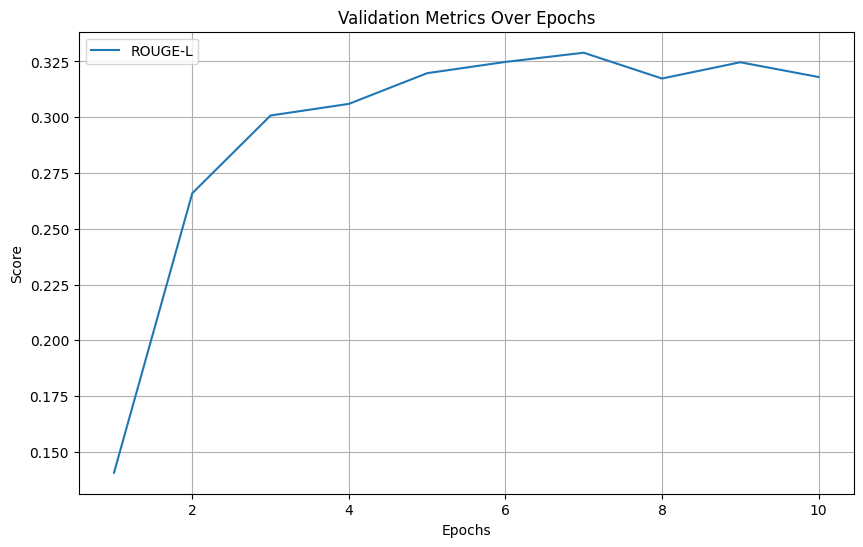

In [ ]:
import matplotlib.pyplot as plt

# Plot training loss over epochs

plt.figure(figsize=(10, 6))
#plt.plot(range(1, epochs + 1), bleu_scores, label='BLEU')
#plt.plot(range(1, epochs + 1), rouge1_scores, label='ROUGE-1')
#plt.plot(range(1, epochs + 1), rouge2_scores, label='ROUGE-2')
plt.plot(range(1, epochs + 1), rougeL_scores, label='ROUGE-L')
#plt.plot(range(1, epochs + 1), meteor_scores, label='METEOR')
#plt.plot(range(1, epochs + 1), bert_f1_scores, label='BERT F1')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.title('Validation Metrics Over Epochs')
plt.legend()
plt.grid()
plt.show()

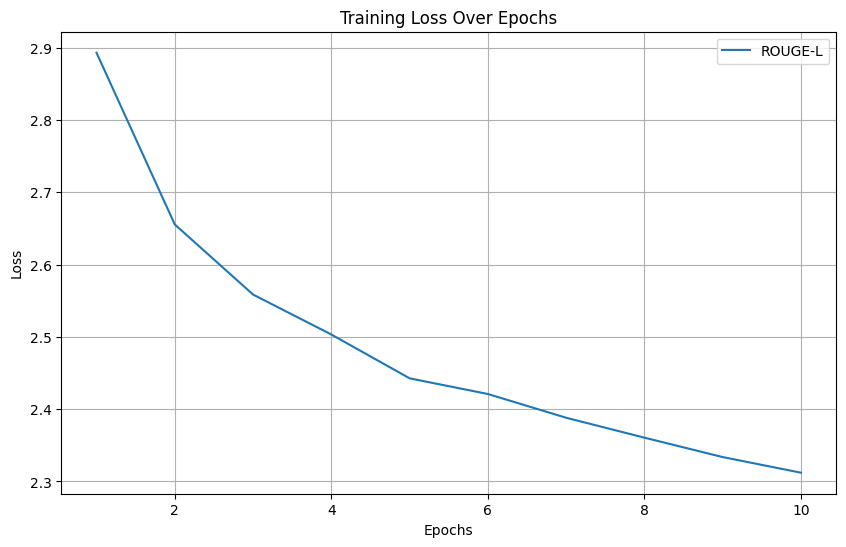

In [ ]:
import matplotlib.pyplot as plt

# Plot training loss over epochs

plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), training_losses, label='ROUGE-L')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Lists to store metrics over epochs
training_losses = []
bleu_scores_tr = []
rouge1_scores_tr = []
rouge2_scores_tr = []
rougeL_scores_tr = []
# meteor_scores_tr = []
bert_f1_scores_tr = []

bleu_scores_val = []
rouge1_scores_val = []
rouge2_scores_val = []
rougeL_scores_val = []
# meteor_scores_val = []
bert_f1_scores_val = []

 # Evaluate after each epoch
#metrics_tr = evaluate_model(blip_model, t5_model, blip_processor, t5_tokenizer, train_dataloader, device)
#bleu_scores_tr.append(metrics['BLEU'])
#rouge1_scores_tr.append(metrics['ROUGE-1'])
#rouge2_scores_tr.append(metrics['ROUGE-2'])
#rougeL_scores_tr.append(metrics['ROUGE-L'])
# meteor_scores_tr.append(metrics['METEOR'])
#bert_f1_scores_tr.append(metrics['BERT_F1'])

# Print training metrics
#print(f"Training Metrics: {metrics}")

metrics = evaluate_model(blip_model, t5_model, blip_processor, t5_tokenizer, val_dataloader, device)
bleu_scores_val.append(metrics['BLEU'])
rouge1_scores_val.append(metrics['ROUGE-1'])
rouge2_scores_val.append(metrics['ROUGE-2'])
rougeL_scores_val.append(metrics['ROUGE-L'])
# meteor_scores_val.append(metrics['METEOR'])
bert_f1_scores_val.append(metrics['BERT_F1'])

# Print training metrics
print(f"Validation Metrics: {metrics}")

Evaluating: 100%|██████████| 13/13 [03:40<00:00, 16.99s/it]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/7 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/4 [00:00<?, ?it/s]

done in 1.80 seconds, 111.12 sentences/sec
Validation Metrics: {'BLEU': 0.0489520958751794, 'ROUGE-1': 0.347989999171128, 'ROUGE-2': 0.11365381863130607, 'ROUGE-L': 0.31776546731197464, 'BERT_F1': 0.9026632905006409}


In [ ]:
import requests
import imageio
from PIL import Image
from io import BytesIO
import torch
from nltk.translate.bleu_score import corpus_bleu
from rouge_score import rouge_scorer
from bert_score import score as bert_score_fn
import torch.nn.functional as F

def process_and_evaluate_gif(
    gif_url,
    actual_description,
    blip_processor,
    blip_model,
    t5_tokenizer,
    t5_model,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    num_frames=5,
    frame_size=(256, 256),
    max_length=128,
    max_target_length=150,
    num_beams=4
):
    """
    Processes an unseen GIF to generate a description and evaluates it against the actual description.

    Args:
        gif_url (str): URL of the GIF to process.
        actual_description (str): The ground truth description of the GIF.
        blip_processor: BLIP processor instance.
        blip_model: Trained BLIP model instance.
        t5_tokenizer: T5 tokenizer instance.
        t5_model: Trained T5 model instance.
        device (str): Device to run the models on ('cuda' or 'cpu').
        num_frames (int): Number of frames to extract from the GIF.
        frame_size (tuple): Desired frame size (width, height).
        max_length (int): Maximum token length for T5 input.
        max_target_length (int): Maximum token length for T5 output.
        num_beams (int): Number of beams for beam search in T5 generation.

    Returns:
        dict: Evaluation metrics including BLEU, ROUGE-1, ROUGE-2, ROUGE-L, and BERT_F1.
    """
    # Step 1: Download the GIF
    try:
        response = requests.get(gif_url, timeout=10)
        response.raise_for_status()
        gif_bytes = BytesIO(response.content)
        print(f"Successfully downloaded GIF from {gif_url}")
    except requests.exceptions.RequestException as e:
        print(f"Failed to download GIF from {gif_url}: {e}")
        return None

    # Step 2: Extract frames from the GIF
    try:
        gif = imageio.mimread(gif_bytes, memtest=False)
        total_frames = len(gif)
        if total_frames == 0:
            print("No frames found in the GIF.")
            return None
        interval = max(total_frames // num_frames, 1)
        selected_frames = [gif[i] for i in range(0, total_frames, interval)][:num_frames]
        print(f"Extracted {len(selected_frames)} frames from the GIF.")
    except Exception as e:
        print(f"Error extracting frames from GIF: {e}")
        return None

    # Step 3: Ensure each GIF has exactly num_frames by padding if necessary
    while len(selected_frames) < num_frames:
        if selected_frames:
            selected_frames.append(selected_frames[-1])
        else:
            # Append a blank frame if no frames are extracted
            selected_frames.append(np.zeros((frame_size[1], frame_size[0], 3), dtype=np.uint8))
    selected_frames = selected_frames[:num_frames]  # Ensure no more than num_frames
    print(f"Total frames after padding: {len(selected_frames)}")

    # Step 4: Convert frames to PIL Images, resize, and generate captions using BLIP
    captions = []
    for idx, frame in enumerate(selected_frames):
        try:
            img = Image.fromarray(frame).convert('RGB')
            img_resized = img.resize(frame_size)
            inputs = blip_processor(img_resized, return_tensors="pt").to(device)
            with torch.no_grad():
                outputs = blip_model.generate(**inputs, max_length=50)
            caption = blip_processor.decode(outputs[0], skip_special_tokens=True)
            captions.append(caption)
            print(f"Frame {idx+1}: {caption}")
        except Exception as e:
            print(f"Failed to generate caption for frame {idx+1}: {e}")
            captions.append("")  # Append empty string for failed captions

    # Step 5: Concatenate captions to form T5 input
    concatenated_captions = " ".join(captions)
    print(f"Concatenated Captions: {concatenated_captions}")

    # Step 6: Tokenize the concatenated captions for T5
    try:
        encoding = t5_tokenizer.encode_plus(
            concatenated_captions,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        input_ids = encoding['input_ids'].to(device)
        attention_mask = encoding['attention_mask'].to(device)
    except Exception as e:
        print(f"Error during tokenization: {e}")
        return None

    # Step 7: Generate description using T5
    try:
        t5_model.eval()
        with torch.no_grad():
            outputs = t5_model.generate(
                input_ids=input_ids,
                attention_mask=attention_mask,
                max_length=max_target_length,
                num_beams=num_beams,
                early_stopping=True
            )
        generated_description = t5_tokenizer.decode(outputs[0], skip_special_tokens=True)
        print(f"Generated Description: {generated_description}")
    except Exception as e:
        print(f"Error during T5 generation: {e}")
        return None

    # Step 8: Evaluate the generated description against the actual description
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

    # Prepare tokenized inputs
    ref_tokens = actual_description.split()
    hyp_tokens = generated_description.split()

    # Calculate BLEU
    bleu = corpus_bleu([[ref_tokens]], [hyp_tokens])

    # Calculate ROUGE
    scores = scorer.score(actual_description, generated_description)
    rouge1 = scores['rouge1'].fmeasure
    rouge2 = scores['rouge2'].fmeasure
    rougeL = scores['rougeL'].fmeasure

    # Calculate BERT Score
    P, R, F1 = bert_score_fn(
        [' '.join(hyp_tokens)],
        [' '.join(ref_tokens)],
        lang='en',
        verbose=False
    )
    bert_f1 = F1.mean().item()

    # Compile metrics
    metrics = {
        'BLEU': bleu,
        'ROUGE-1': rouge1,
        'ROUGE-2': rouge2,
        'ROUGE-L': rougeL,
        'BERT_F1': bert_f1
    }

    # Display Metrics
    print("\nEvaluation Metrics:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")

    return {
        'generated_description': generated_description,
        'actual_description': actual_description,
        'metrics': metrics
    }


In [ ]:
# Example unseen GIF
unseen_gif = {
    'url': 'https://38.media.tumblr.com/f754d72da3c6a58211c760d39dff5be3/tumblr_n8vbphDLEh1qdzzbko1_250.gif',
    'actual_description': 'a man in a tuxedo stares as smoke rises next to him'
}

# Process and evaluate the unseen GIF
result = process_and_evaluate_gif(
    gif_url=unseen_gif['url'],
    actual_description=unseen_gif['actual_description'],
    blip_processor=blip_processor,
    blip_model=blip_model,
    t5_tokenizer=t5_tokenizer,
    t5_model=t5_model,
    device=device,
    num_frames=5,
    frame_size=(256, 256),
    max_length=128,
    max_target_length=150,
    num_beams=4
)

# Check the result
if result:
    print("\nFinal Results:")
    print(f"Generated Description: {result['generated_description']}")
    print(f"Actual Description: {result['actual_description']}")
    print("Evaluation Metrics:")
    for metric, score in result['metrics'].items():
        print(f"  {metric}: {score:.4f}")
else:
    print("Processing and evaluation failed.")


Successfully downloaded GIF from https://38.media.tumblr.com/f754d72da3c6a58211c760d39dff5be3/tumblr_n8vbphDLEh1qdzzbko1_250.gif
Extracted 5 frames from the GIF.
Total frames after padding: 5
Frame 1: a man in a tuxed suit and bow tie
Frame 2: a man in a tuxed suit and bow tie
Frame 3: a man in a tuxed suit and bow tie
Frame 4: a man in a tuxed suit and bow tie
Frame 5: a man in a tuxed suit and bow tie
Concatenated Captions: a man in a tuxed suit and bow tie a man in a tuxed suit and bow tie a man in a tuxed suit and bow tie a man in a tuxed suit and bow tie a man in a tuxed suit and bow tie
Generated Description: a man is dancing in a tuxedo with a bow.


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Evaluation Metrics:
BLEU: 0.0000
ROUGE-1: 0.4545
ROUGE-2: 0.3000
ROUGE-L: 0.4545
BERT_F1: 0.9169

Final Results:
Generated Description: a man is dancing in a tuxedo with a bow.
Actual Description: a man in a tuxedo stares as smoke rises next to him
Evaluation Metrics:
  BLEU: 0.0000
  ROUGE-1: 0.4545
  ROUGE-2: 0.3000
  ROUGE-L: 0.4545
  BERT_F1: 0.9169
